<a href="https://colab.research.google.com/github/hugohiraoka/Travel_Package_Purchase_Prediction/blob/main/Fantasy_Tour_Package.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting Tour Package Customers for Fantasy Tours**

The Policy Maker of Fantasy Tours (Fantasy) wants to enable and establish a viable business model to expand the customer base.

One of the ways to expand the customer base is to introduce a new offering of packages.

Currently, there are 5 types of packages the company is offering - Basic, Standard, Deluxe, Super Deluxe, King. Looking at the data of the last year, we observed that 18% of the customers purchased the packages.

However, Fantasy had difficulties identifying the potential customers because customers were contacted at random without looking at the available information.

![](https://i.imgur.com/KOYSuRs.jpg)

Fantasy is now planning to launch a new product i.e. Wellness Tourism Package. Wellness Tourism is defined as Travel that allows the traveler to maintain, enhance or kick-start a healthy lifestyle, and support or increase one's sense of well-being.

This time Fantasy wants to harness the available data of existing and potential customers to target the right customers.

We will analyze Fantasy's data and information to provide recommendations to the Policy Maker and build a model to predict the potential customer who is going to purchase the newly introduced travel package. A model will be built to make predictions before a customer is contacted.




##**Objective**

To predict which customer is more likely to purchase the newly introduced travel package.




##**Data Dictionary**

Customer details:

- CustomerID: Unique customer ID

- ProdTaken: Whether the customer has purchased a package or not (0: No, 1: Yes)

- Age: Age of customer

- TypeofContact: How customer was contacted (Company Invited or Self Inquiry)

- CityTier: City tier depends on the development of a city, population, facilities, and living standards. The categories are ordered i.e. Tier 1 > Tier 2 > Tier 3. It's the city the customer lives in.

- Occupation: Occupation of customer

- Gender: Gender of customer

- NumberOfPersonVisiting: Total number of persons planning to take the trip with the customer

- PreferredPropertyStar: Preferred hotel property rating by customer

- MaritalStatus: Marital status of customer

- NumberOfTrips: Average number of trips in a year by customer

- Passport: The customer has a passport or not (0: No, 1: Yes)

- OwnCar: Whether the customers own a car or not (0: No, 1: Yes)

- NumberOfChildrenVisiting: Total number of children with age less than 5 planning to take the trip with the customer

- Designation: Designation of the customer in the current organization

- MonthlyIncome: Gross monthly income of the customer

Customer interaction data:
- PitchSatisfactionScore: Sales pitch satisfaction score
- ProductPitched: Product pitched by the salesperson
- NumberOfFollowups: Total number of follow-ups has been done by the salesperson after the sales pitch
- DurationOfPitch: Duration of the pitch by a salesperson to the customer

##**Setup**

###**Import Libraries**

In [1]:
!pip install xgboost

In [2]:
#import libraries
import math
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier, RandomForestRegressor, RandomForestClassifier,GradientBoostingClassifier,GradientBoostingRegressor, AdaBoostClassifier,AdaBoostRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from xgboost import XGBRegressor,XGBClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

###**Useful Functions**

Functions that we will use in this notebook

In [3]:
#Function to show %
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

# function to create labeled barplots

def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 2, 6))
    else:
        plt.figure(figsize=(n + 2, 6))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n],
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot


def histogram_boxplot(data, feature, figsize=(15, 10), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (15,10))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a triangle will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

# function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100


# function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    r2 = r2_score(target, pred)  # to compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)  # to compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # to compute RMSE
    mae = mean_absolute_error(target, pred)  # to compute MAE
    mape = mape_score(target, pred)  # to compute MAPE

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf

##  Function to calculate r2_score and RMSE on train and test data
def get_model_score(model, flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    score_list=[]

    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    train_r2=metrics.r2_score(y_train,pred_train)
    test_r2=metrics.r2_score(y_test,pred_test)
    train_rmse=np.sqrt(metrics.mean_squared_error(y_train,pred_train))
    test_rmse=np.sqrt(metrics.mean_squared_error(y_test,pred_test))

    #Adding all scores in the list
    score_list.extend((train_r2,test_r2,train_rmse,test_rmse))

    # If the flag is set to True then only the following print statements will be dispayed, the default value is True
    if flag==True:
        print("R-sqaure on training set : ",metrics.r2_score(y_train,pred_train))
        print("R-square on test set : ",metrics.r2_score(y_test,pred_test))
        print("RMSE on training set : ",np.sqrt(metrics.mean_squared_error(y_train,pred_train)))
        print("RMSE on test set : ",np.sqrt(metrics.mean_squared_error(y_test,pred_test)))

    # returning the list with train and test scores
    return score_list

## Function to create confusion matrix
def make_confusion_matrix(model,y_actual,labels=[1, 0]):
    '''
    model : classifier to predict values of X
    y_actual : ground truth

    '''
    y_predict = model.predict(X_test)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

##  Function to calculate different metric scores of the model - Accuracy, Recall and Precision
def get_metrics_score(model,flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    score_list=[]

    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    train_acc = model.score(X_train,y_train)
    test_acc = model.score(X_test,y_test)

    train_recall = metrics.recall_score(y_train,pred_train)
    test_recall = metrics.recall_score(y_test,pred_test)

    train_precision = metrics.precision_score(y_train,pred_train)
    test_precision = metrics.precision_score(y_test,pred_test)

    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision))

    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True:
        print("Accuracy on training set : ",model.score(X_train,y_train))
        print("Accuracy on test set : ",model.score(X_test,y_test))
        print("Recall on training set : ",metrics.recall_score(y_train,pred_train))
        print("Recall on test set : ",metrics.recall_score(y_test,pred_test))
        print("Precision on training set : ",metrics.precision_score(y_train,pred_train))
        print("Precision on test set : ",metrics.precision_score(y_test,pred_test))

    return score_list # returning the list with train and test scores

###**Setup**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from urllib.parse import urldefrag
#read excel file and load sheet 'Data Dict' into dataframe
vu_dataDict = pd.read_excel('/content/drive/MyDrive/Notebooks/Travel_Package/Data/Tourism.xlsx', sheet_name='Data Dict')

#read excel file, load sheet "Tourism" as a dataframe
vu_Tourism = pd.read_excel('/content/drive/MyDrive/Notebooks/Travel_Package/Data/Tourism.xlsx', sheet_name='Tourism')

#make a copy of the original dataframe
vu_Tourism_cp = vu_Tourism.copy()

In [6]:
# computing number of columns, minus the ID that doesn't provide any valuable information
cols = len(vu_Tourism.axes[1])
count = 0
print("These features have null values: ")
while (count < cols):
    if vu_Tourism[vu_Tourism.columns[count]].isnull().values.sum() != 0 :
      print(vu_Tourism.columns[count], "has ",vu_Tourism[vu_Tourism.columns[count]].isnull().values.sum()," null values")
    count = count + 1


These features have null values: 
Age has  226  null values
TypeofContact has  25  null values
DurationOfPitch has  251  null values
NumberOfFollowups has  45  null values
PreferredPropertyStar has  26  null values
NumberOfTrips has  140  null values
NumberOfChildrenVisiting has  66  null values
MonthlyIncome has  233  null values


##**Initial Data Exploration**

In [7]:
#shape of Data Dictionary
vu_dataDict.shape

(21, 4)

In [8]:
#display all data dict
vu_dataDict.head(21)

Unnamed: 0 Unnamed: 1                Unnamed: 2  \
0          NaN       Data                  Variable   
1          NaN    Tourism                CustomerID   
2          NaN    Tourism                 ProdTaken   
3          NaN    Tourism                       Age   
4          NaN    Tourism             TypeofContact   
5          NaN    Tourism                  CityTier   
6          NaN    Tourism           DurationOfPitch   
7          NaN    Tourism                Occupation   
8          NaN    Tourism                    Gender   
9          NaN    Tourism    NumberOfPersonVisiting   
10         NaN    Tourism         NumberOfFollowups   
11         NaN    Tourism            ProductPitched   
12         NaN    Tourism     PreferredPropertyStar   
13         NaN    Tourism             MaritalStatus   
14         NaN    Tourism             NumberOfTrips   
15         NaN    Tourism                  Passport   
16         NaN    Tourism    PitchSatisfactionScore   
17         NaN    Tourism                    OwnCar   
18         NaN    Tourism  NumberOfChildrenVisiting   
19         NaN    Tourism               Designation   
20         NaN    Tourism             MonthlyIncome   

                                           Unnamed: 3  
0                                         Discerption  
1                                  Unique customer ID  
2   Whether the customer has purchased a package o...  
3                                     Age of customer  
4   How customer was contacted (Company Invited or...  
5   City tier depends on the development of a city...  
6   Duration of the pitch by a salesperson to the ...  
7                              Occupation of customer  
8                                  Gender of customer  
9   Total number of persons planning to take the t...  
10  Total number of follow-ups has been done by sa...  
11                 Product pitched by the salesperson  
12        Preferred hotel property rating by customer  
13                         Marital status of customer  
14      Average number of trips in a year by customer  
15  The customer has a passport or not (0: No, 1: ...  
16                     Sales pitch satisfaction score  
17  Whether the customers own a car or not (0: No,...  
18  Total number of children with age less than 5 ...  
19  Designation of the customer in the current org...  
20               Gross monthly income of the customer

20 features including CustomerID which can be dropped.

In [9]:
#shape of Tourism
vu_Tourism.shape

(4888, 20)

In [10]:
#visualize first 20 rows of Tourism
vu_Tourism.head(20)

CustomerID  ProdTaken   Age    TypeofContact  CityTier  DurationOfPitch  \
0       200000          1  41.0     Self Enquiry         3              6.0   
1       200001          0  49.0  Company Invited         1             14.0   
2       200002          1  37.0     Self Enquiry         1              8.0   
3       200003          0  33.0  Company Invited         1              9.0   
4       200004          0   NaN     Self Enquiry         1              8.0   
5       200005          0  32.0  Company Invited         1              8.0   
6       200006          0  59.0     Self Enquiry         1              9.0   
7       200007          0  30.0     Self Enquiry         1             30.0   
8       200008          0  38.0  Company Invited         1             29.0   
9       200009          0  36.0     Self Enquiry         1             33.0   
10      200010          0  35.0     Self Enquiry         1             22.0   
11      200011          0   NaN     Self Enquiry         1             21.0   
12      200012          0  31.0     Self Enquiry         1             32.0   
13      200013          0  34.0     Self Enquiry         1             25.0   
14      200014          1  28.0     Self Enquiry         1             30.0   
15      200015          0  29.0     Self Enquiry         1             27.0   
16      200016          0  32.0     Self Enquiry         1             11.0   
17      200017          0  22.0  Company Invited         1             22.0   
18      200018          0  53.0     Self Enquiry         3              8.0   
19      200019          0   NaN     Self Enquiry         1              8.0   

        Occupation  Gender  NumberOfPersonVisiting  NumberOfFollowups  \
0         Salaried  Female                       3                3.0   
1         Salaried    Male                       3                4.0   
2      Free Lancer    Male                       3                4.0   
3         Salaried  Female                       2                3.0   
4   Small Business    Male                       2                3.0   
5         Salaried    Male                       3                3.0   
6   Small Business  Female                       2                2.0   
7         Salaried    Male                       3                3.0   
8         Salaried    Male                       2                4.0   
9   Small Business    Male                       3                3.0   
10  Small Business    Male                       2                2.0   
11        Salaried  Female                       2                4.0   
12        Salaried    Male                       2                3.0   
13  Small Business    Male                       3                3.0   
14        Salaried    Male                       2                4.0   
15        Salaried  Female                       2                2.0   
16        Salaried    Male                       3                2.0   
17  Small Business    Male                       3                2.0   
18        Salaried  Female                       3                4.0   
19        Salaried    Male                       2                3.0   

   ProductPitched  PreferredPropertyStar MaritalStatus  NumberOfTrips  \
0          Deluxe                    3.0        Single            1.0   
1          Deluxe                    4.0      Divorced            2.0   
2           Basic                    3.0        Single            7.0   
3           Basic                    3.0      Divorced            2.0   
4           Basic                    4.0      Divorced            1.0   
5           Basic                    3.0        Single            1.0   
6           Basic                    5.0      Divorced            5.0   
7           Basic                    3.0       Married            2.0   
8        Standard                    3.0     Unmarried            1.0   
9          Deluxe                    3.0      Divorced            7.0   
10     

There are 20 features and 4888 entries.

In [11]:
#visualize the datatype and if features have null values
vu_Tourism.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4888 entries, 0 to 4887
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CustomerID                4888 non-null   int64  
 1   ProdTaken                 4888 non-null   int64  
 2   Age                       4662 non-null   float64
 3   TypeofContact             4863 non-null   object 
 4   CityTier                  4888 non-null   int64  
 5   DurationOfPitch           4637 non-null   float64
 6   Occupation                4888 non-null   object 
 7   Gender                    4888 non-null   object 
 8   NumberOfPersonVisiting    4888 non-null   int64  
 9   NumberOfFollowups         4843 non-null   float64
 10  ProductPitched            4888 non-null   object 
 11  PreferredPropertyStar     4862 non-null   float64
 12  MaritalStatus             4888 non-null   object 
 13  NumberOfTrips             4748 non-null   float64
 14  Passport

Notice that there are several object data types: TypeofContact, Occupation, Gender, ProductPitched, MaritalStatus, and Designation.

Also notice that there are features with null values.


## **EDA and Feature Engineering**

[Imputation (Statistics)](https://en.wikipedia.org/wiki/Imputation_(statistics))

[How to decide which imputation technique to use?](https://vitalflux.com/pandas-impute-missing-values-mean-median-mode/#:~:text=There%20are%20three%20main%20missing,for%20two%20or%20more%20sets.)

###**Overview of Dataset**

In [12]:
#Analyze features
print(vu_Tourism.ProdTaken.value_counts(),"\n")
print(vu_Tourism.Age.value_counts(),"\n")
print(vu_Tourism.TypeofContact.value_counts(),"\n")
print(vu_Tourism.CityTier.value_counts(),"\n")
print(vu_Tourism.DurationOfPitch.value_counts(),"\n")
print(vu_Tourism.Occupation.value_counts(),"\n")
print(vu_Tourism.Gender.value_counts(),"\n")
print(vu_Tourism.NumberOfPersonVisiting.value_counts(),"\n")
print(vu_Tourism.NumberOfFollowups.value_counts(),"\n")
print(vu_Tourism.ProductPitched.value_counts(),"\n")
print(vu_Tourism.PreferredPropertyStar.value_counts(),"\n")
print(vu_Tourism.MaritalStatus.value_counts(),"\n")
print(vu_Tourism.NumberOfTrips.value_counts(),"\n")
print(vu_Tourism.Passport.value_counts(),"\n")
print(vu_Tourism.PitchSatisfactionScore.value_counts(),"\n")
print(vu_Tourism.OwnCar.value_counts(),"\n")
print(vu_Tourism.NumberOfChildrenVisiting.value_counts(),"\n")
print(vu_Tourism.Designation.value_counts(),"\n")
print(vu_Tourism.MonthlyIncome.value_counts(),"\n")

0    3968
1     920
Name: ProdTaken, dtype: int64 

35.0    237
36.0    231
34.0    211
31.0    203
30.0    199
32.0    197
33.0    189
37.0    185
29.0    178
38.0    176
41.0    155
39.0    150
28.0    147
40.0    146
42.0    142
27.0    138
43.0    130
46.0    121
45.0    116
26.0    106
44.0    105
51.0     90
47.0     88
50.0     86
25.0     74
52.0     68
53.0     66
48.0     65
49.0     65
55.0     64
54.0     61
56.0     58
24.0     56
22.0     46
23.0     46
59.0     44
21.0     41
20.0     38
19.0     32
58.0     31
57.0     29
60.0     29
18.0     14
61.0      9
Name: Age, dtype: int64 

Self Enquiry       3444
Company Invited    1419
Name: TypeofContact, dtype: int64 

1    3190
3    1500
2     198
Name: CityTier, dtype: int64 

9.0      483
7.0      342
8.0      333
6.0      307
16.0     274
15.0     269
14.0     253
10.0     244
13.0     223
11.0     205
12.0     195
17.0     172
30.0      95
22.0      89
31.0      83
23.0      79
18.0      75
29.0      74
32.0      74
25

In [13]:
#Lets drop CustomerID because it doesn't contribute any valuable information
vu_Tourism = vu_Tourism.drop('CustomerID', axis=1)

In [14]:
#statistics of dataset
vu_Tourism.describe().T

count          mean          std     min      25%  \
ProdTaken                 4888.0      0.188216     0.390925     0.0      0.0   
Age                       4662.0     37.622265     9.316387    18.0     31.0   
CityTier                  4888.0      1.654255     0.916583     1.0      1.0   
DurationOfPitch           4637.0     15.490835     8.519643     5.0      9.0   
NumberOfPersonVisiting    4888.0      2.905074     0.724891     1.0      2.0   
NumberOfFollowups         4843.0      3.708445     1.002509     1.0      3.0   
PreferredPropertyStar     4862.0      3.581037     0.798009     3.0      3.0   
NumberOfTrips             4748.0      3.236521     1.849019     1.0      2.0   
Passport                  4888.0      0.290917     0.454232     0.0      0.0   
PitchSatisfactionScore    4888.0      3.078151     1.365792     1.0      2.0   
OwnCar                    4888.0      0.620295     0.485363     0.0      0.0   
NumberOfChildrenVisiting  4822.0      1.187267     0.857861     0.0      1.0   
MonthlyIncome             4655.0  23619.853491  5380.698361  1000.0  20346.0   

                              50%      75%      max  
ProdTaken                     0.0      0.0      1.0  
Age                          36.0     44.0     61.0  
CityTier                      1.0      3.0      3.0  
DurationOfPitch              13.0     20.0    127.0  
NumberOfPersonVisiting        3.0      3.0      5.0  
NumberOfFollowups             4.0      4.0      6.0  
PreferredPropertyStar         3.0      4.0      5.0  
NumberOfTrips                 3.0      4.0     22.0  
Passport                      0.0      1.0      1.0  
PitchSatisfactionScore        3.0      4.0      5.0  
OwnCar                        1.0      1.0      1.0  
NumberOfChildrenVisiting      1.0      2.0      3.0  
MonthlyIncome             22347.0  25571.0  98678.0

Some information is useful:
- The average age is 37, max is 61, and min is 18
- The duration of Pitch mean is 15min, the max is 127min, and min is 5min. 50% of pitches are at least 13min.
- 18% of customers purchased a Package

We will use the dataframe containing no Nulls to estimate means, medians, modes for null data imputation.

### **Univariate Analysis**

####**Feature ProdTaken**

ProdTaken is actually the prediction to predict. There are no Null values.

In [15]:
print(vu_Tourism['ProdTaken'].isnull().values.sum()," null ProdTaken entries")
print(vu_Tourism.ProdTaken.value_counts(),"\n")

0  null ProdTaken entries
0    3968
1     920
Name: ProdTaken, dtype: int64 



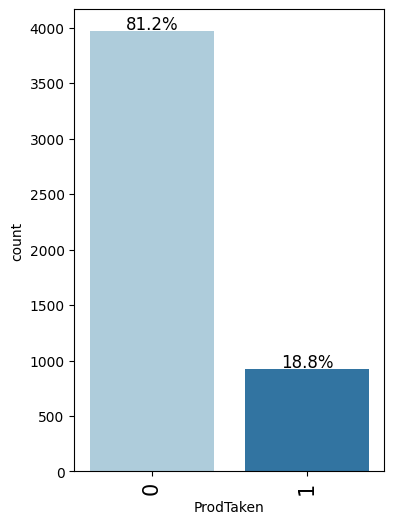

In [16]:
#ProdTaken Distribution
labeled_barplot(vu_Tourism,'ProdTaken',perc=True)

In [17]:
vu_Tourism.head()

ProdTaken   Age    TypeofContact  CityTier  DurationOfPitch  \
0          1  41.0     Self Enquiry         3              6.0   
1          0  49.0  Company Invited         1             14.0   
2          1  37.0     Self Enquiry         1              8.0   
3          0  33.0  Company Invited         1              9.0   
4          0   NaN     Self Enquiry         1              8.0   

       Occupation  Gender  NumberOfPersonVisiting  NumberOfFollowups  \
0        Salaried  Female                       3                3.0   
1        Salaried    Male                       3                4.0   
2     Free Lancer    Male                       3                4.0   
3        Salaried  Female                       2                3.0   
4  Small Business    Male                       2                3.0   

  ProductPitched  PreferredPropertyStar MaritalStatus  NumberOfTrips  \
0         Deluxe                    3.0        Single            1.0   
1         Deluxe                    4.0      Divorced            2.0   
2          Basic                    3.0        Single            7.0   
3          Basic                    3.0      Divorced            2.0   
4          Basic                    4.0      Divorced            1.0   

   Passport  PitchSatisfactionScore  OwnCar  NumberOfChildrenVisiting  \
0         1                       2       1                       0.0   
1         0                       3       1                       2.0   
2         1                       3       0                       0.0   
3         1                       5       1                       1.0   
4         0                       5       1                       0.0   

  Designation  MonthlyIncome  
0     Manager        20993.0  
1     Manager        20130.0  
2   Executive        17090.0  
3   Executive        17909.0  
4   Executive        18468.0

Notice that 81 of customers didn't buy a package. Only 19 of customers bought a package.
This feature has no Null values.

#### **Feature Age**

Age has null values that must be taken care of.

In [18]:
#Analyze Feature Age
print(vu_Tourism['Age'].isnull().values.sum()," null Age entries")
print(vu_Tourism.Age.value_counts(),"\n")

226  null Age entries
35.0    237
36.0    231
34.0    211
31.0    203
30.0    199
32.0    197
33.0    189
37.0    185
29.0    178
38.0    176
41.0    155
39.0    150
28.0    147
40.0    146
42.0    142
27.0    138
43.0    130
46.0    121
45.0    116
26.0    106
44.0    105
51.0     90
47.0     88
50.0     86
25.0     74
52.0     68
53.0     66
48.0     65
49.0     65
55.0     64
54.0     61
56.0     58
24.0     56
22.0     46
23.0     46
59.0     44
21.0     41
20.0     38
19.0     32
58.0     31
57.0     29
60.0     29
18.0     14
61.0      9
Name: Age, dtype: int64 



226 entries with Null Age

In [19]:
#What is the median, mean, and mode of the Age feature
#Age should we drop, median, or mode?
print("Age median, mean, mode considering Null Values")
print("Age median: ",vu_Tourism['Age'].median())
print("Age mean  : ",vu_Tourism['Age'].mean())
Age_mode = vu_Tourism['Age'].mode()
print("Age mode  : ",Age_mode[0],"\n")

Age median, mean, mode considering Null Values
Age median:  36.0
Age mean  :  37.62226512226512
Age mode  :  35.0 



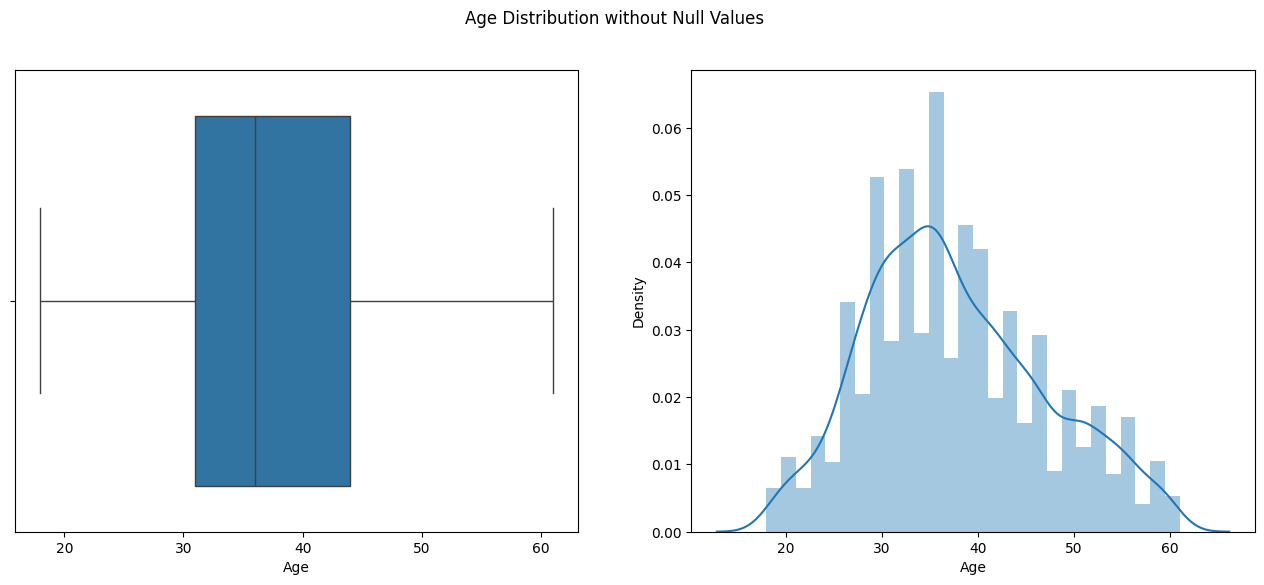

In [20]:
#Visualize Age Distribution plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
fig.suptitle('Age Distribution without Null Values', fontsize=12)
sns.boxplot(data=vu_Tourism,x='Age', ax=ax1)
sns.distplot(vu_Tourism.Age,ax=ax2)
plt.show()

We are going to use the mean, median, or modeto imputate the null values instead of dropping those rows.

In [21]:
#Round age to the nearest smallest whole number because even people aged xx.90 will always say they are xx years old.
age_mean = math.floor(vu_Tourism['Age'].mean())
age_median = math.floor(vu_Tourism['Age'].median())
age_mode= math.floor(vu_Tourism['Age'].mode())
print("Age mean: ",age_mean)
print("Age median  : ",age_median)
print("Age mode  : ",age_mode)

Age mean:  37
Age median  :  36
Age mode  :  35


Lets replace NaN Age with the mean because the median because the data is not skewed, it is mostly symmetrical.

In [22]:
vu_Tourism["Age"].fillna(age_mean, inplace = True)

How did the overall Age mean, median, mode change?

In [23]:
print("Age mean  : ",math.floor(vu_Tourism['Age'].mean()))
print("Age median: ",math.floor(vu_Tourism['Age'].median()))
age_mode = math.floor(vu_Tourism['Age'].mode())
print("Age mode  : ",age_mode)

Age mean  :  37
Age median:  37
Age mode  :  37


The median changed from 35 to 36, the mode changed from 36 to 37.

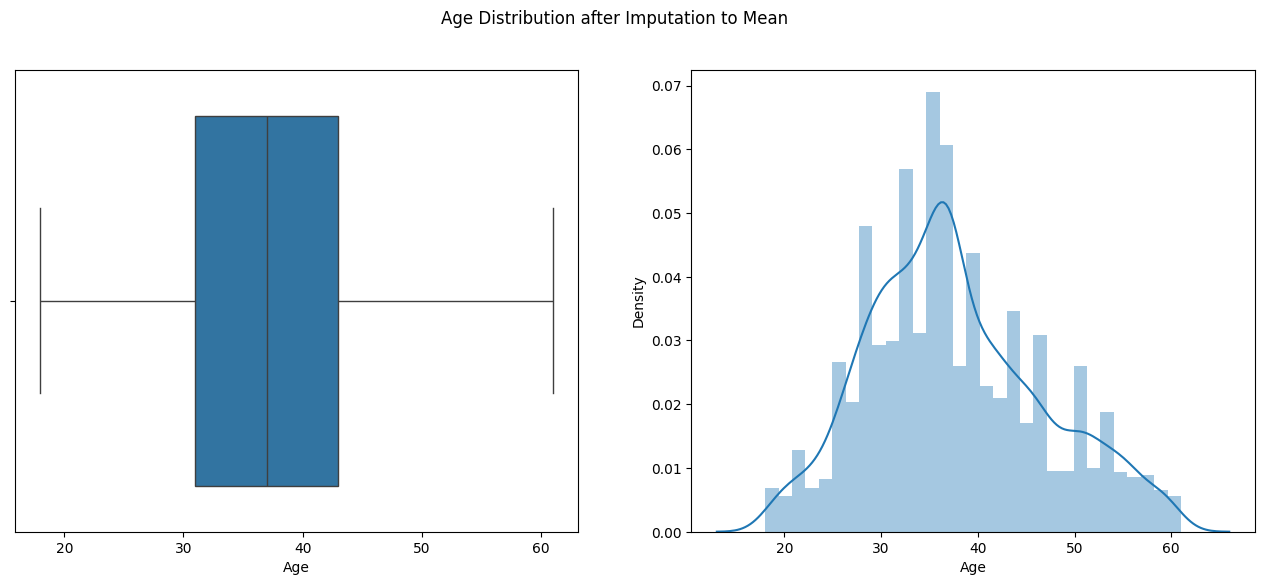

In [24]:
#Visualize Age Distribution plots After Imputation to Mean
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
fig.suptitle('Age Distribution after Imputation to Mean', fontsize=12)
sns.boxplot(data=vu_Tourism,x='Age', ax=ax1)
sns.distplot(vu_Tourism.Age,ax=ax2)
plt.show()

In [25]:
print(vu_Tourism['Age'].isnull().values.sum()," null Age entries")

0  null Age entries


####**Feature Gender**

Notice that Gender has 3 different entries: Male, Female, and Fe Male.  It has no null values.
Lets fix Fe Male to Female.

In [26]:
#Fix Female "Fe Male" to "Female"
vu_Tourism.loc[vu_Tourism["Gender"] == "Fe Male", "Gender"] = "Female"

In [27]:
print(vu_Tourism.Gender.value_counts())

Male      2916
Female    1972
Name: Gender, dtype: int64


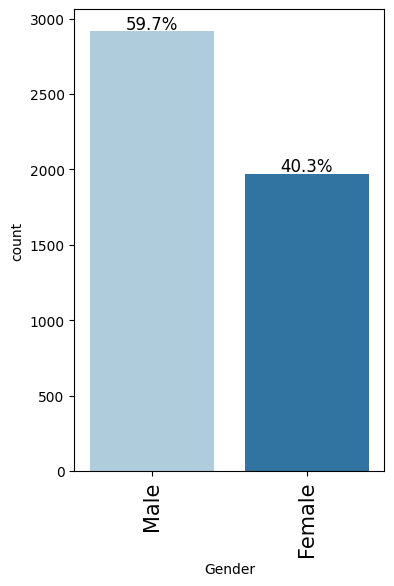

In [28]:
#Gender distribution
labeled_barplot(vu_Tourism,"Gender",perc=True)

Gender has no null values. We will convert Gender to dummies later.

#### **Feature TypeofContact**

In [29]:
#Analyze Feature TypeofContact
print(vu_Tourism['TypeofContact'].isnull().values.sum()," null TypeofContact entries")
print(vu_Tourism.TypeofContact.value_counts(),"\n")

25  null TypeofContact entries
Self Enquiry       3444
Company Invited    1419
Name: TypeofContact, dtype: int64 



There are 2 types of TypeofContact: Self Enquiry and Company Invited.
There are only 25 null entries.

In this case we are going to imputate to Self Enquiry and Company Invited based in the percentage of entries for each type.

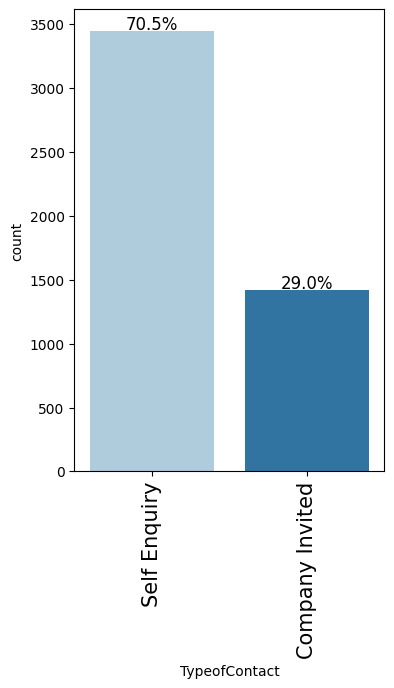

In [30]:
#Distribution of TypeofContact
labeled_barplot(vu_Tourism,"TypeofContact",perc=True)

In [31]:
#number rows with no null TypeofContact
TypeofContact_noNull=vu_Tourism['TypeofContact'].notnull().sum()

print("TypeofContact has",TypeofContact_noNull," NOT null values")
#Calculate the percentages
SelfInquiryPer= math.ceil((vu_Tourism.TypeofContact.value_counts()[0]*100)/TypeofContact_noNull)
CompanyInvitedPer = math.floor((vu_Tourism.TypeofContact.value_counts()[1]*100)/TypeofContact_noNull)

TypeofContact_Null = vu_Tourism['TypeofContact'].isnull().values.sum()

ImputateToSelf = math.ceil(TypeofContact_Null * SelfInquiryPer/100)
ImputateToInvited = math.floor(TypeofContact_Null * CompanyInvitedPer/100)
print ("Percentage of Self Inquiry ",SelfInquiryPer,"% - Imputate ",ImputateToSelf, "null entries as Self Inquiry")
print("Percentage of Company Invited ",CompanyInvitedPer,"%- Imputate ",ImputateToInvited, "null entries as Company Invited")
print(ImputateToSelf )
print(ImputateToInvited)

TypeofContact has 4863  NOT null values
Percentage of Self Inquiry  71 % - Imputate  18 null entries as Self Inquiry
Percentage of Company Invited  29 %- Imputate  7 null entries as Company Invited
18
7


In [32]:
#Imputate null values
vu_Tourism['TypeofContact'].fillna(value="Self Enquiry", inplace=True,limit=ImputateToSelf)
vu_Tourism['TypeofContact'].fillna(value="Company Invited",inplace=True,limit=ImputateToInvited)

#Number of null values after imputation
#Analyze Feature Age including Null entries
print(vu_Tourism['TypeofContact'].isnull().values.sum()," null TypeofContact entries")
print(vu_Tourism.TypeofContact.value_counts(),"\n")

0  null TypeofContact entries
Self Enquiry       3462
Company Invited    1426
Name: TypeofContact, dtype: int64 



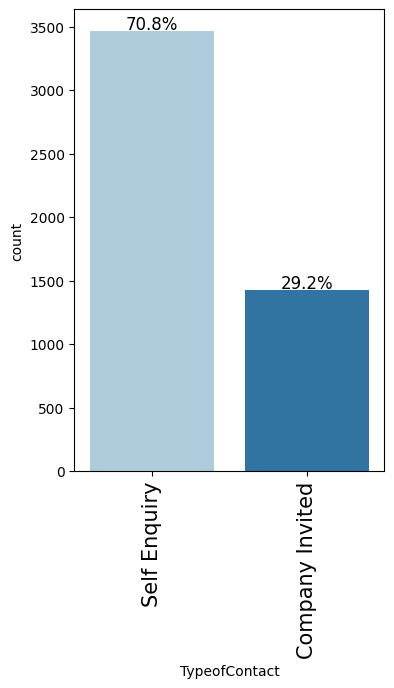

In [33]:
#Distribution of TypeofContact after null data imputation
labeled_barplot(vu_Tourism,"TypeofContact",perc=True)

After null values imputation, 70.8% of all customers (whethey they purchased a package or not), are Self Enqury and 29.2% are Company invited. We will convert feature to dummy variables later.

####**Feature DurationOfPitch**

In [34]:
#Analyze Feature Age including Null entries
print(vu_Tourism['DurationOfPitch'].isnull().values.sum()," null DurationOfPitch entries")
print(vu_Tourism.DurationOfPitch.value_counts(),"\n")

251  null DurationOfPitch entries
9.0      483
7.0      342
8.0      333
6.0      307
16.0     274
15.0     269
14.0     253
10.0     244
13.0     223
11.0     205
12.0     195
17.0     172
30.0      95
22.0      89
31.0      83
23.0      79
18.0      75
29.0      74
32.0      74
25.0      73
21.0      73
27.0      72
26.0      72
24.0      70
35.0      66
20.0      65
28.0      61
33.0      57
19.0      57
34.0      50
36.0      44
5.0        6
126.0      1
127.0      1
Name: DurationOfPitch, dtype: int64 



lets relate Duration of Pitch to ProdTaken and PitchSatisfactionScore.
Notice that ProdTaken and PitchSatisfactionScore do not have null values.


In [35]:
#First lets analyze DurationOfPicth with vu_Tourism_noNull that contains no null values

DOP_mean = vu_Tourism['DurationOfPitch'].mean()
DOP_median = vu_Tourism['DurationOfPitch'].median()
DOP_mode = vu_Tourism['DurationOfPitch'].mode()

print("DurationOfPitch: \n")
print("mean   : ", math.ceil(DOP_mean))
print("median : ", DOP_median)
print("mode   : ", DOP_mode[0])

DurationOfPitch: 

mean   :  16
median :  13.0
mode   :  9.0


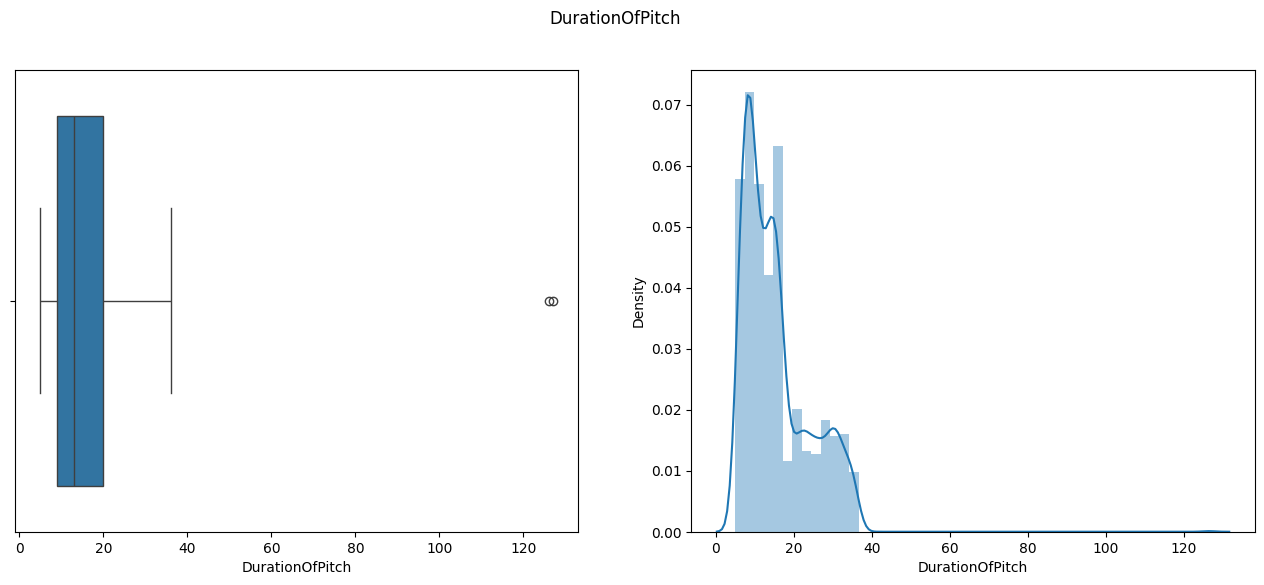

In [36]:
#Visualize Duration of Pitch
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
fig.suptitle('DurationOfPitch', fontsize=12)
sns.boxplot(data=vu_Tourism,x='DurationOfPitch', ax=ax1)
sns.distplot(vu_Tourism.DurationOfPitch,ax=ax2)
plt.show()

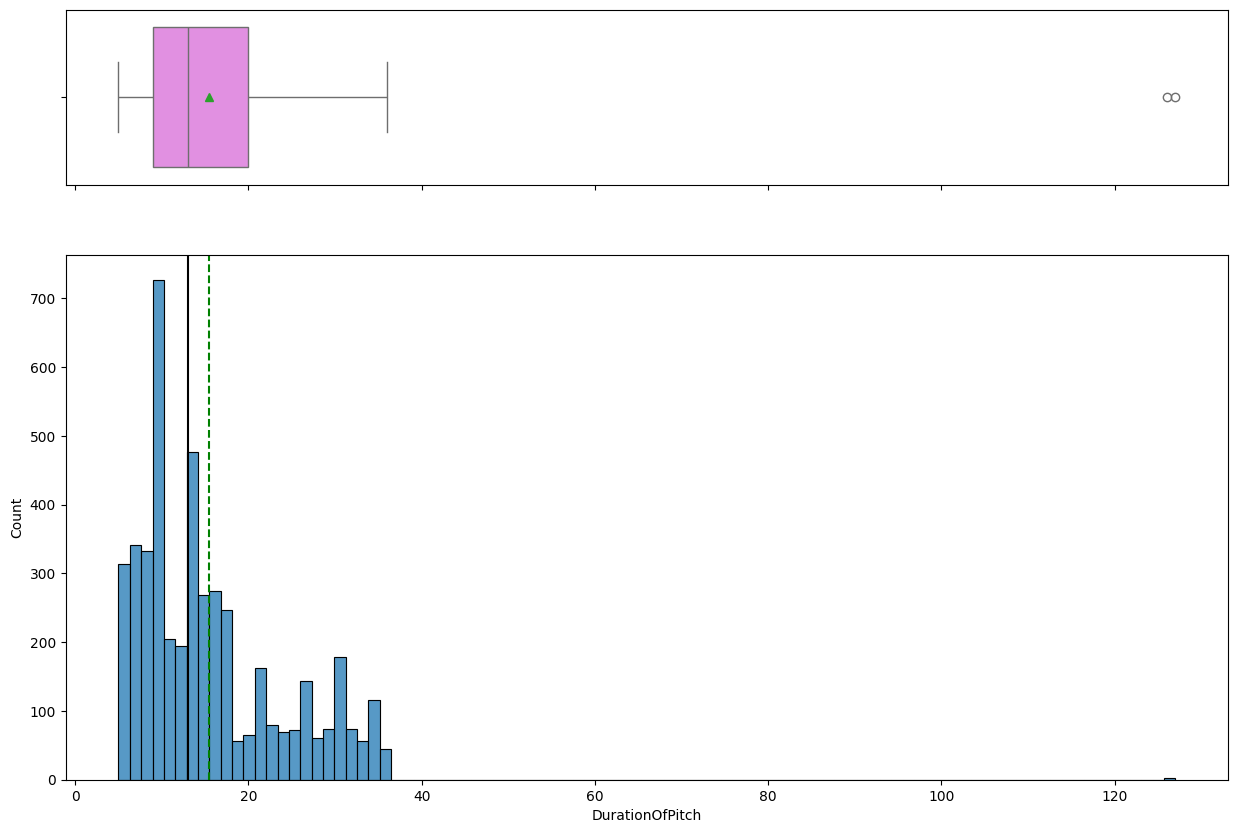

In [37]:
histogram_boxplot(vu_Tourism,'DurationOfPitch')

There are 2 outliers in DurationOfPitch: 5, 126, and 127.
These look like extraordinary cases. These may actually be good values.

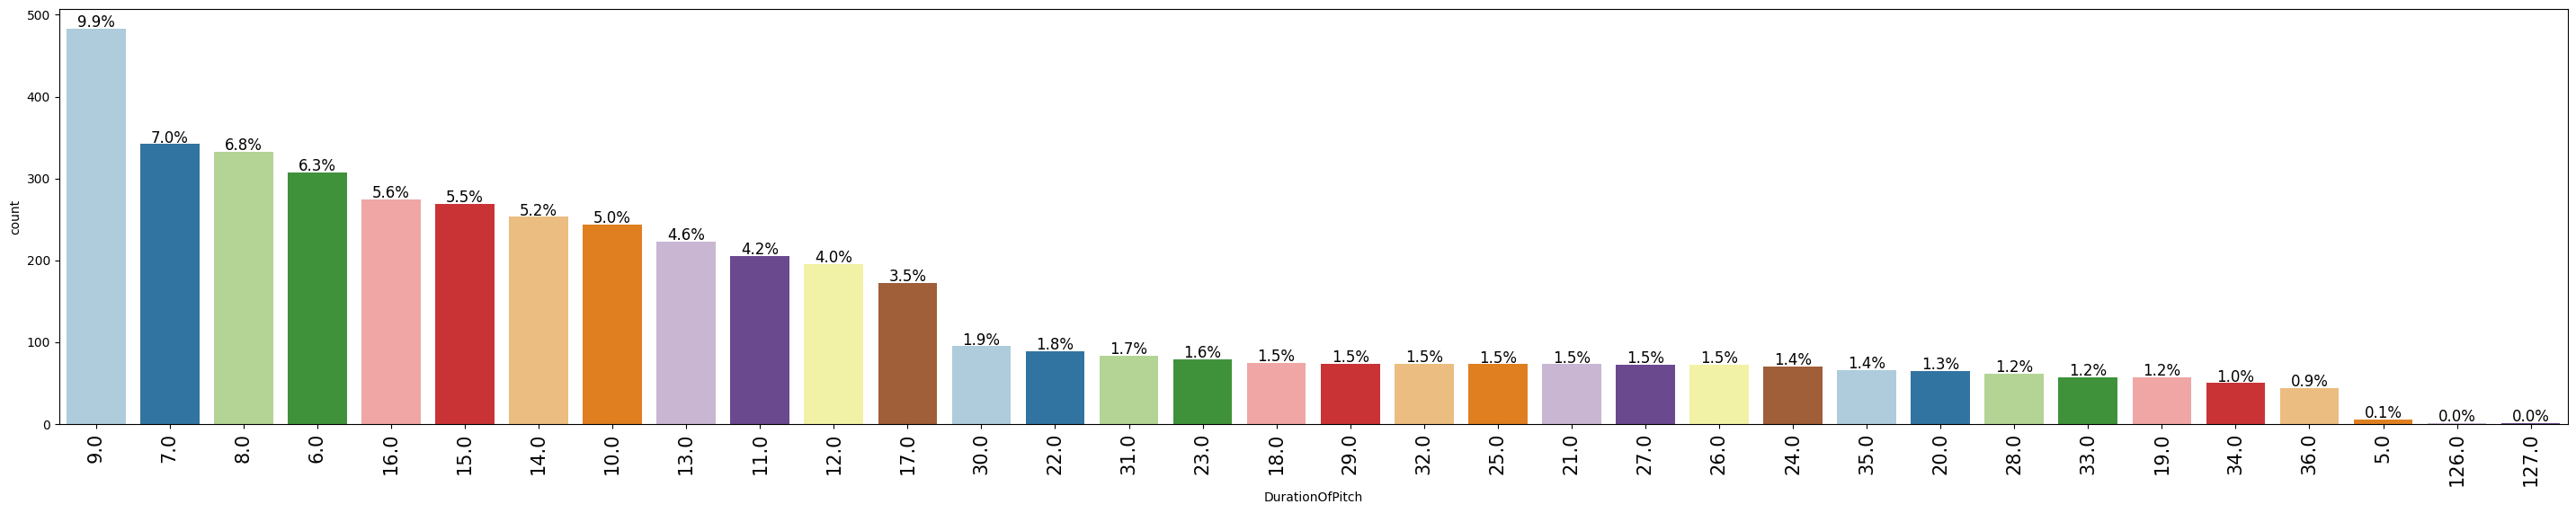

In [38]:
labeled_barplot(vu_Tourism,'DurationOfPitch',perc=True)

6 to 9 min pitches amount for 30% of all pitches
10 to 17 min pitches amount for 35% of all pitches


In [39]:
#There are outliers 126, and 127.
DOP_outliers_ceil = vu_Tourism[vu_Tourism['DurationOfPitch']>100]
DOP_outliers_ceil

ProdTaken   Age    TypeofContact  CityTier  DurationOfPitch Occupation  \
1434          0  37.0  Company Invited         3            126.0   Salaried   
3878          0  53.0  Company Invited         3            127.0   Salaried   

     Gender  NumberOfPersonVisiting  NumberOfFollowups ProductPitched  \
1434   Male                       2                3.0          Basic   
3878   Male                       3                4.0          Basic   

      PreferredPropertyStar MaritalStatus  NumberOfTrips  Passport  \
1434                    3.0       Married            3.0         0   
3878                    3.0       Married            4.0         0   

      PitchSatisfactionScore  OwnCar  NumberOfChildrenVisiting Designation  \
1434                       1       1                       1.0   Executive   
3878                       1       1                       2.0   Executive   

      MonthlyIncome  
1434        18482.0  
3878        22160.0

Notice that the outliers 126 and 127 have PitchSatisfactionScore = 1 (lowest), and ProdTaken = 0.  These customers had taken trips before.  We will keep the outliers but will not use them to consider null value imputation.

In [40]:
#There are outliers at 5
DOP_outliers_floor = vu_Tourism[vu_Tourism['DurationOfPitch']<6]
DOP_outliers_floor

ProdTaken   Age    TypeofContact  CityTier  DurationOfPitch  \
326           0  39.0  Company Invited         1              5.0   
1126          0  50.0     Self Enquiry         3              5.0   
1526          0  35.0  Company Invited         3              5.0   
1901          0  37.0     Self Enquiry         1              5.0   
2276          0  52.0     Self Enquiry         1              5.0   
2326          0  20.0     Self Enquiry         1              5.0   

          Occupation  Gender  NumberOfPersonVisiting  NumberOfFollowups  \
326   Small Business    Male                       2                4.0   
1126  Small Business    Male                       2                3.0   
1526        Salaried    Male                       3                3.0   
1901        Salaried  Female                       2                3.0   
2276        Salaried    Male                       2                3.0   
2326        Salaried    Male                       2                4.0   

     ProductPitched  PreferredPropertyStar MaritalStatus  NumberOfTrips  \
326            King                    3.0      Divorced            2.0   
1126           King                    3.0       Married            5.0   
1526       Standard                    5.0       Married            2.0   
1901         Deluxe                    3.0        Single            1.0   
2276       Standard                    4.0     Unmarried            1.0   
2326          Basic                    3.0        Single            2.0   

      Passport  PitchSatisfactionScore  OwnCar  NumberOfChildrenVisiting  \
326          0                       5       1                       1.0   
1126         1                       5       0                       1.0   
1526         0                       4       0                       0.0   
1901         0                       1       0                       0.0   
2276         0                       3       1                       1.0   
2326         0                       3       0                       0.0   

         Designation  MonthlyIncome  
326               VP        34272.0  
1126              VP        34331.0  
1526  Senior Manager        24069.0  
1901         Manager            NaN  
2276  Senior Manager        25445.0  
2326       Executive        18033.0

Notice that these short pitches produced 0 ProdTaken, the PitchSatisfactionScore was mixed. We will not consider these values for nullvalue imputation.

In [41]:
#drop rows that contain DurationOfPitch >100 or ==5
DOP_noOutlier_noNull = vu_Tourism[vu_Tourism.DurationOfPitch < 100]
DOP_noOutlier_noNull = DOP_noOutlier_noNull[DOP_noOutlier_noNull != 5]

In [42]:
#now we calculate mean, median, and mode for noNull and no Outliers
DOP_noOutlier_noNull_mean = DOP_noOutlier_noNull['DurationOfPitch'].mean()
DOP_noOutlier_noNull_median = DOP_noOutlier_noNull['DurationOfPitch'].median()
DOP_noOutlier_noNull_mode = DOP_noOutlier_noNull['DurationOfPitch'].mode()

print("DurationOfPitch no Outliers: \n")
print("mean   : ", math.ceil(DOP_noOutlier_noNull_mean))
print("median : ", DOP_noOutlier_noNull_median)
print("mode   : ", DOP_noOutlier_noNull_mode[0])

DurationOfPitch no Outliers: 

mean   :  16
median :  13.0
mode   :  9.0


The median has changed, the mean remained the same.
We will replace missing values for DurationOfPitch with the mean.

In [43]:
#Replace DurationOfPitch null values with the mean
vu_Tourism['DurationOfPitch'].fillna(value=DOP_noOutlier_noNull_mean, inplace=True)
print("DurationOfPitch has ",vu_Tourism['DurationOfPitch'].isnull().values.sum()," null entries")

print("DurationOfPitch Mean, Median, Mode: \n")
print("mean   : ", math.ceil(vu_Tourism['DurationOfPitch'].mean()))
print("median : ", math.ceil(vu_Tourism['DurationOfPitch'].median()))
DOP_mode = vu_Tourism['DurationOfPitch'].mode()

print("mode   : ", DOP_mode[0])

DurationOfPitch has  0  null entries
DurationOfPitch Mean, Median, Mode: 

mean   :  16
median :  14
mode   :  9.0


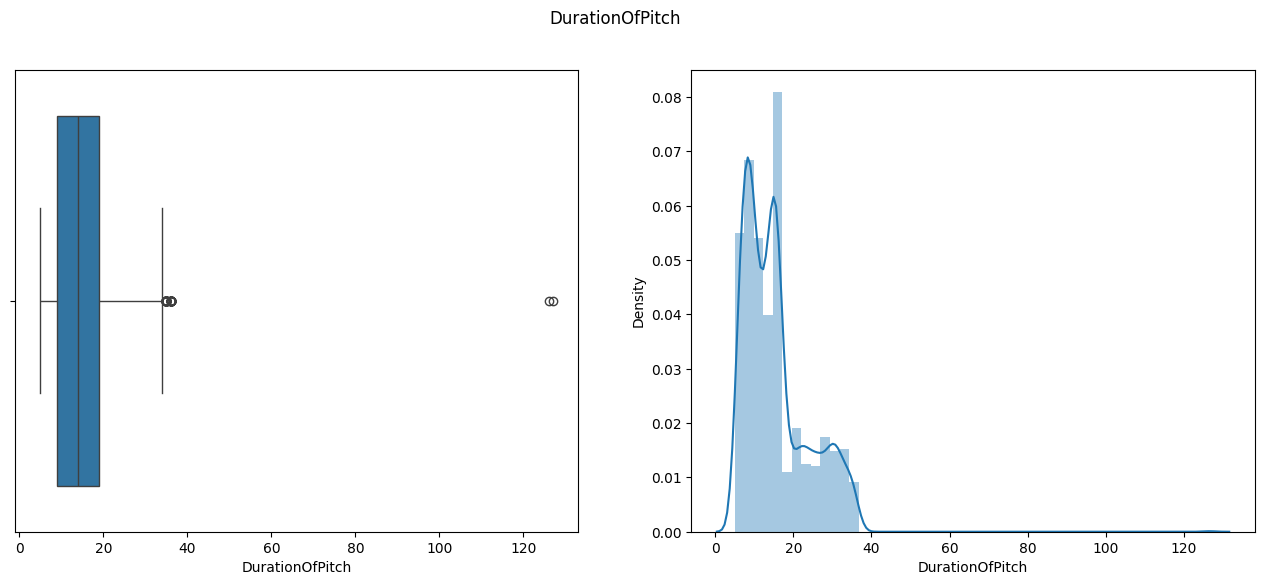

In [44]:
#Visualize Duration of Pitch after inputing null values
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
fig.suptitle('DurationOfPitch', fontsize=12)
sns.boxplot(data=vu_Tourism,x='DurationOfPitch', ax=ax1)
sns.distplot(vu_Tourism.DurationOfPitch,ax=ax2)
plt.show()

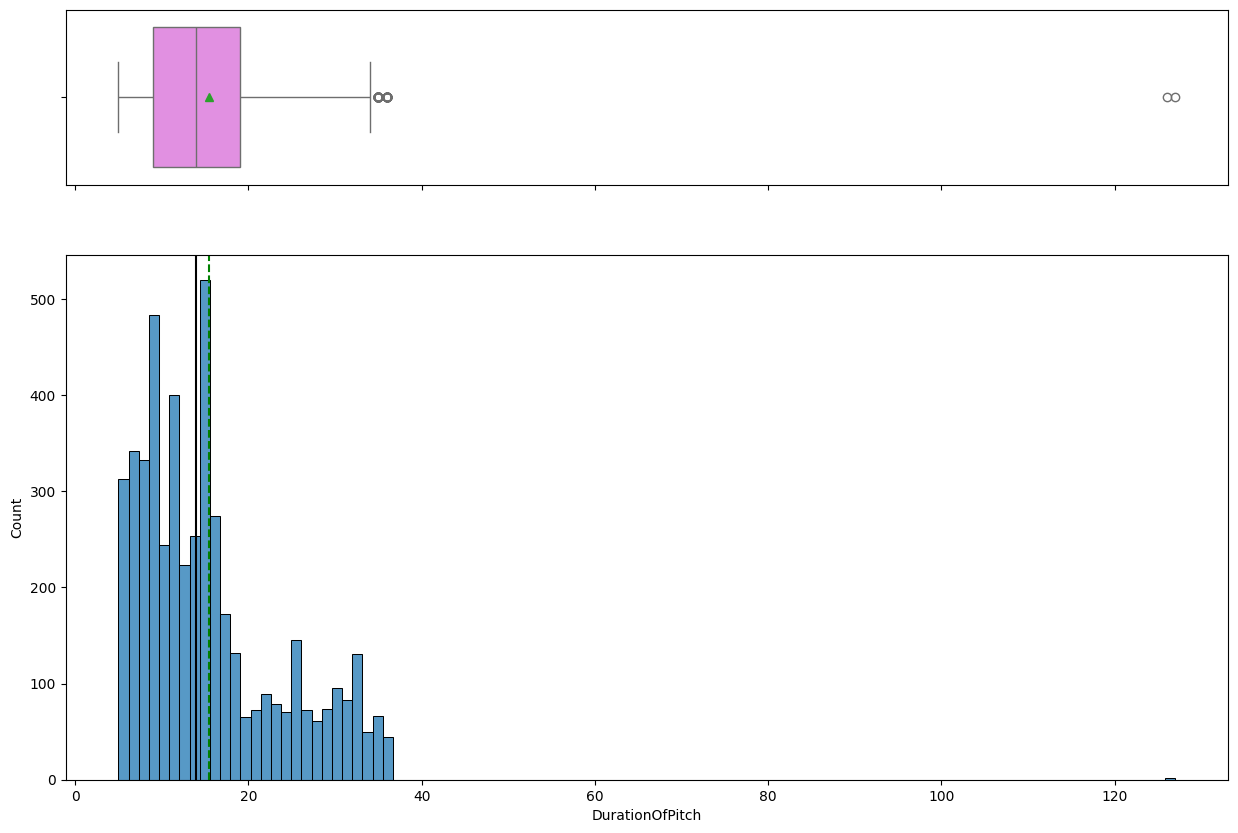

In [45]:
histogram_boxplot(vu_Tourism,'DurationOfPitch')

Notice that the distribution did not change.

#### **Feature NumberOfFollowups**

In [46]:
#Analyze Feature NumberOfFollowups including Null entries
print(vu_Tourism['NumberOfFollowups'].isnull().values.sum()," null NumberOfFollowups entries")
print(vu_Tourism.NumberOfFollowups.value_counts(),"\n")

45  null NumberOfFollowups entries
4.0    2068
3.0    1466
5.0     768
2.0     229
1.0     176
6.0     136
Name: NumberOfFollowups, dtype: int64 



There are 6 unique values for NumberOfFollowups and 45 null values. Lets look at the null NumberOfFollowups

How to handle Null values?
Lets look at mean, median, and mode.

In [47]:
#Calculate mean, median, mode for the NumberOfFollowups w/o null values

NOFu_mean = vu_Tourism['NumberOfFollowups'].mean()
NOFu_median = vu_Tourism['NumberOfFollowups'].median()
NOFu_mode = vu_Tourism['NumberOfFollowups'].mode()

print("NumberOfFollowups: \n")
print("mean   : ", math.ceil(NOFu_mean))
print("median : ", NOFu_median)

print("mode   : ", NOFu_mode[0])

NumberOfFollowups: 

mean   :  4
median :  4.0
mode   :  4.0


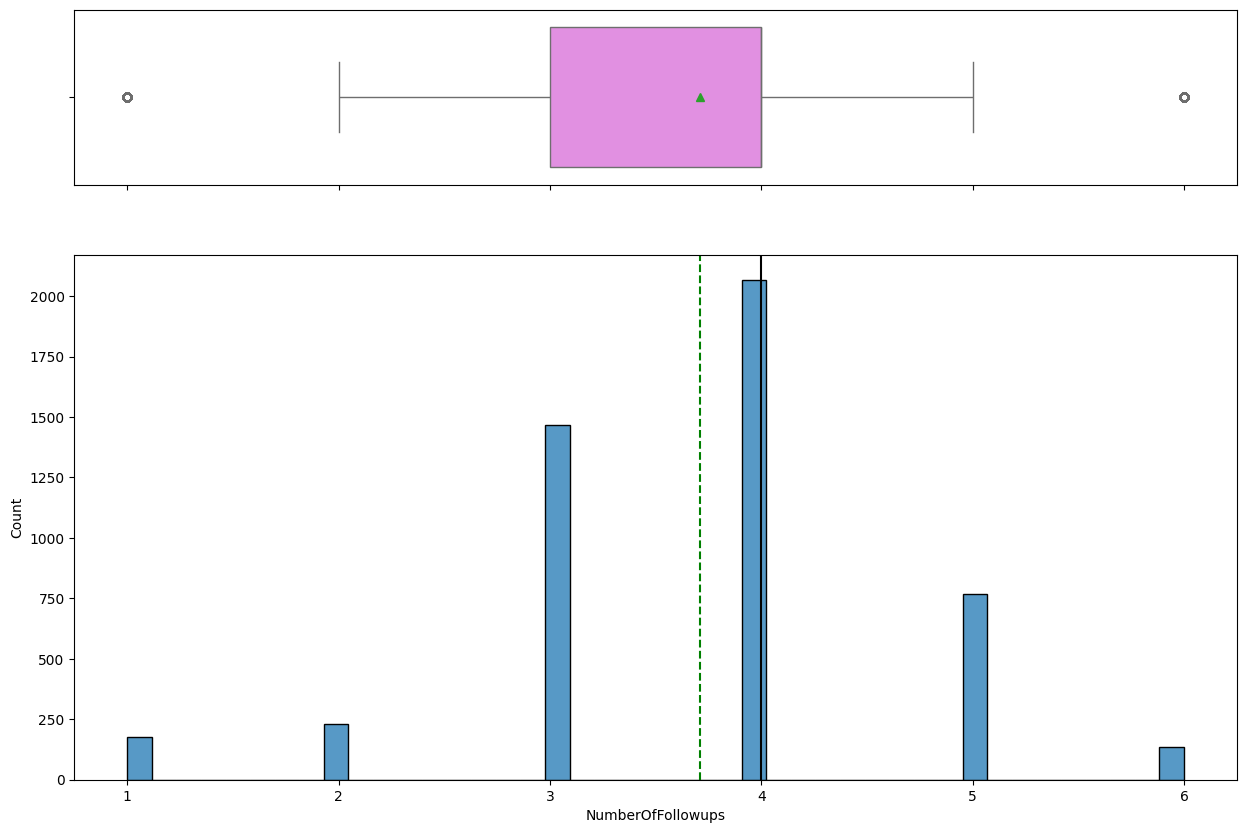

In [48]:
histogram_boxplot(vu_Tourism,'NumberOfFollowups')

Since the median, mean and mode is 4 we will complete missing values with this.

In [49]:
#Replace NumberOfFollowups null values with the mean
vu_Tourism['NumberOfFollowups'].fillna(value=NOFu_mean, inplace=True)
print("NumberOfFollowups has ",vu_Tourism['NumberOfFollowups'].isnull().values.sum()," null entries")

NumberOfFollowups has  0  null entries


#### **Feature Occupation**

In [50]:
#Analyze Feature Occupation including Null entries
print(vu_Tourism['Occupation'].isnull().values.sum()," null Occupation entries")
print(vu_Tourism.Occupation.value_counts(),"\n")

0  null Occupation entries
Salaried          2368
Small Business    2084
Large Business     434
Free Lancer          2
Name: Occupation, dtype: int64 



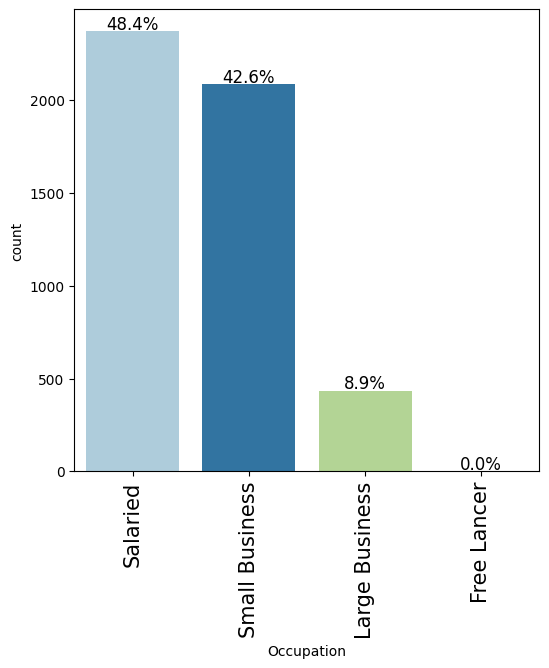

In [51]:
#General Distribution of Customers
labeled_barplot(vu_Tourism,'Occupation',perc=True)
plt.show()

There are no null values.

#### **Feature PreferredPropertyStar**

In [52]:
#Analyze Feature PreferredPropertyStar including Null entries
print(vu_Tourism['PreferredPropertyStar'].isnull().values.sum()," null PreferredPropertyStar entries")
print(vu_Tourism.PreferredPropertyStar.value_counts(),"\n")

26  null PreferredPropertyStar entries
3.0    2993
5.0     956
4.0     913
Name: PreferredPropertyStar, dtype: int64 



There are 26 null Preferred PropertyStar entries

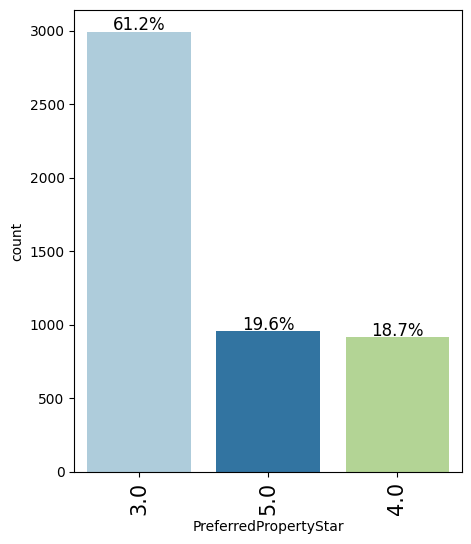

In [53]:
#lets see the distribution for PreferredPropertyStar w/ Null values
labeled_barplot(vu_Tourism,'PreferredPropertyStar',perc=True)

PreferredPropertyStar is an integer: 3, 4, or 5. Therefore, imputation w/ a mean or median wouldn't be helpful. Imputation is probably more useful with the mode.

Another consideration is that there are only 26 missing values, which is 0.5% of the total dataset.



In [54]:
#mode of PreferredPropertyStar
PPS_mode = vu_Tourism['PreferredPropertyStar'].mode()
PPS_mode = PPS_mode[0]
print("PreferredPropertyStar mode  : ",PPS_mode)

PreferredPropertyStar mode  :  3.0


In [55]:
#imputate mode into the missing values for PreferredPropertyStar
values = {"PreferredPropertyStar": PPS_mode}
vu_Tourism.fillna(value=values,inplace=True)

In [56]:
#Analyze Feature PreferredPropertyStar including Null entries
print(vu_Tourism['PreferredPropertyStar'].isnull().values.sum()," null PreferredPropertyStar entries")
print(vu_Tourism.PreferredPropertyStar.value_counts(),"\n")

0  null PreferredPropertyStar entries
3.0    3019
5.0     956
4.0     913
Name: PreferredPropertyStar, dtype: int64 



#### **Feature NumberOfTrips**

In [57]:
#Analyze Feature NumberOfTrips including Null entries
print(vu_Tourism['NumberOfTrips'].isnull().values.sum()," null NumberOfTrips entries")
print(vu_Tourism.NumberOfTrips.value_counts(),"\n")

140  null NumberOfTrips entries
2.0     1464
3.0     1079
1.0      620
4.0      478
5.0      458
6.0      322
7.0      218
8.0      105
19.0       1
21.0       1
20.0       1
22.0       1
Name: NumberOfTrips, dtype: int64 



In [58]:
print("NumberOfTrips median, mean, mode without Null Values")
print("NumberOfTrips median: ",vu_Tourism['NumberOfTrips'].median())
print("NumberOfTrips  : ",vu_Tourism['NumberOfTrips'].mean())
NOT_mode = vu_Tourism['NumberOfTrips'].mode()
print("NumberOfTrips  : ",NOT_mode[0])

NumberOfTrips median, mean, mode without Null Values
NumberOfTrips median:  3.0
NumberOfTrips  :  3.236520640269587
NumberOfTrips  :  2.0


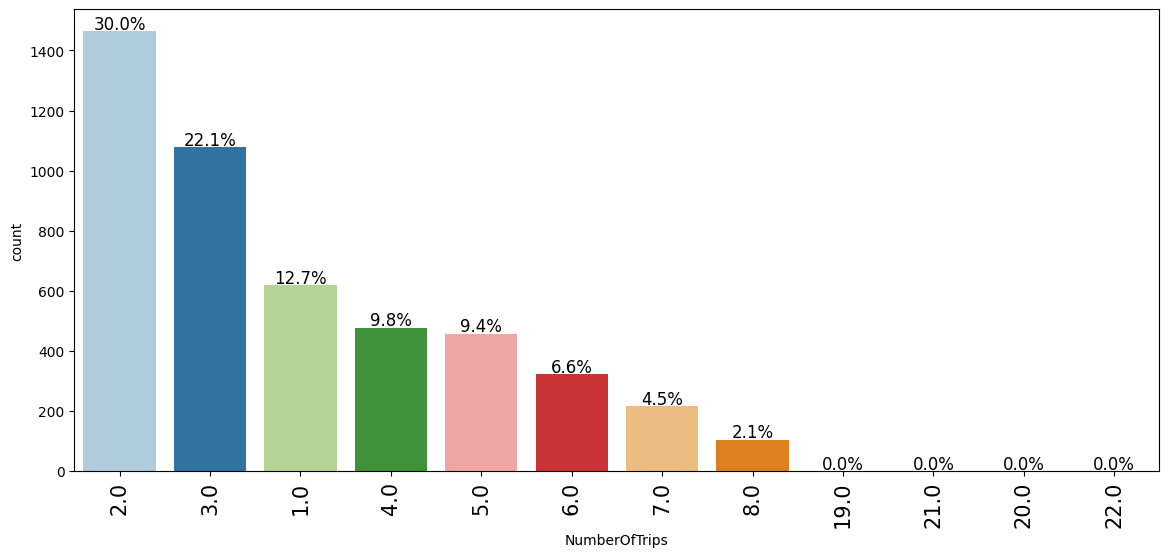

In [59]:
#NumberOfTrips distribution
labeled_barplot(vu_Tourism,'NumberOfTrips',perc=True)

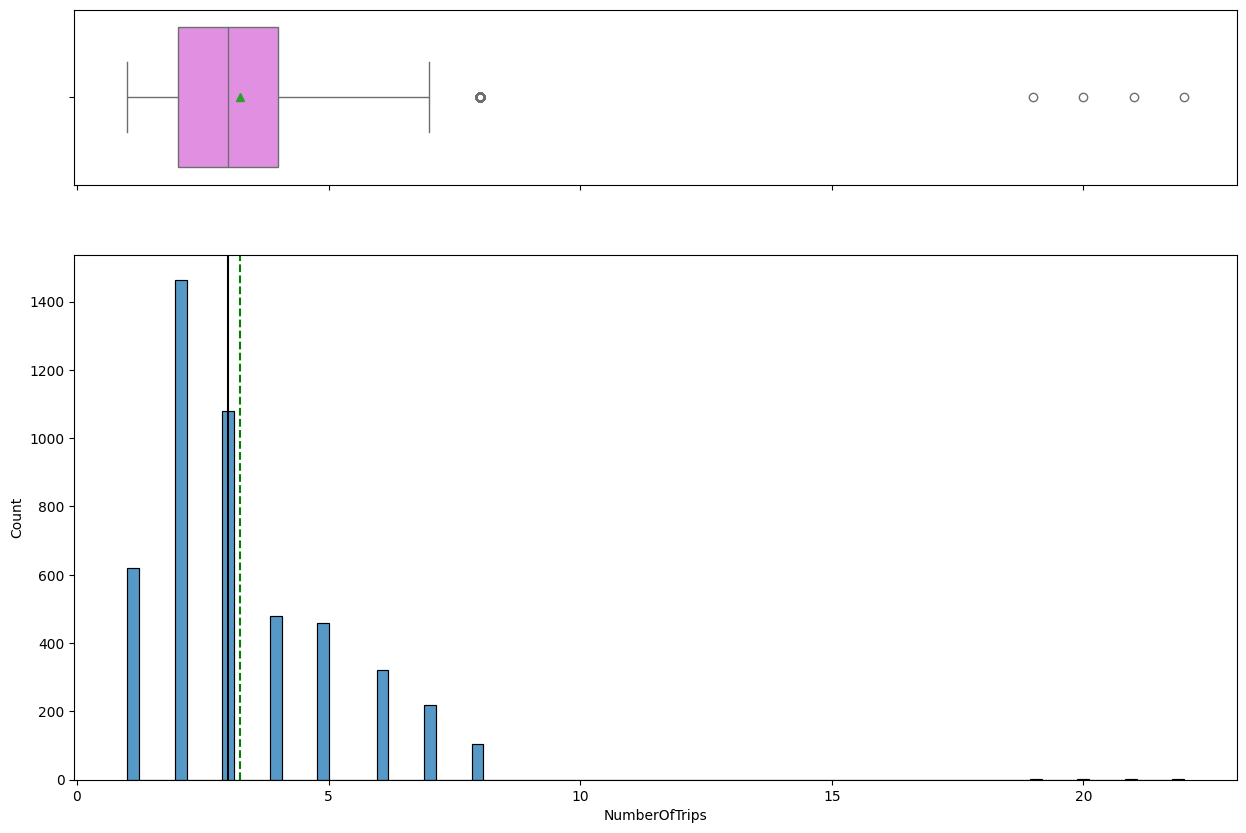

In [60]:
histogram_boxplot(vu_Tourism,'NumberOfTrips')

30% of customers have taken 2 Trips, and 22% have taken 3 trips. Notice the outliers, on customers that took more more than 7 trips. However, this may be possible. There may be customers that always would take a lot of trips. Lets address the missing values in the bivariate analysis.

#### **Feature NumberOfChildrenVisiting**

In [61]:
#Analyze Feature NumberOfChildrenVisiting including Null entries
print(vu_Tourism['NumberOfChildrenVisiting'].isnull().values.sum()," null NumberOfChildrenVisiting entries")
print(vu_Tourism.NumberOfChildrenVisiting.value_counts(),"\n")

66  null NumberOfChildrenVisiting entries
1.0    2080
2.0    1335
0.0    1082
3.0     325
Name: NumberOfChildrenVisiting, dtype: int64 



There are 66 null values.

In [62]:
print("NumberOfChildrenVisiting median, mean, mode without Null Values")
print("NumberOfChildrenVisiting median: ",vu_Tourism['NumberOfChildrenVisiting'].median())
print("NumberOfChildrenVisiting mean : ",round(vu_Tourism['NumberOfChildrenVisiting'].mean(),1))
NOCV_mode = vu_Tourism['NumberOfChildrenVisiting'].mode()
print("NumberOfChildrenVisiting  : ",NOCV_mode[0])

NumberOfChildrenVisiting median, mean, mode without Null Values
NumberOfChildrenVisiting median:  1.0
NumberOfChildrenVisiting mean :  1.2
NumberOfChildrenVisiting  :  1.0


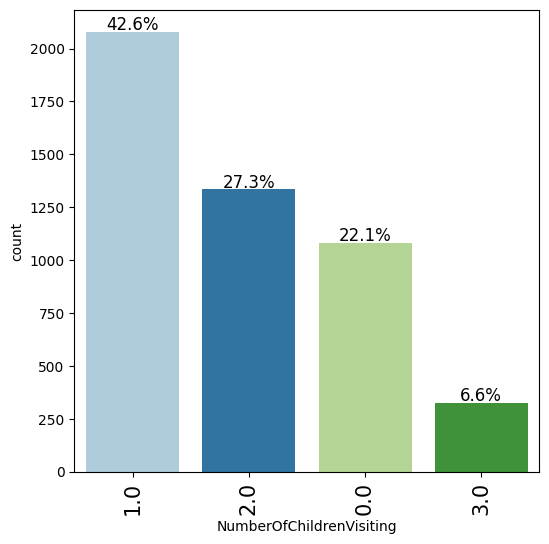

In [63]:
#Distribution of NumberOfChildrenVisiting
labeled_barplot(vu_Tourism,'NumberOfChildrenVisiting',perc=True)

Lets imputate the missing values with the mode, which is 1.

In [64]:
#imputate mode into the missing values for NumberOfChildrenVisiting
NOCV_mode = 1
values = {"NumberOfChildrenVisiting": NOCV_mode}
vu_Tourism.fillna(value=values,inplace=True)

In [65]:
print(vu_Tourism['NumberOfChildrenVisiting'].isnull().values.sum()," null NumberOfChildrenVisiting entries")
print(vu_Tourism.NumberOfChildrenVisiting.value_counts(),"\n")

0  null NumberOfChildrenVisiting entries
1.0    2146
2.0    1335
0.0    1082
3.0     325
Name: NumberOfChildrenVisiting, dtype: int64 



#### **Feature MaritalStatus**

In [66]:
#Analyze MaritalStatus including Null entries
print(vu_Tourism['MaritalStatus'].isnull().values.sum()," null MaritalStatus entries")
print(vu_Tourism.MaritalStatus.value_counts(),"\n")

0  null MaritalStatus entries
Married      2340
Divorced      950
Single        916
Unmarried     682
Name: MaritalStatus, dtype: int64 



There are no null values

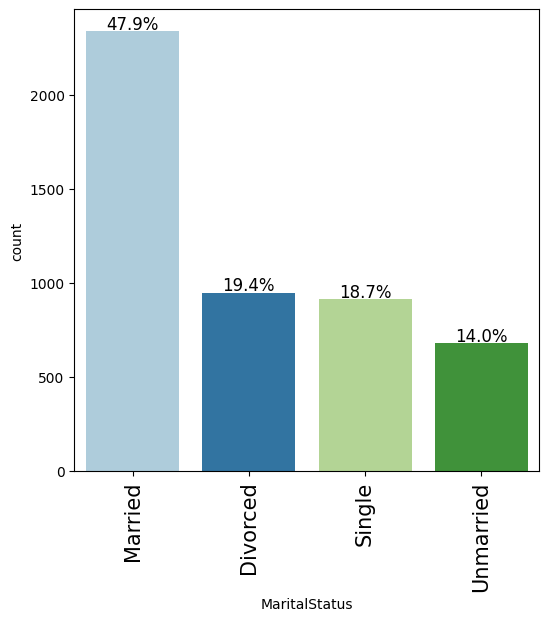

In [67]:
labeled_barplot(vu_Tourism,'MaritalStatus',perc=True)

Notice that 48% of customers are married.

#### **Feature Passport**

In [68]:
#Analyze Passport including Null entries
print(vu_Tourism['Passport'].isnull().values.sum()," null Passport entries")
print(vu_Tourism.Passport.value_counts(),"\n")

0  null Passport entries
0    3466
1    1422
Name: Passport, dtype: int64 



There are no null values

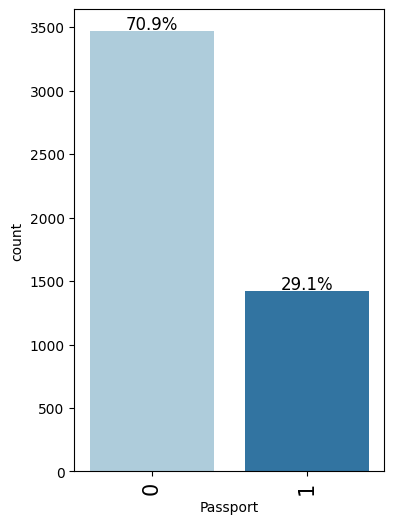

In [69]:
labeled_barplot(vu_Tourism,'Passport',perc=True)

80% of customers do not have a passport.

#### **Feature PitchSatisfactionScore**

In [70]:
#Analyze PitchSatisfactionScore including Null entries
print(vu_Tourism['PitchSatisfactionScore'].isnull().values.sum()," null PitchSatisfactionScore entries")
print(vu_Tourism.PitchSatisfactionScore.value_counts(),"\n")

0  null PitchSatisfactionScore entries
3    1478
5     970
1     942
4     912
2     586
Name: PitchSatisfactionScore, dtype: int64 



There are no null values

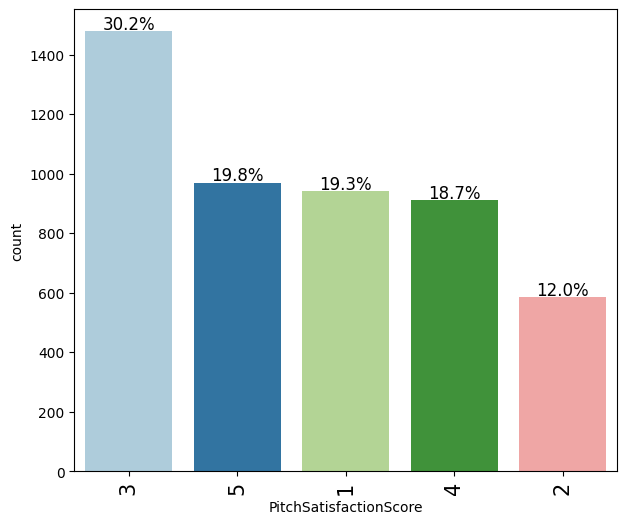

In [71]:
labeled_barplot(vu_Tourism,"PitchSatisfactionScore",perc=True)

30% of customers gave a 3point score to the selling Pitch.


####**Feature OwnCar**

In [72]:
#Analyze OwnCar including Null entries
print(vu_Tourism['OwnCar'].isnull().values.sum()," null OwnCar entries")
print(vu_Tourism.OwnCar.value_counts(),"\n")

0  null OwnCar entries
1    3032
0    1856
Name: OwnCar, dtype: int64 



There are no null values

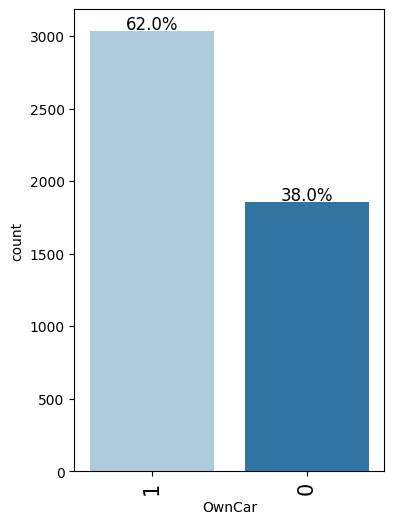

In [73]:
labeled_barplot(vu_Tourism,"OwnCar",perc=True)

62% of customers own a car

####**Feature City Tier**

In [74]:
#Analyze CityTier including Null entries
print(vu_Tourism['CityTier'].isnull().values.sum()," null CityTier entries")
print(vu_Tourism.CityTier.value_counts(),"\n")

0  null CityTier entries
1    3190
3    1500
2     198
Name: CityTier, dtype: int64 



There are no null values

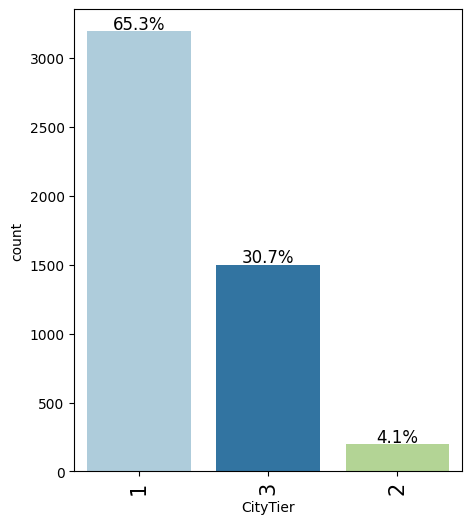

In [75]:
labeled_barplot(vu_Tourism,"CityTier",perc=True)

65% of customers live in the lowest Tier (Tier 1), and surprisingly 31% live in the highest Tier (Tier 3).

####**Feature MonthlyIncome**

In [76]:
#Analyze MonthlyIncome including Null entries
print(vu_Tourism['MonthlyIncome'].isnull().values.sum()," null MonthlyIncome entries")
print(vu_Tourism.MonthlyIncome.value_counts(),"\n")

233  null MonthlyIncome entries
20855.0    7
21288.0    7
17342.0    7
21020.0    7
24950.0    6
          ..
17074.0    1
24250.0    1
21077.0    1
24714.0    1
21471.0    1
Name: MonthlyIncome, Length: 2475, dtype: int64 



There are 233 null values.

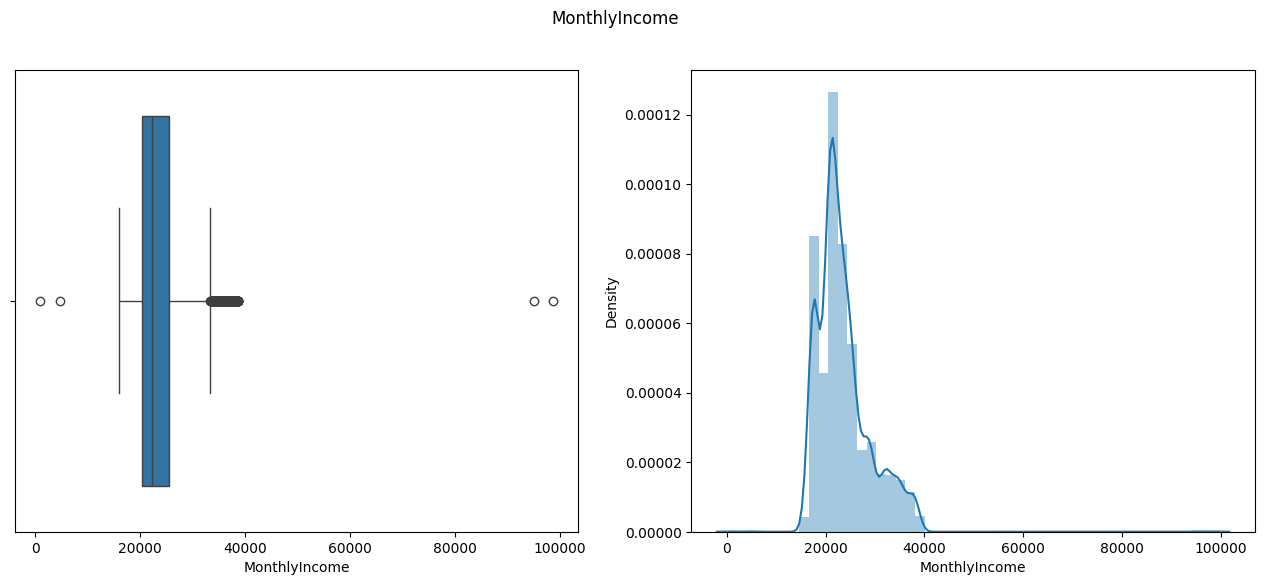

In [77]:
#Visualize MonthlyIncome Distribution
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
fig.suptitle('MonthlyIncome', fontsize=12)
sns.boxplot(data=vu_Tourism,x='MonthlyIncome', ax=ax1)
sns.distplot(vu_Tourism.MonthlyIncome,ax=ax2)
plt.show()

Salary has outliers. How to treat these? Salaries will always have outliers.
However, we should be careful to input Null salaries with the mean of those salaries.

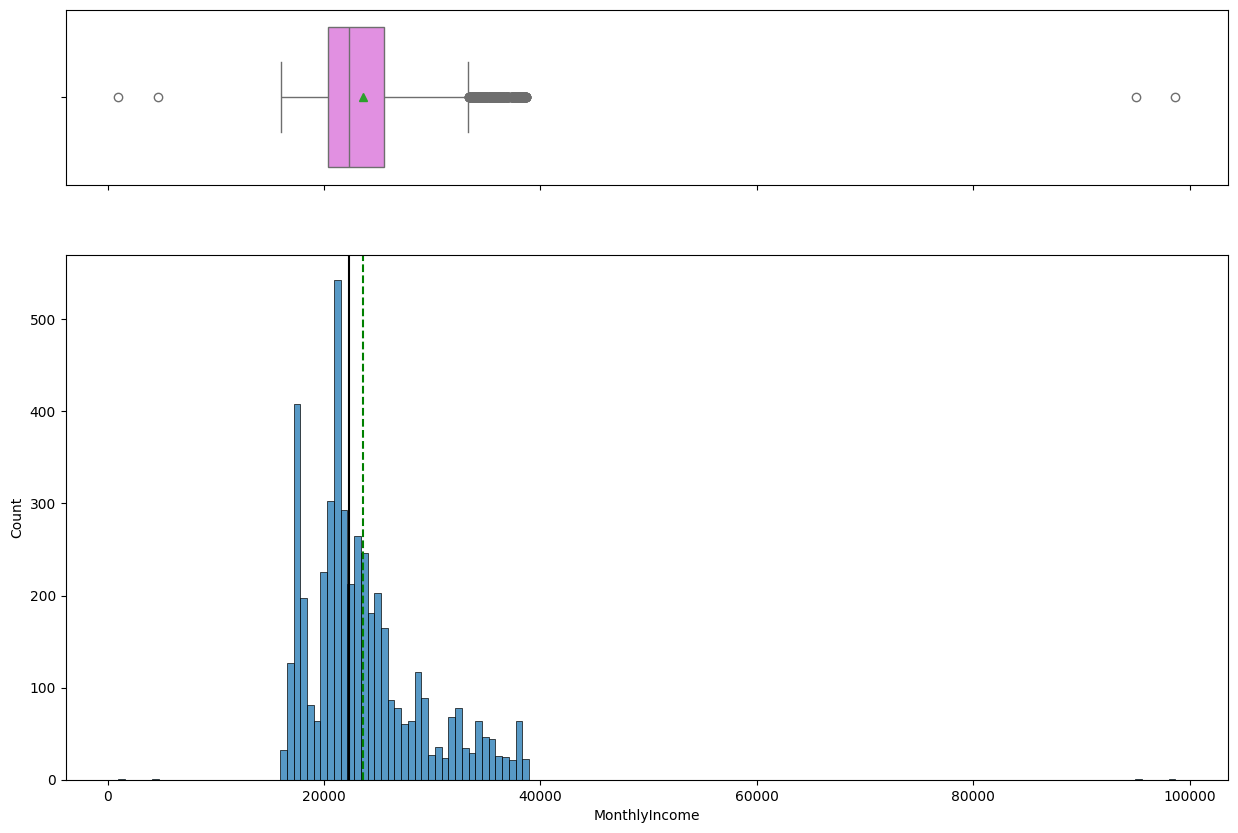

In [78]:
histogram_boxplot(vu_Tourism,'MonthlyIncome')

In [79]:
#The largest MonthlyIncome
vu_Tourism['MonthlyIncome'].nlargest()

2482    98678.0
38      95000.0
2634    38677.0
4104    38677.0
3190    38651.0
Name: MonthlyIncome, dtype: float64

In [80]:
#smallest MonthlyIncome
vu_Tourism['MonthlyIncome'].nsmallest()

142      1000.0
2586     4678.0
513     16009.0
1983    16009.0
727     16051.0
Name: MonthlyIncome, dtype: float64

We will not consider the values higher than 40K and lower than 15K to calculate our MonthlyIncome mean.

In [81]:
MI_noOutliers = vu_Tourism[(vu_Tourism['MonthlyIncome']>15000) & (vu_Tourism['MonthlyIncome'] < 40000)]
MI_noOutliers_mean = round(MI_noOutliers['MonthlyIncome'].mean(),0)
print("The MonthlyIncome mean w/o Outliers is ",MI_noOutliers_mean)

The MonthlyIncome mean w/o Outliers is  23597.0


Now lets input the mean into the missing values

In [82]:
values = {"MonthlyIncome": MI_noOutliers_mean}
vu_Tourism.fillna(value=values,inplace=True)

Unknown currency but it certainly couldn't be US Dollars, British Pounds, Canadian Dollars, Australian Dollars, or Euros because these are Monthly Salaries.

In [83]:
print(vu_Tourism['MonthlyIncome'].isnull().values.sum()," null MonthlyIncome entries")
print(vu_Tourism.MonthlyIncome.value_counts(),"\n")

0  null MonthlyIncome entries
23597.0    233
20855.0      7
21020.0      7
21288.0      7
17342.0      7
          ... 
17074.0      1
24250.0      1
21077.0      1
24714.0      1
21471.0      1
Name: MonthlyIncome, Length: 2476, dtype: int64 



#### **Feature Designation**

In [84]:
#Analyze Designation including Null entries
print(vu_Tourism['Designation'].isnull().values.sum()," null Designation entries")
print(vu_Tourism.Designation.value_counts(),"\n")

0  null Designation entries
Executive         1842
Manager           1732
Senior Manager     742
AVP                342
VP                 230
Name: Designation, dtype: int64 



There are no null values

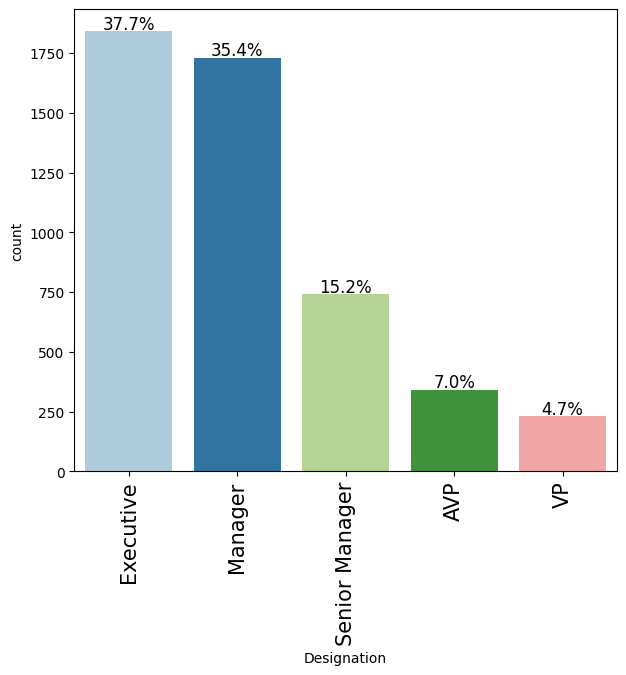

In [85]:
labeled_barplot(vu_Tourism,"Designation",perc=True)

#### **ProductPitched**

In [86]:
#Analyze ProductPitched including Null entries
print(vu_Tourism['ProductPitched'].isnull().values.sum()," null ProductPitchedentries")
print(vu_Tourism.ProductPitched.value_counts(),"\n")

0  null ProductPitchedentries
Basic           1842
Deluxe          1732
Standard         742
Super Deluxe     342
King             230
Name: ProductPitched, dtype: int64 



There are no null values

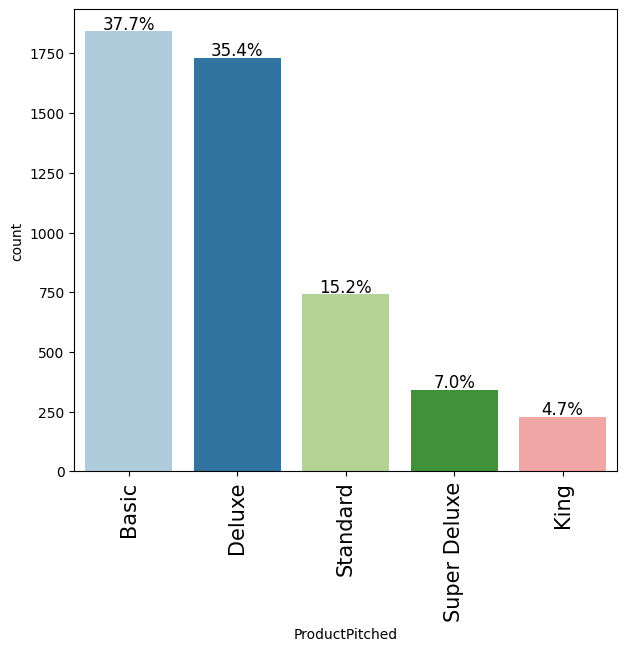

In [87]:
labeled_barplot(vu_Tourism,"ProductPitched",perc=True)

The Basic product is 38% and Deluxe is 35% of all products pitched.

### **Bivariate Analysis**

####**Correlation Check**

In [88]:
#lets look at the correlation between features
print(vu_Tourism.corr())

                          ProdTaken       Age  CityTier  DurationOfPitch  \
ProdTaken                  1.000000 -0.143755  0.086852         0.076302   
Age                       -0.143755  1.000000 -0.014352        -0.011178   
CityTier                   0.086852 -0.014352  1.000000         0.021985   
DurationOfPitch            0.076302 -0.011178  0.021985         1.000000   
NumberOfPersonVisiting     0.009627  0.013817 -0.001671         0.063448   
NumberOfFollowups          0.111675 -0.000778  0.023524         0.009291   
PreferredPropertyStar      0.098704 -0.015734 -0.008479        -0.005915   
NumberOfTrips              0.018898  0.181294 -0.029709         0.009637   
Passport                   0.260844  0.032529  0.001793         0.032264   
PitchSatisfactionScore     0.051394  0.017803 -0.042160        -0.002806   
OwnCar                    -0.011508  0.047468  0.003817        -0.001598   
NumberOfChildrenVisiting   0.008009  0.005279  0.000578         0.030568   
MonthlyIncom

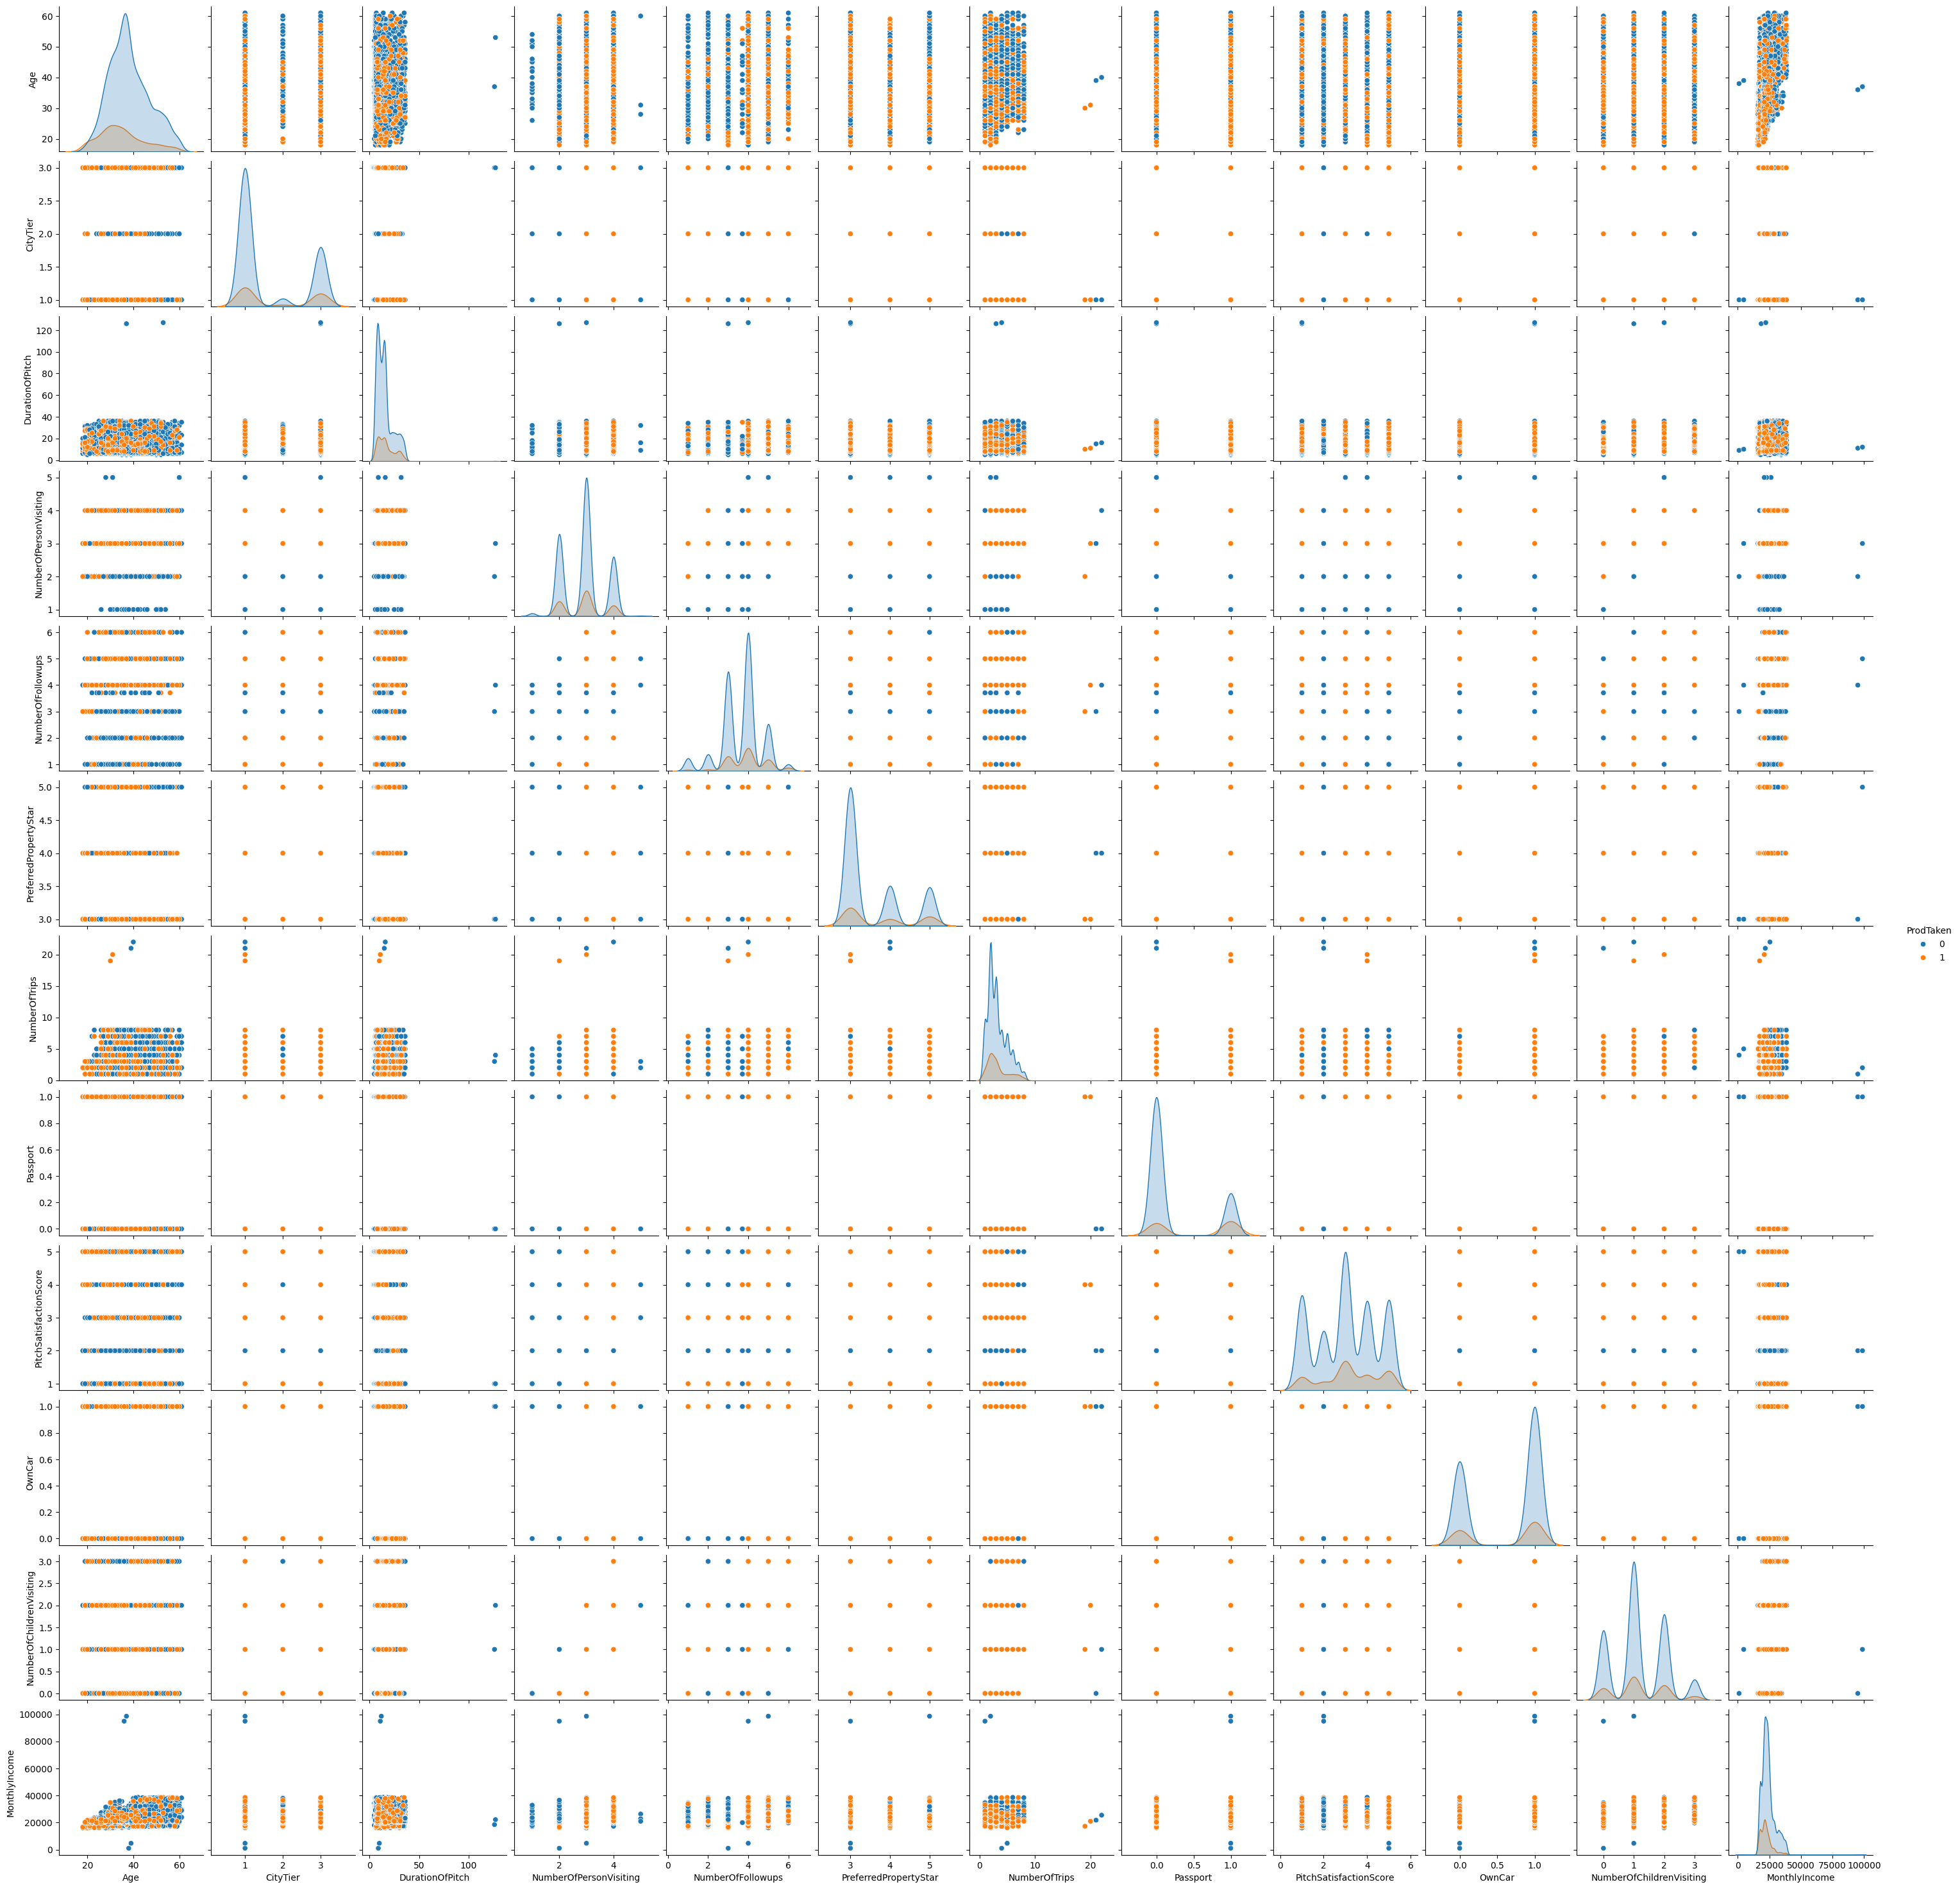

In [89]:
sns.pairplot(vu_Tourism,hue='ProdTaken')
plt.show()

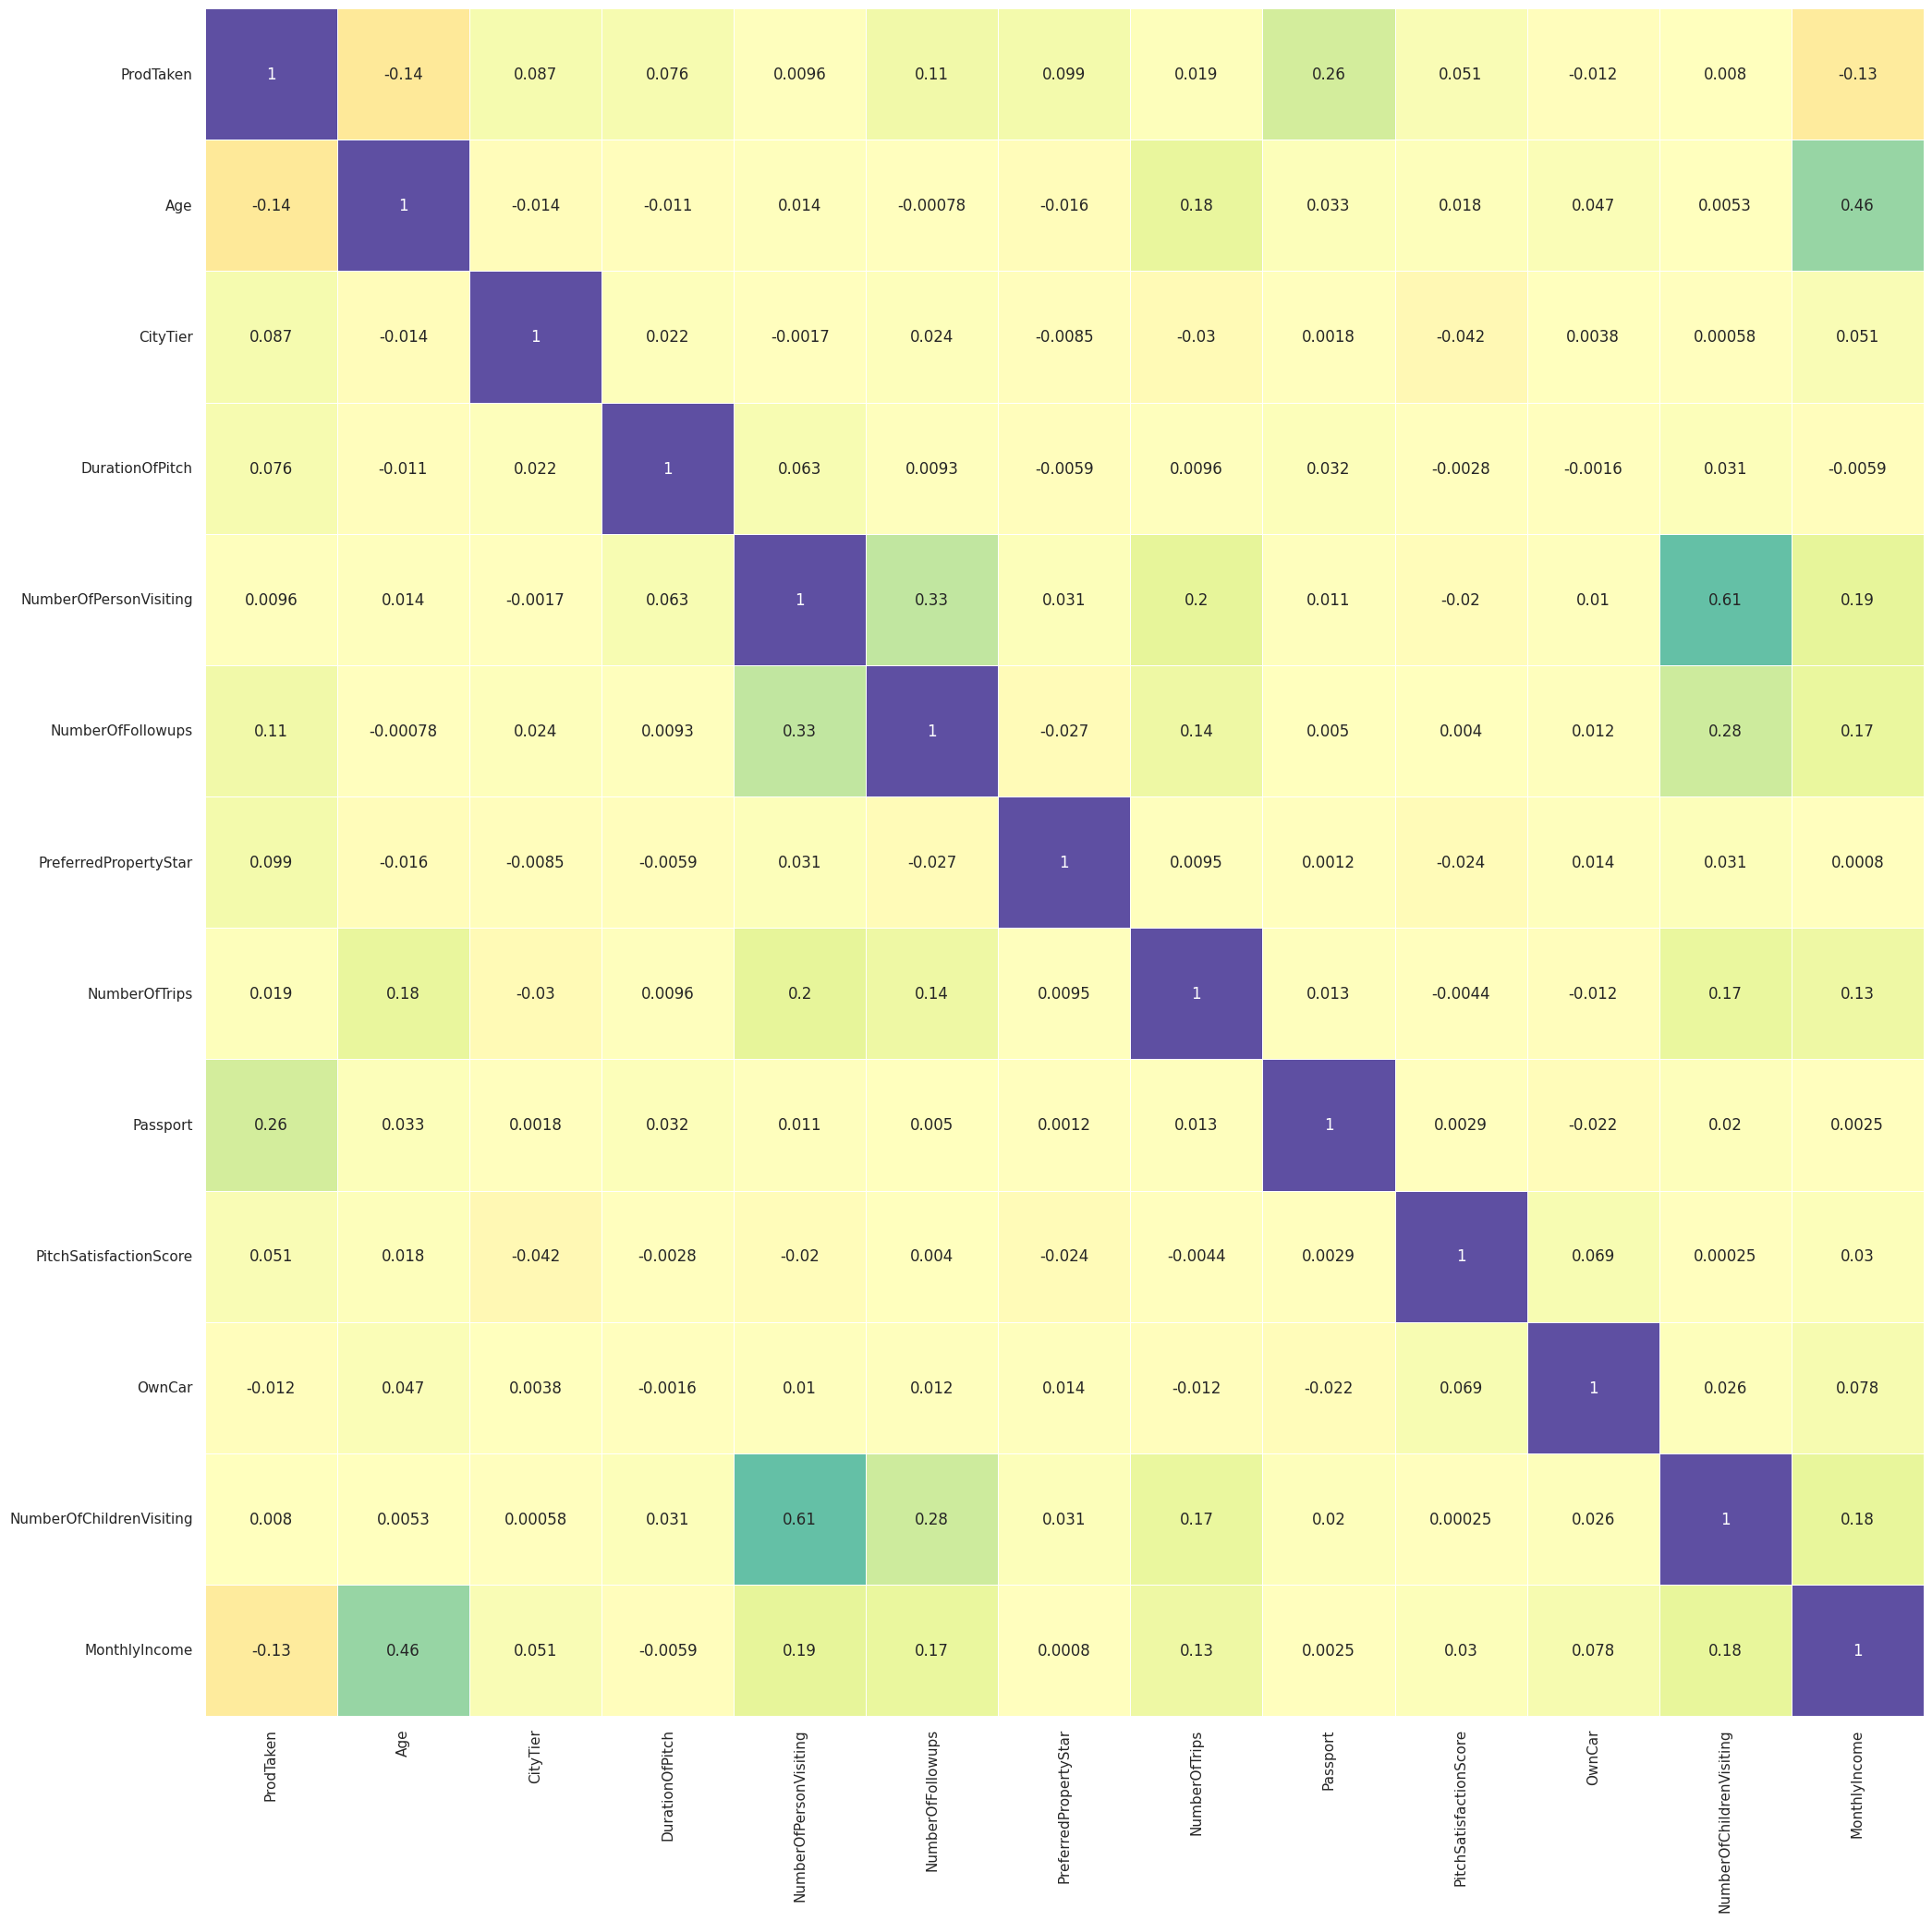

In [90]:
sns.set(rc={'figure.figsize':(24,24)})
sns.heatmap(vu_Tourism.corr(), annot=True, linewidths=.5, center=0, cbar=False, cmap="Spectral")
plt.show()

Higher Correlation
- ProdTaken-Passport
- ProdTaken-Senior Manager
- ProdTaken-Executive
Lower Correlation
- ProdTaken-Age
- ProdTaken-NumberOfFollowups

####**Contuining Imputation of Null Values**

#####**NumberOfTrips**

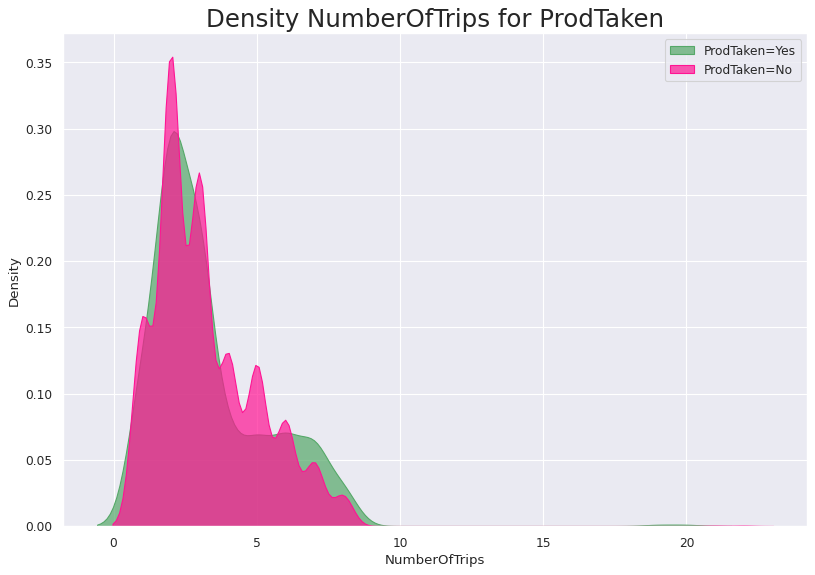

In [91]:
#Lets see NumberOfTrips vs ProdTaken (Yes and No)
plt.figure(figsize=(12,8), dpi= 80)
sns.kdeplot(vu_Tourism.loc[vu_Tourism['ProdTaken'] == 1, "NumberOfTrips"], shade=True, color="g", label="ProdTaken=Yes", alpha=.7)
sns.kdeplot(vu_Tourism.loc[vu_Tourism['ProdTaken'] == 0, "NumberOfTrips"], shade=True, color="deeppink", label="ProdTaken=No", alpha=.7)
plt.title('Density NumberOfTrips for ProdTaken', fontsize=22)
plt.legend()
plt.show()

We can see that for both cases of ProdTaken Yes and ProdTaken No, the distribution is similar.
Notice that there are outliers.

From the correlation plot we noticed that NumberOfTrips has a weak correlation with:
- Age
- NumberOfChildrenVisiting
- NumberOfPersonVisiting
- MonthlyIncome
- NumberOfFollowups

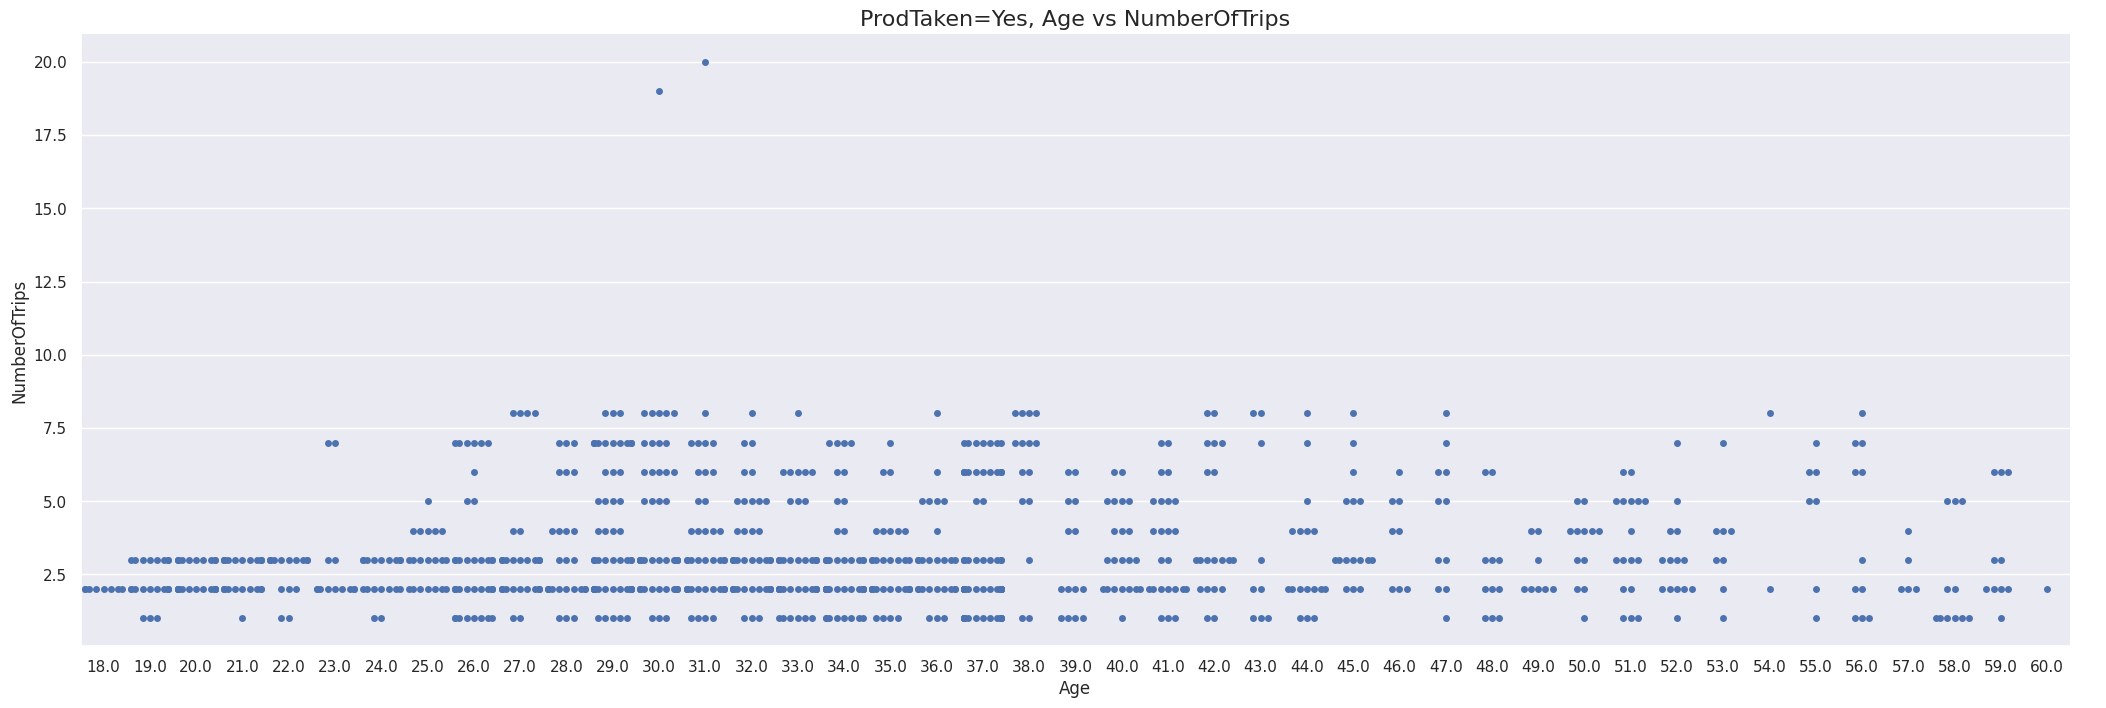

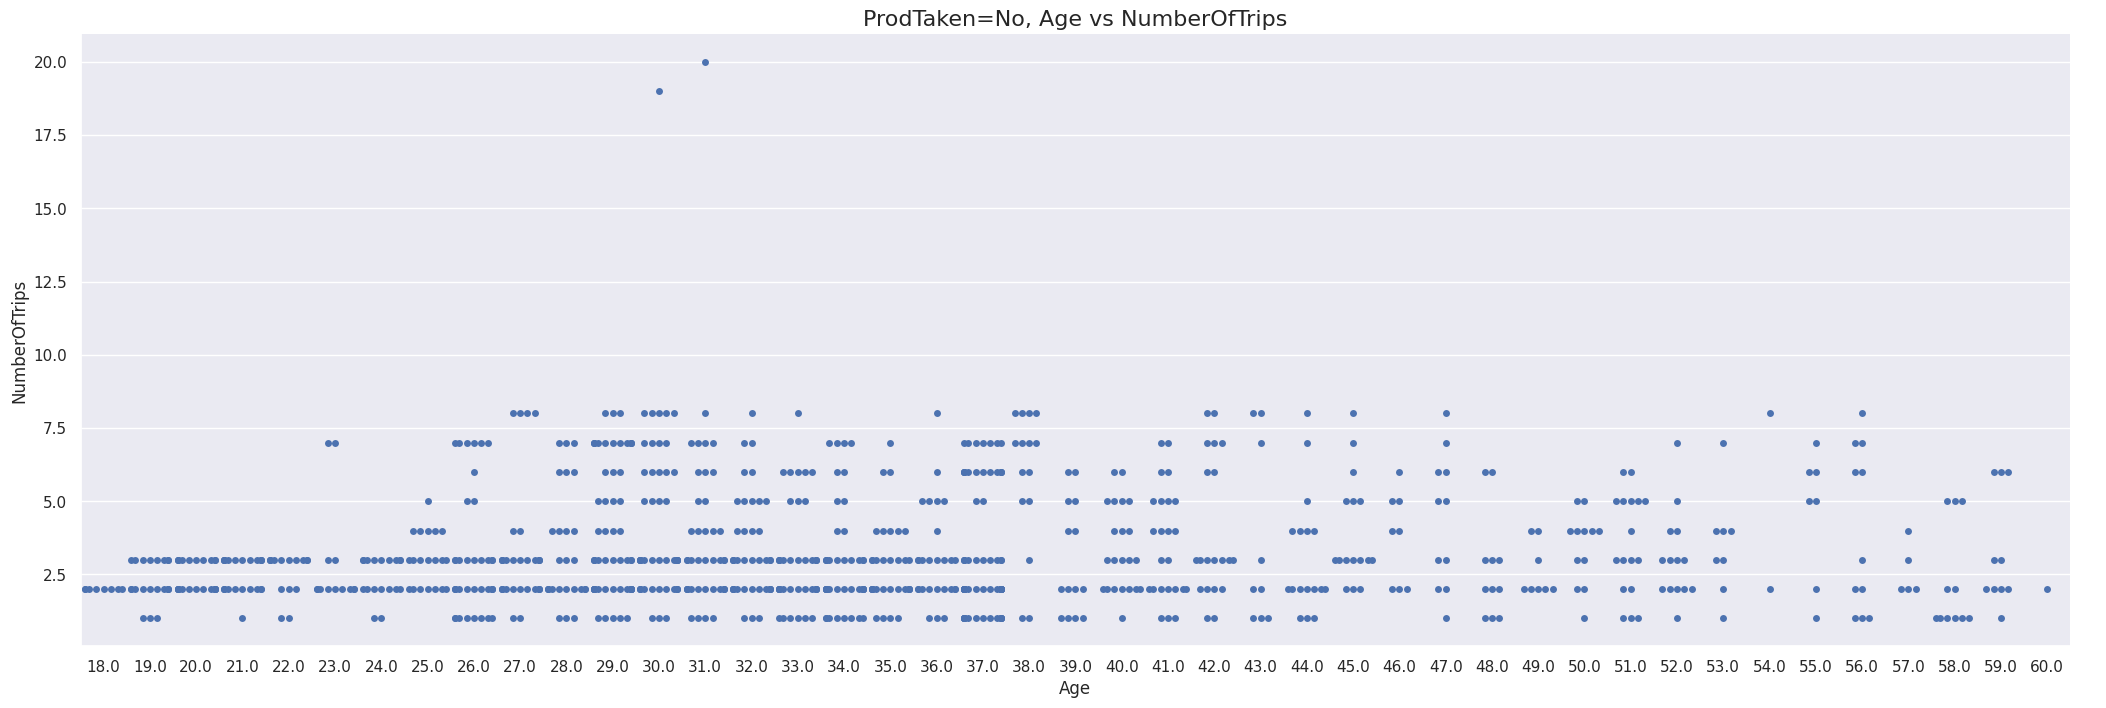

In [92]:
#Lets look at ProdTaken=Yes, NumberOfTrips, and Age

PT_yes = vu_Tourism[vu_Tourism['ProdTaken']==1]
PT_no = vu_Tourism[vu_Tourism['ProdTaken']==0]

#Lets see NumberOfTrips vs ProdTaken (Yes and No)
sns.set(rc={'figure.figsize':(18,7)})
sns.catplot(x="Age", y="NumberOfTrips", kind="swarm", data=PT_yes, height=7, aspect=3);
plt.title("ProdTaken=Yes, Age vs NumberOfTrips", fontsize=16)

sns.set(rc={'figure.figsize':(18,7)})
sns.catplot(x="Age", y="NumberOfTrips", kind="swarm", data=PT_yes, height=7, aspect=3);
plt.title("ProdTaken=No, Age vs NumberOfTrips", fontsize=16)

plt.show()

It seems like there is an even symmetrical distribution age vs NumberOfTrips w/o considering the outliers.

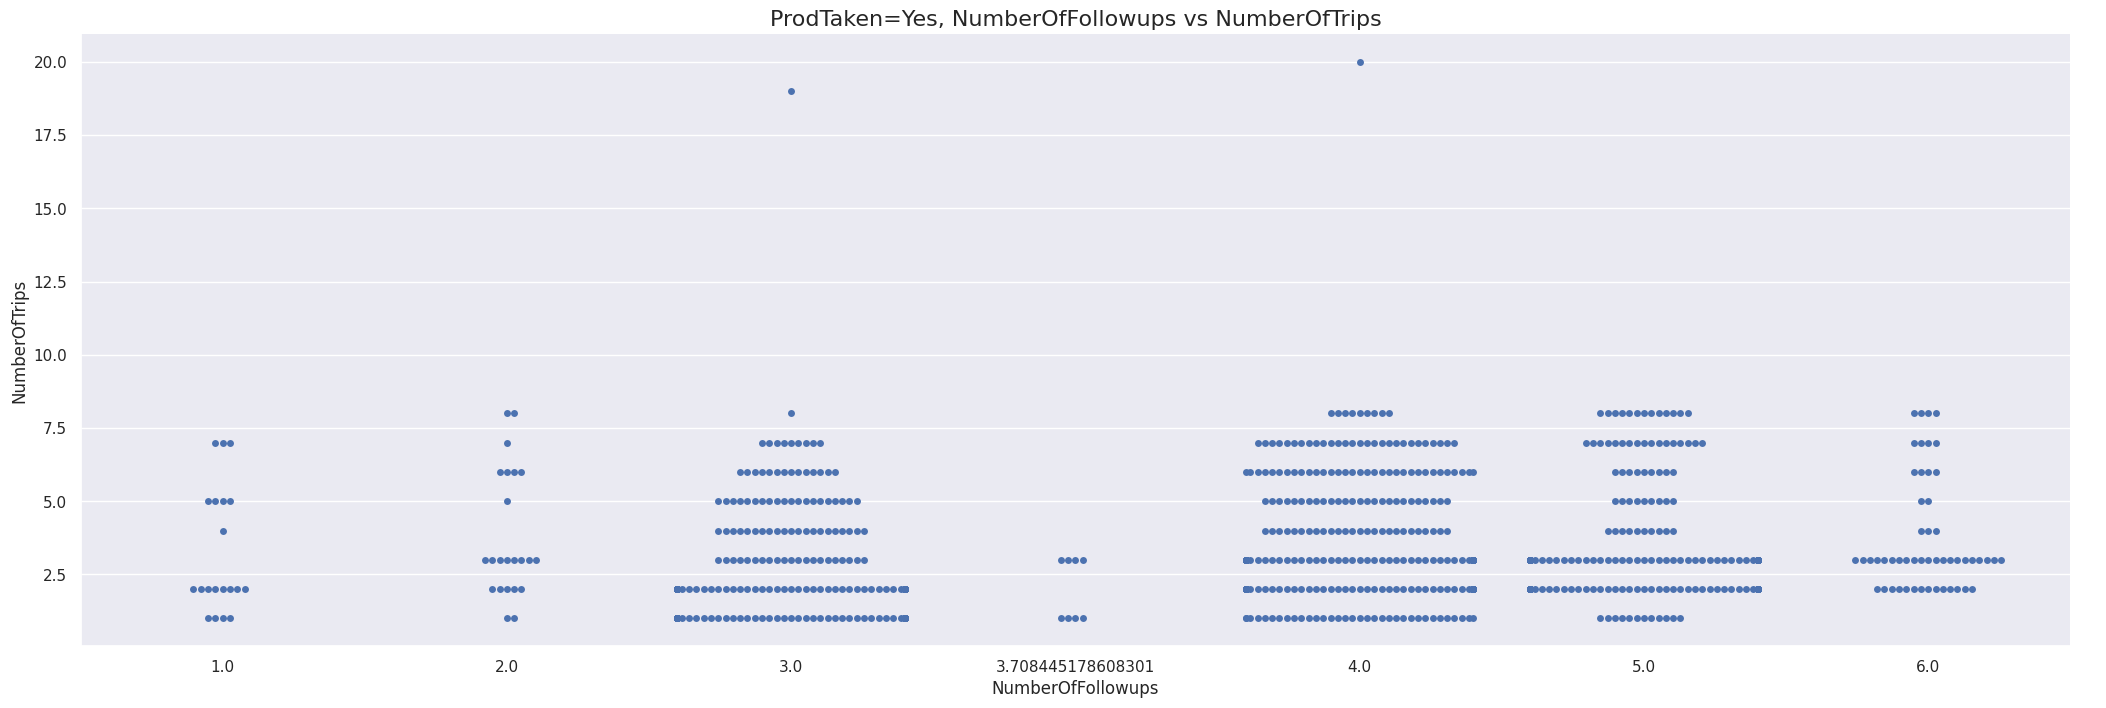

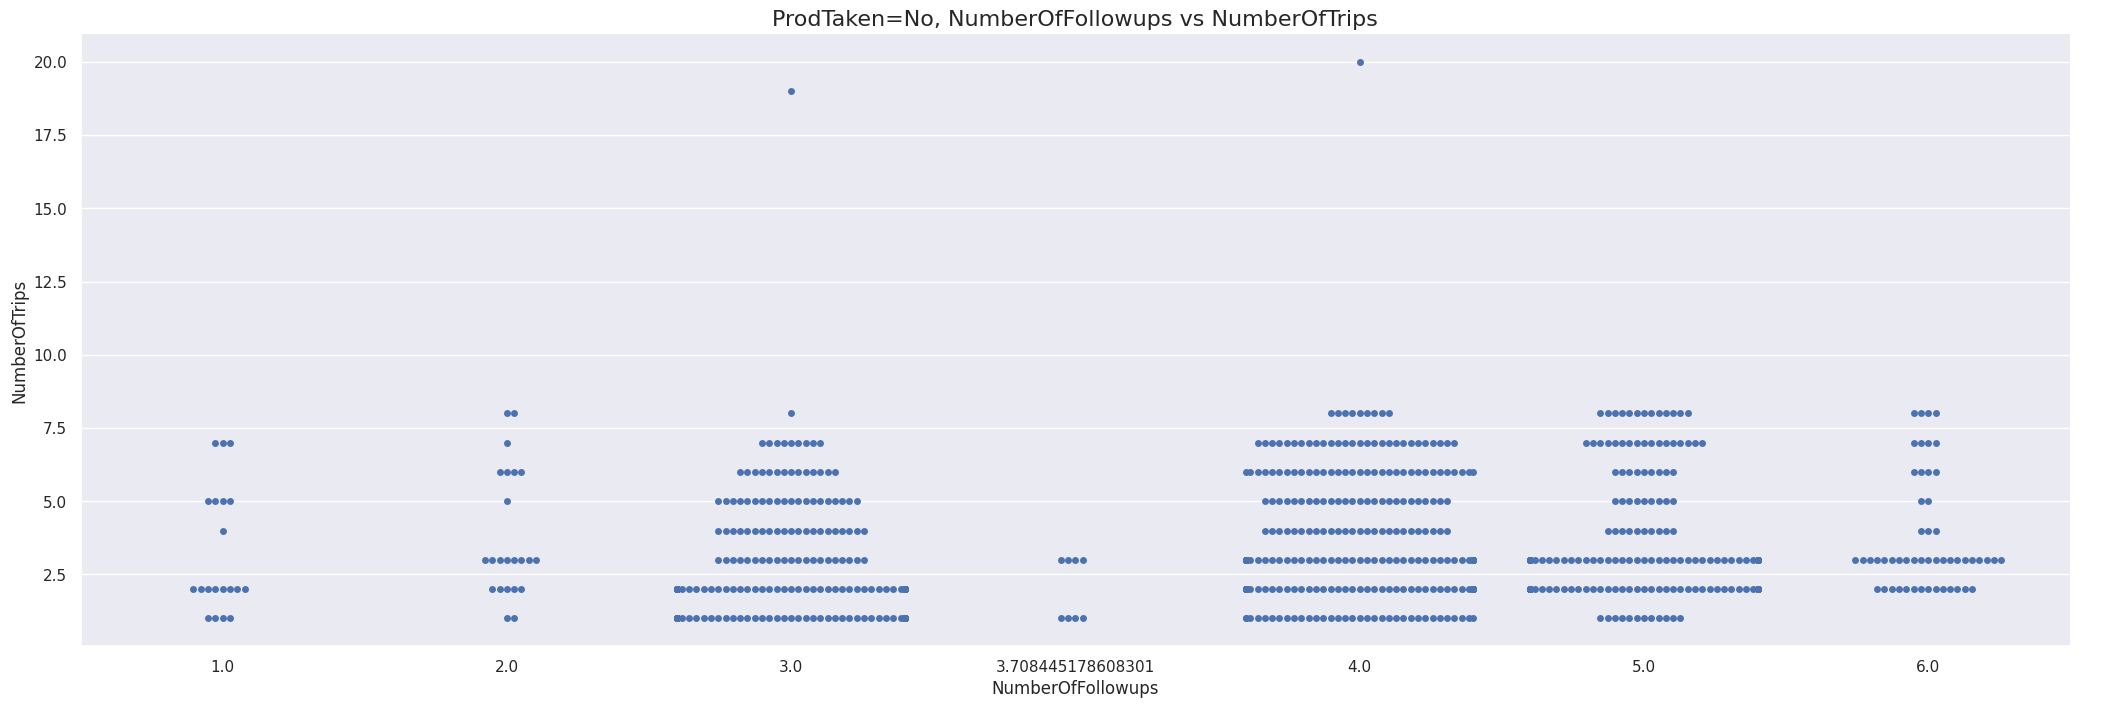

In [93]:
#Lets look at ProdTaken=Yes, NumberOfTrips, and NumberOfFollowups
#Remember PT_Yes and PT_No were defined earlier

#Lets see NumberOfTrips vs ProdTaken (Yes and No)
sns.set(rc={'figure.figsize':(12,6)})
sns.catplot(x="NumberOfFollowups", y="NumberOfTrips", kind="swarm", data=PT_yes, height=7, aspect=3);
plt.title("ProdTaken=Yes, NumberOfFollowups vs NumberOfTrips", fontsize=16)

sns.set(rc={'figure.figsize':(12,6)})
sns.catplot(x="NumberOfFollowups", y="NumberOfTrips", kind="swarm", data=PT_yes, height=7, aspect=3);
plt.title("ProdTaken=No, NumberOfFollowups vs NumberOfTrips", fontsize=16)

plt.show()

Notice that 3 to 5 Follow ups are the most common and also yield the better ProdTaken = Yes.  2 to 3 trips are the most common for customers that took the product.

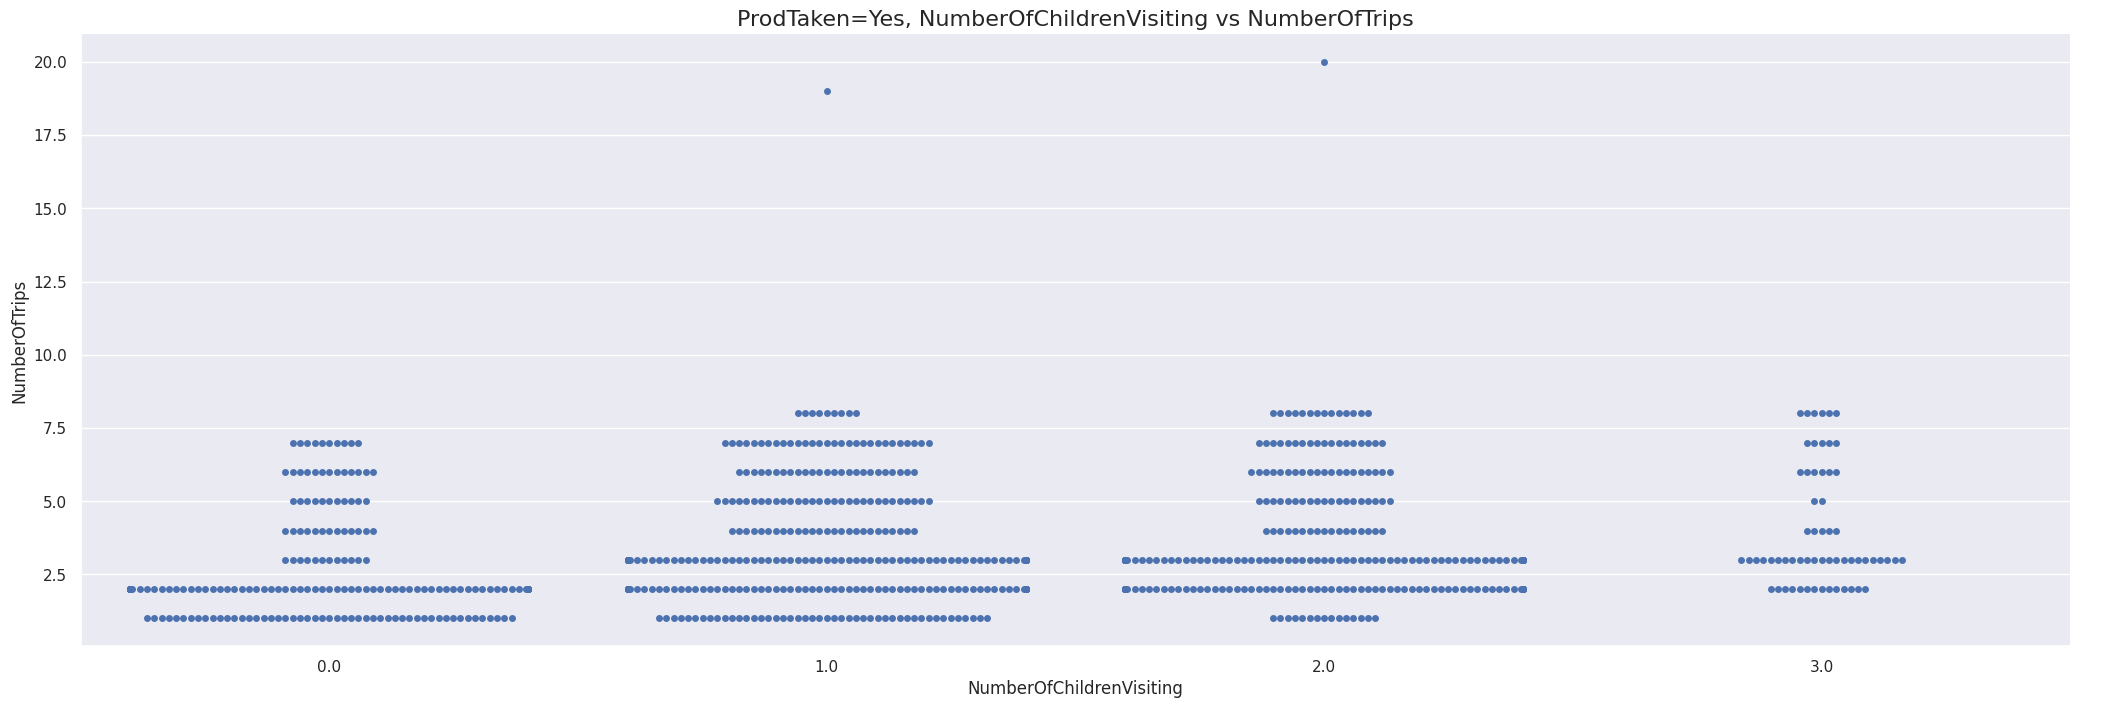

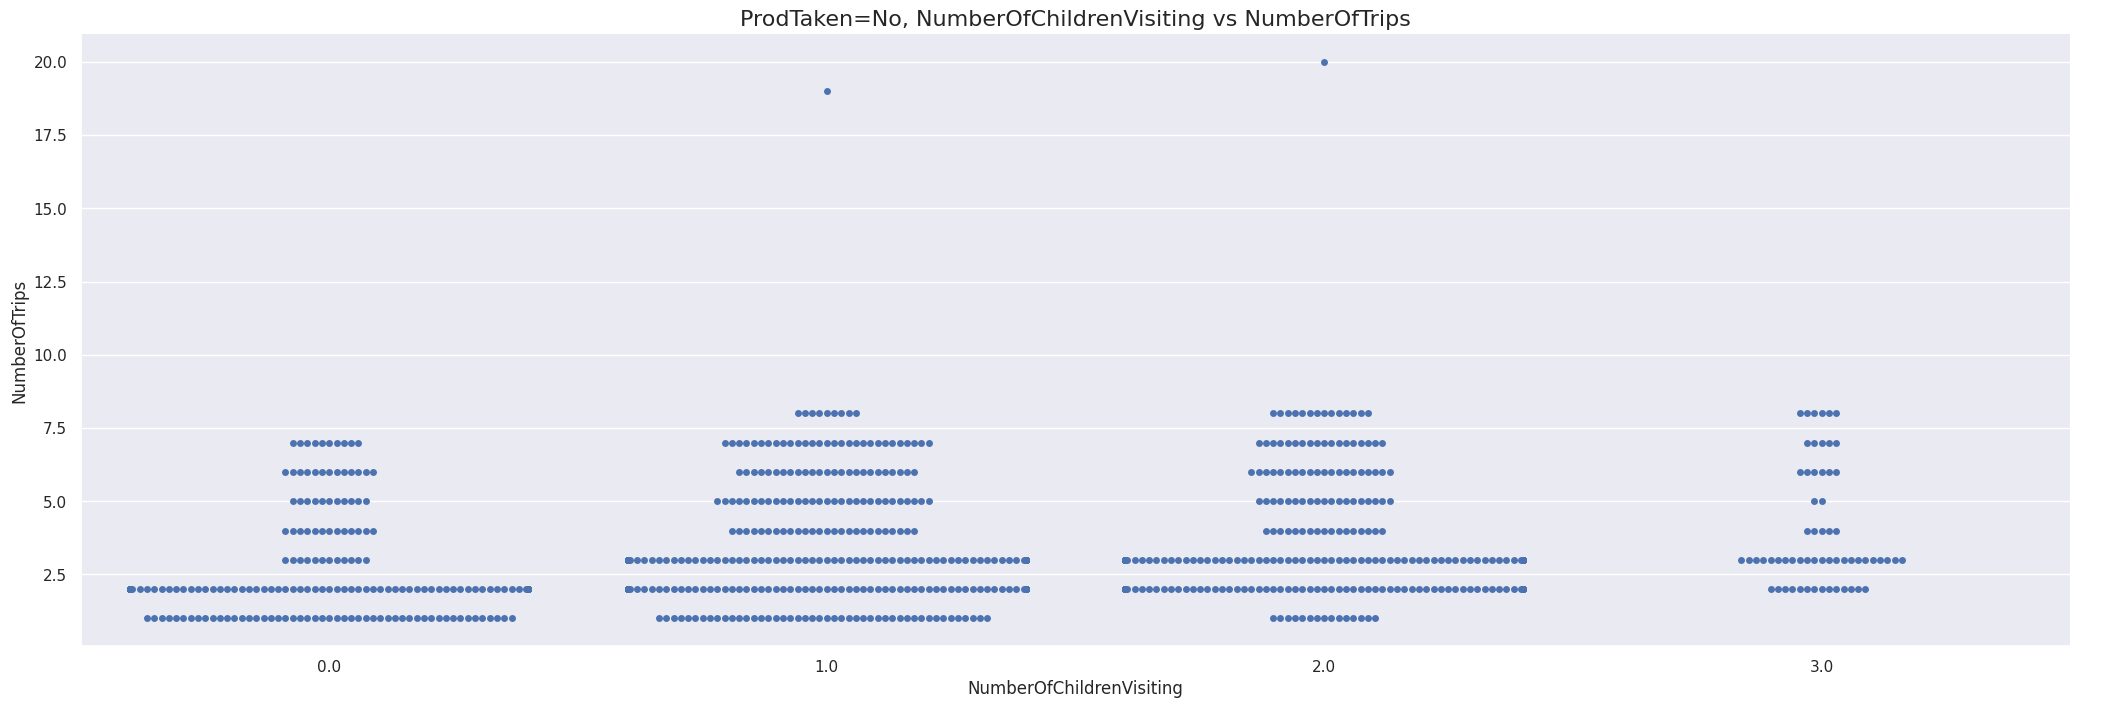

In [94]:
#Lets look at ProdTaken=Yes, NumberOfTrips, and NumberOfChildrenVisiting
#Remember PT_Yes and PT_No were defined earlier

#Lets see NumberOfChildrenVisiting vs ProdTaken (Yes and No)
sns.set(rc={'figure.figsize':(12,6)})
sns.catplot(x="NumberOfChildrenVisiting", y="NumberOfTrips", kind="swarm", data=PT_yes, height=7, aspect=3);
plt.title("ProdTaken=Yes, NumberOfChildrenVisiting vs NumberOfTrips", fontsize=16)

sns.set(rc={'figure.figsize':(12,6)})
sns.catplot(x="NumberOfChildrenVisiting", y="NumberOfTrips", kind="swarm", data=PT_yes, height=7, aspect=3);
plt.title("ProdTaken=No, NumberOfChildrenVisiting vs NumberOfTrips", fontsize=16)

plt.show()

Most customers have 1 children under 5 and this customer, but customers that travel with 1 children under 5 have taken 2-3 trips.

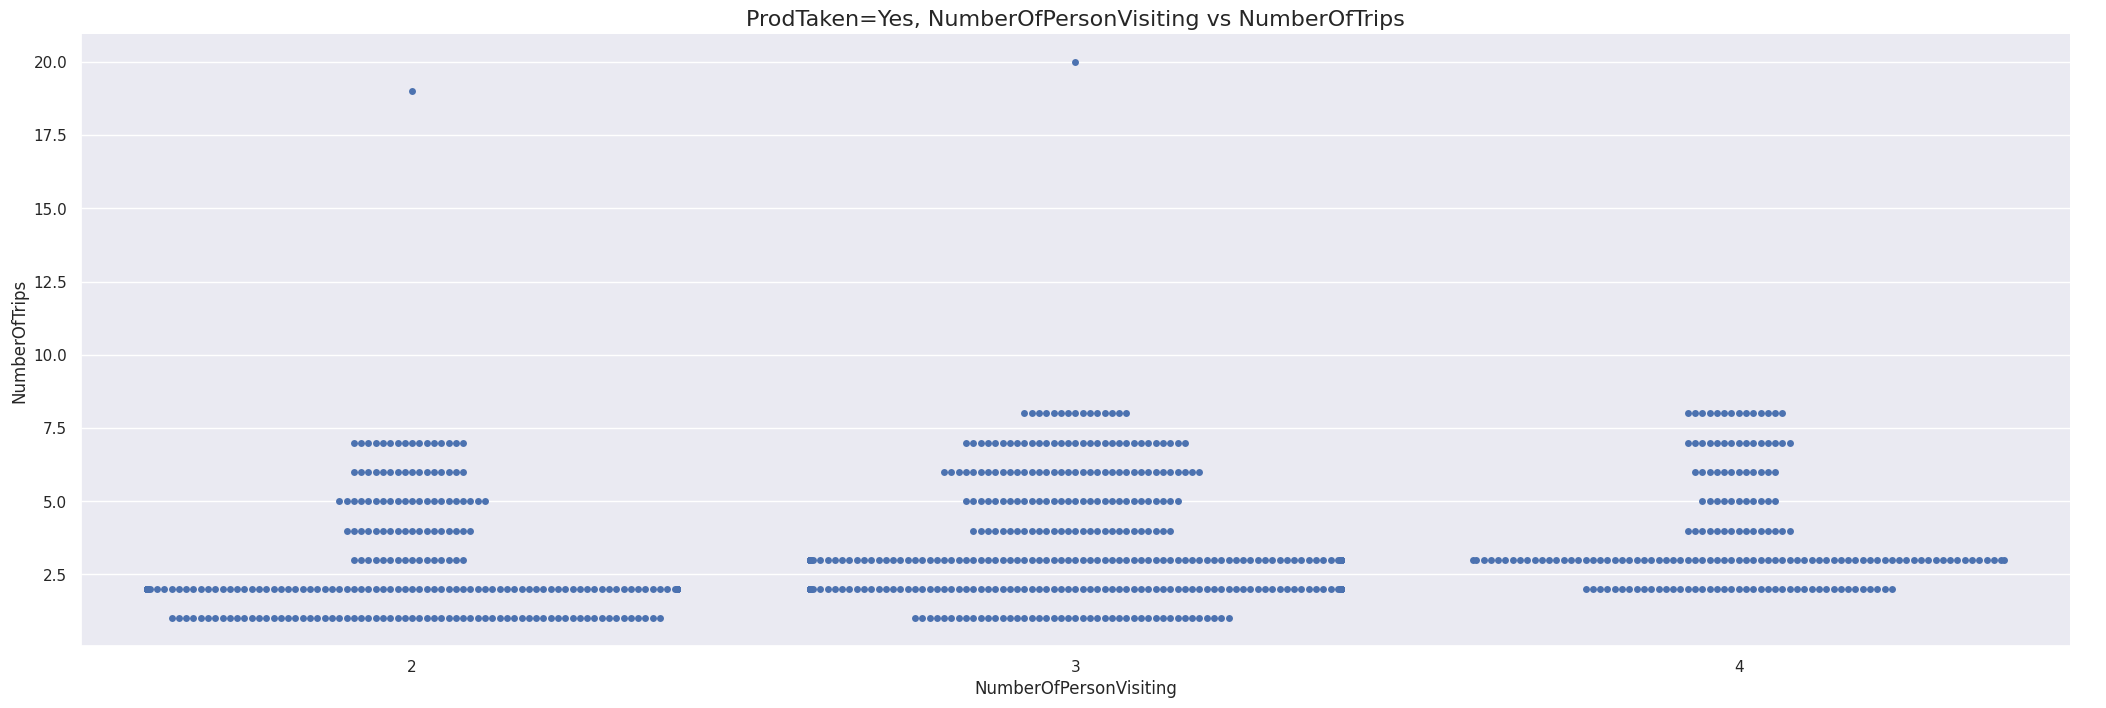

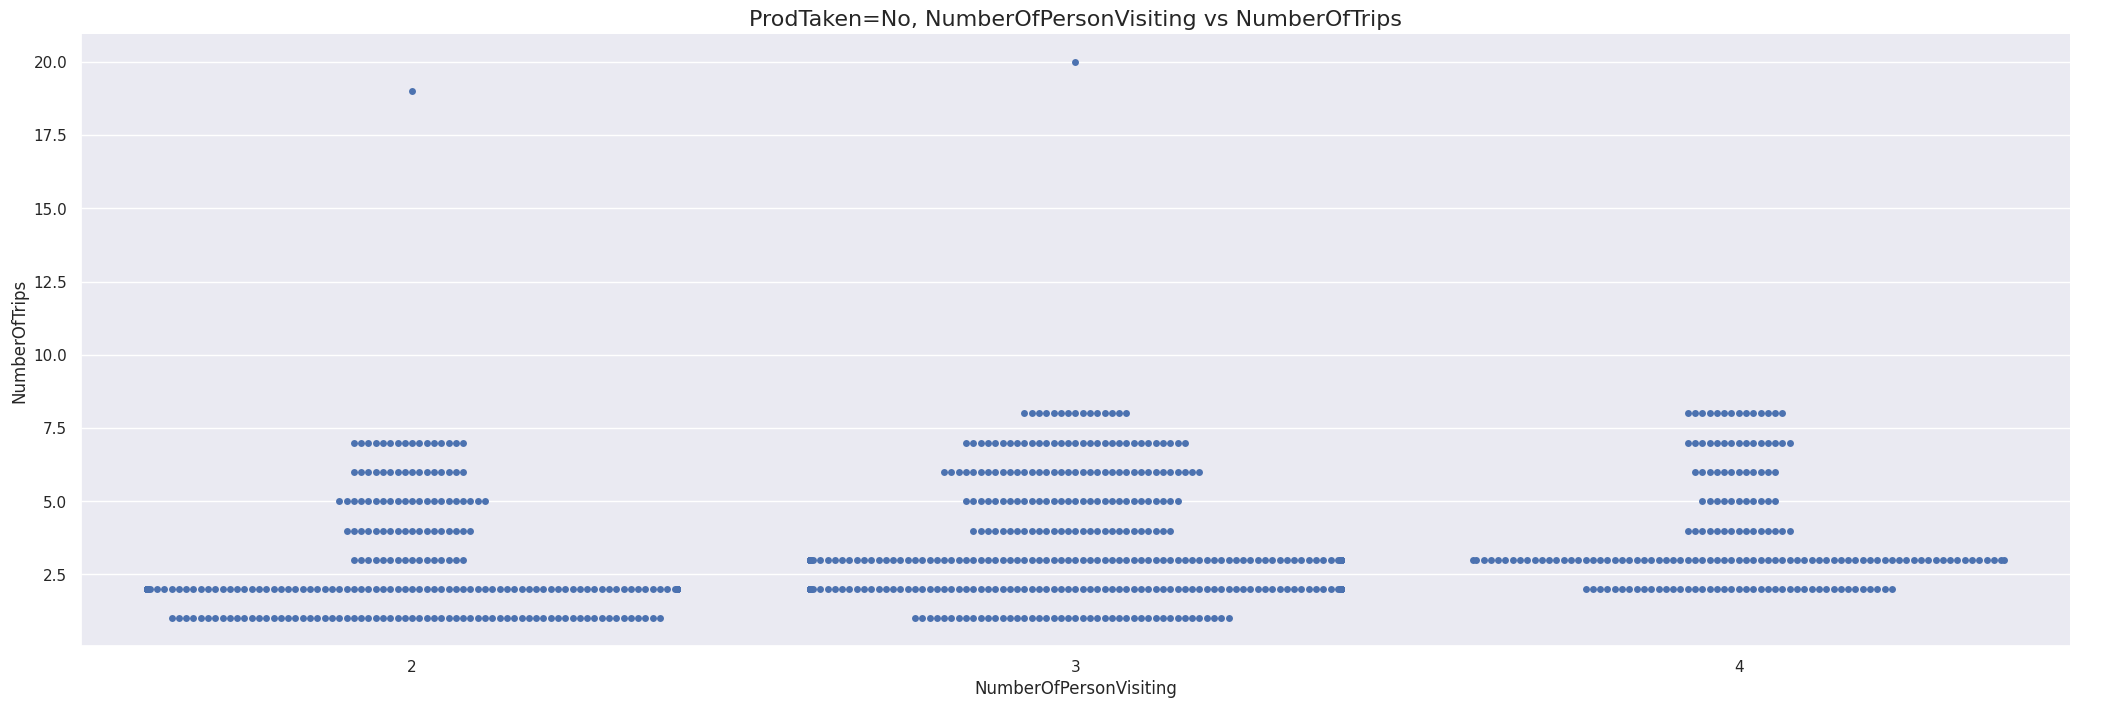

In [95]:
#Lets look at ProdTaken=Yes, NumberOfTrips, and NumberOfPersonVisiting
#Remember PT_Yes and PT_No were defined earlier

#Lets see NumberOfPersonVisiting vs ProdTaken (Yes and No)
sns.set(rc={'figure.figsize':(12,6)})
sns.catplot(x="NumberOfPersonVisiting", y="NumberOfTrips", kind="swarm", data=PT_yes, height=7, aspect=3);
plt.title("ProdTaken=Yes, NumberOfPersonVisiting vs NumberOfTrips", fontsize=16)

sns.set(rc={'figure.figsize':(12,6)})
sns.catplot(x="NumberOfPersonVisiting", y="NumberOfTrips", kind="swarm", data=PT_yes, height=7, aspect=3);
plt.title("ProdTaken=No, NumberOfPersonVisiting vs NumberOfTrips", fontsize=16)

plt.show()

3 NumberOfPersonVisiting took the most trips. However, there was no children under 5.

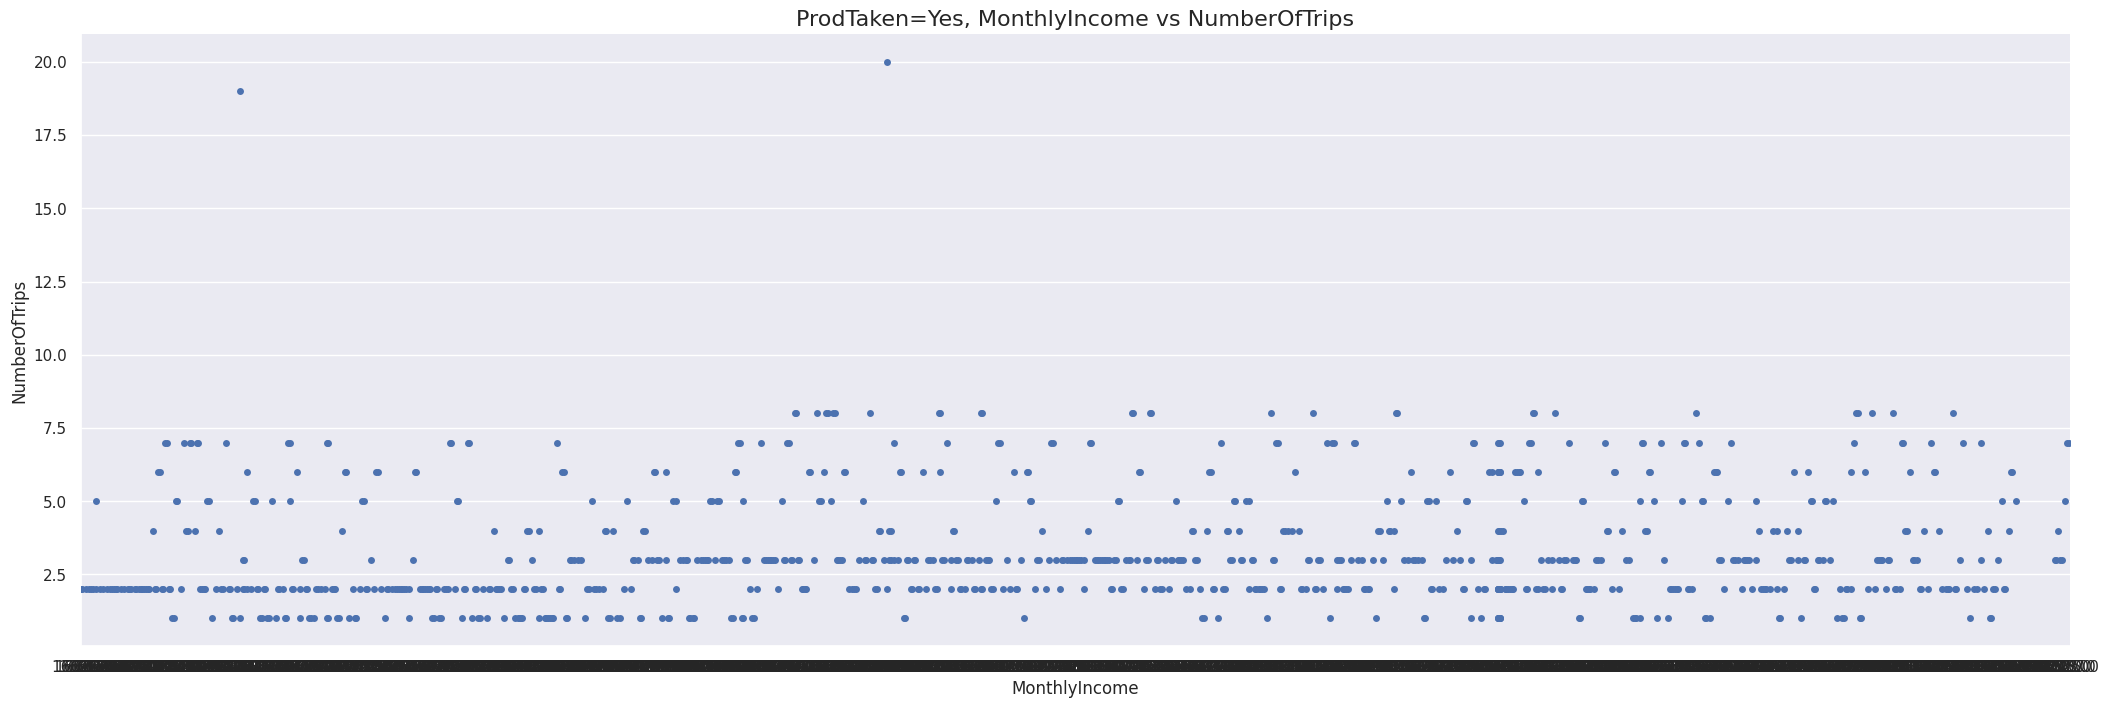

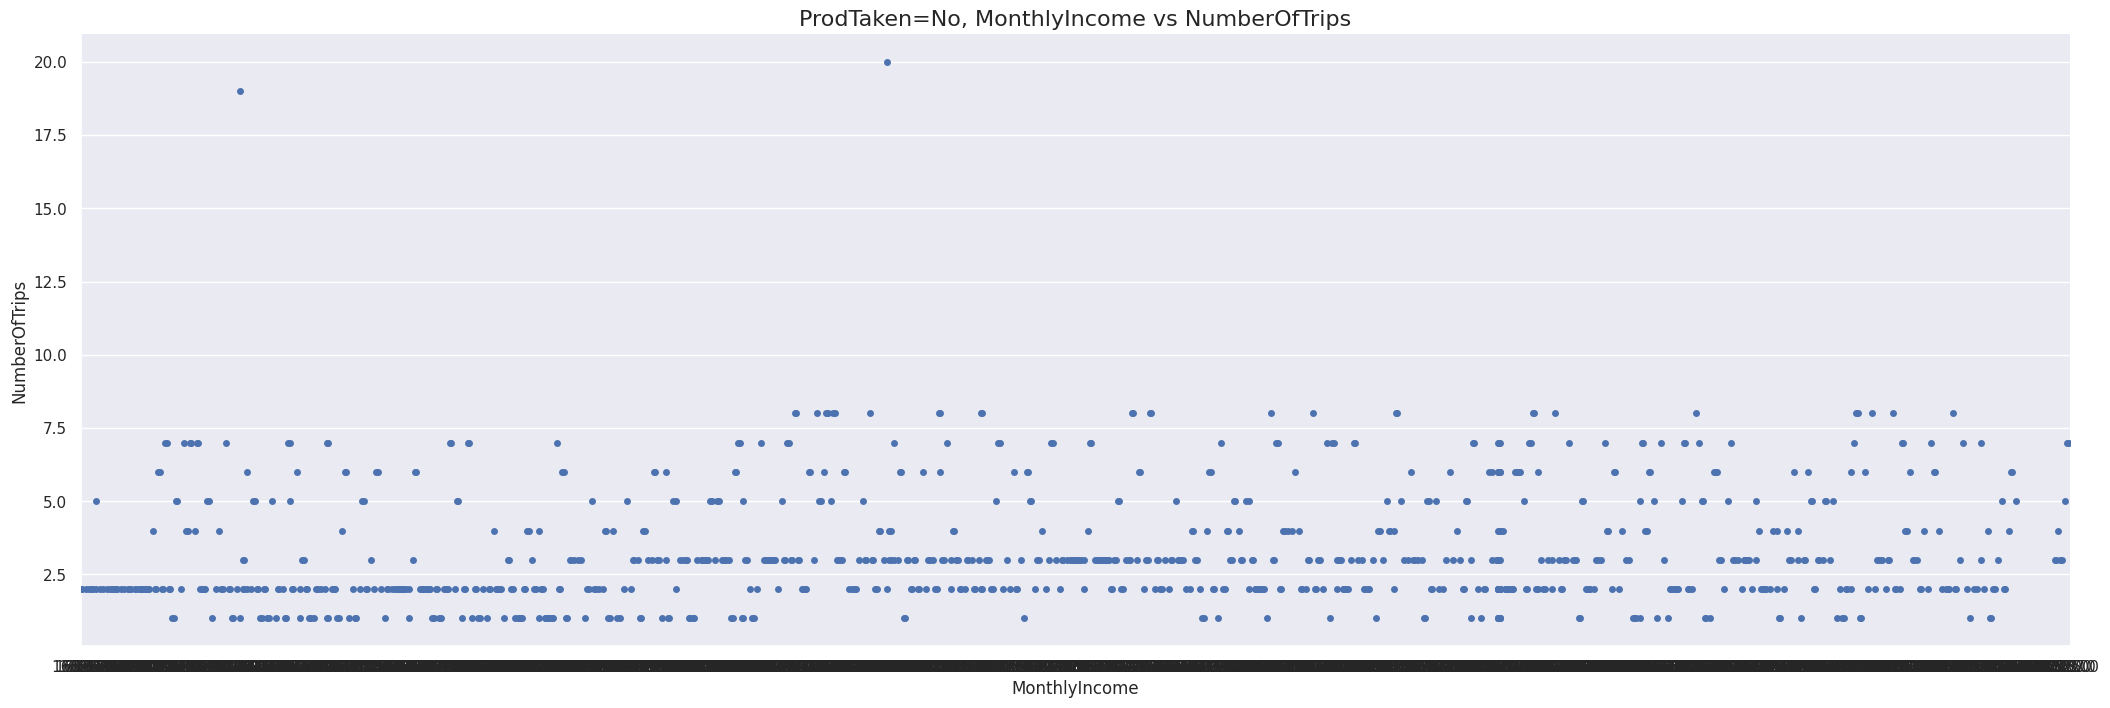

In [96]:
#Lets look at ProdTaken=Yes, NumberOfTrips, and MonthlyIncome
#Remember PT_Yes and PT_No were defined earlier

#Lets see NumberOfTrips vs ProdTaken (Yes and No)
sns.set(rc={'figure.figsize':(18,7)})
sns.catplot(x="MonthlyIncome", y="NumberOfTrips", kind="swarm", data=PT_yes, height=7, aspect=3);
plt.title("ProdTaken=Yes, MonthlyIncome vs NumberOfTrips", fontsize=16)

sns.set(rc={'figure.figsize':(18,7)})
sns.catplot(x="MonthlyIncome", y="NumberOfTrips", kind="swarm", data=PT_yes, height=7, aspect=3);
plt.title("ProdTaken=No, MonthlyIncome vs NumberOfTrips", fontsize=16)

plt.show()

Notice that the lower income most commonly take about 2 trips while the other groups take 2 to 3 trips. So we will assume that we may be able to imputate null values for NumberOfTrips to 2 or 3. We will imputate to the lower 2 (for took at least 2 trips).


So how do we approach the Missing values for NumberOfTrips


In [97]:
#imputate 2 into the missing values for NumberOfTrips
NOT_atLeast = 3
values = {"NumberOfTrips": NOT_atLeast}
vu_Tourism.fillna(value=values,inplace=True)

Lets double check if we took care of all Null Values

In [98]:
vu_Tourism.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4888 entries, 0 to 4887
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ProdTaken                 4888 non-null   int64  
 1   Age                       4888 non-null   float64
 2   TypeofContact             4888 non-null   object 
 3   CityTier                  4888 non-null   int64  
 4   DurationOfPitch           4888 non-null   float64
 5   Occupation                4888 non-null   object 
 6   Gender                    4888 non-null   object 
 7   NumberOfPersonVisiting    4888 non-null   int64  
 8   NumberOfFollowups         4888 non-null   float64
 9   ProductPitched            4888 non-null   object 
 10  PreferredPropertyStar     4888 non-null   float64
 11  MaritalStatus             4888 non-null   object 
 12  NumberOfTrips             4888 non-null   float64
 13  Passport                  4888 non-null   int64  
 14  PitchSat

We took care of all non-Null values

### **Outliers**

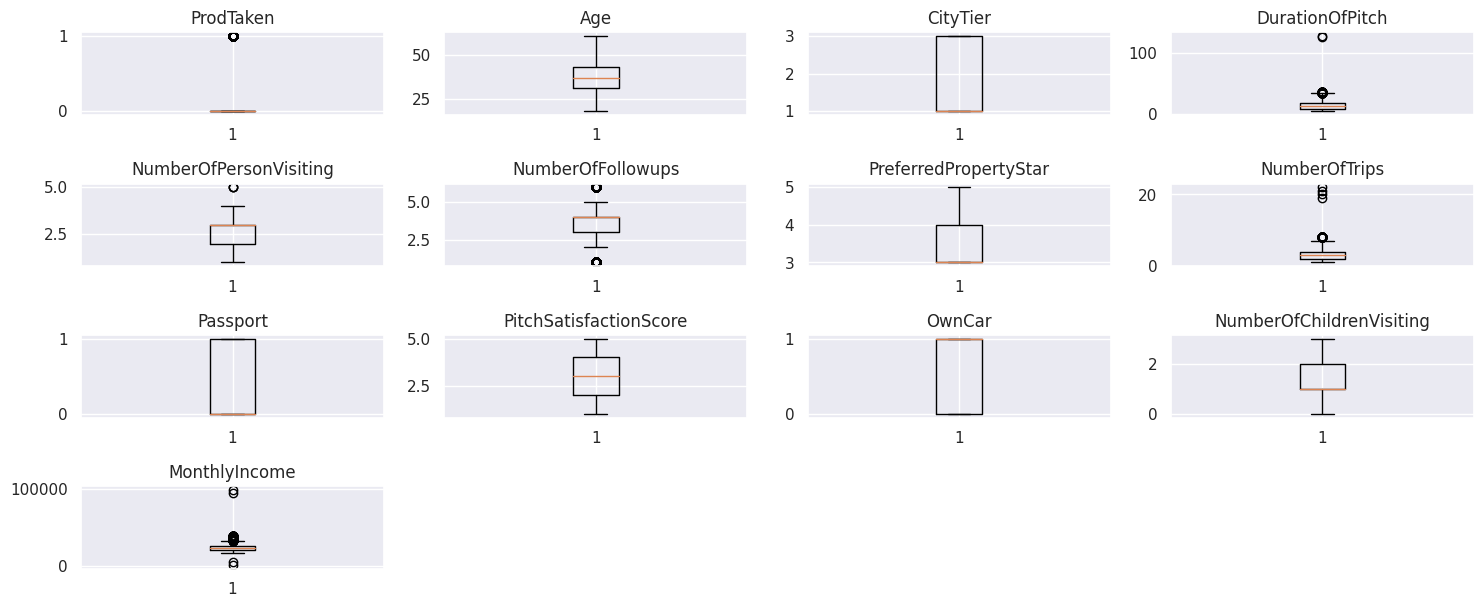

In [99]:
# outlier detection using boxplot
numeric_columns = vu_Tourism.select_dtypes(include=np.number).columns.tolist()

plt.figure(figsize=(15, 12))

for i, variable in enumerate(numeric_columns):
    plt.subplot(8, 4, i + 1)
    plt.boxplot(vu_Tourism[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

The outliers of interest are MonthlyIncome, NumberOfTrips, DurationOfPitch.

Monthly Income and NumberOfTrips are valid outliers as we discussed earlier because there will always be customers that are very wealthy and some that travel often.


Lets analyze DurationOfPitch

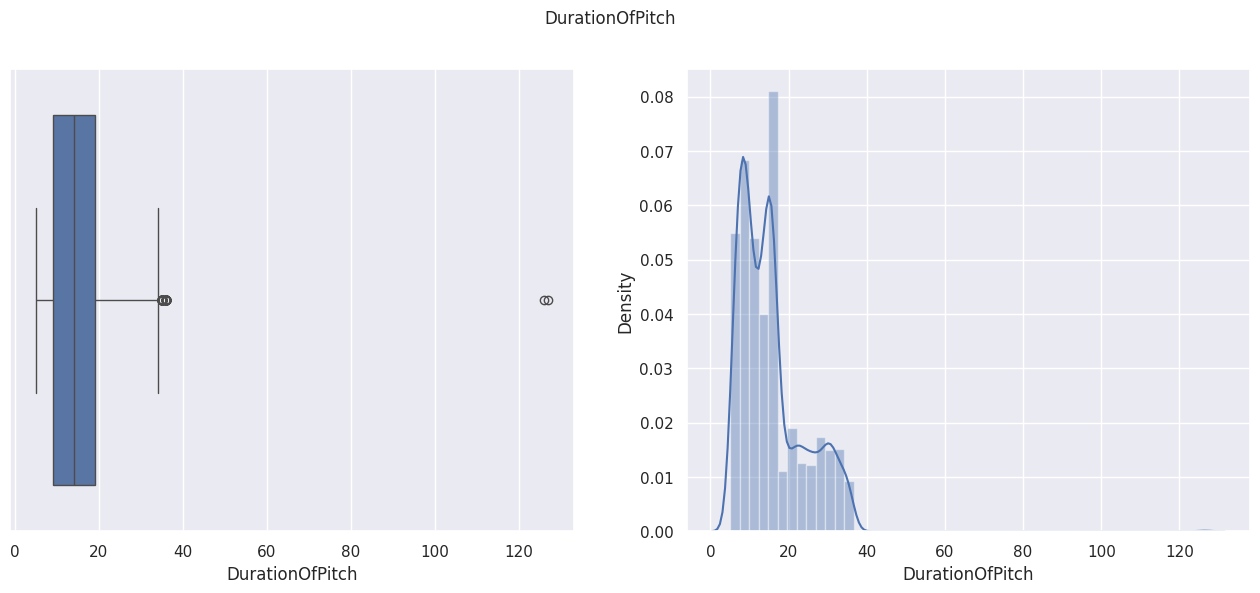

In [100]:
#Visualize DurationOfPitch Distribution plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
fig.suptitle('DurationOfPitch', fontsize=12)
sns.boxplot(data=vu_Tourism,x='DurationOfPitch', ax=ax1)
sns.distplot(vu_Tourism.DurationOfPitch,ax=ax2)
plt.show()

In [101]:
#The largest DurationOfPitch
vu_Tourism['DurationOfPitch'].nlargest()

3878    127.0
1434    126.0
2505     36.0
2585     36.0
2643     36.0
Name: DurationOfPitch, dtype: float64

Lets take a look at DurationOfPitch > 40

In [102]:
DOP_morethan40 = vu_Tourism[vu_Tourism['DurationOfPitch']>40]
DOP_morethan40

ProdTaken   Age    TypeofContact  CityTier  DurationOfPitch Occupation  \
1434          0  37.0  Company Invited         3            126.0   Salaried   
3878          0  53.0  Company Invited         3            127.0   Salaried   

     Gender  NumberOfPersonVisiting  NumberOfFollowups ProductPitched  \
1434   Male                       2                3.0          Basic   
3878   Male                       3                4.0          Basic   

      PreferredPropertyStar MaritalStatus  NumberOfTrips  Passport  \
1434                    3.0       Married            3.0         0   
3878                    3.0       Married            4.0         0   

      PitchSatisfactionScore  OwnCar  NumberOfChildrenVisiting Designation  \
1434                       1       1                       1.0   Executive   
3878                       1       1                       2.0   Executive   

      MonthlyIncome  
1434        18482.0  
3878        22160.0

Both Pitches have a very low satisfaction score and neither have ProdTaken = 1. Because of that, I wil leave these outliers because they may contribute to point out very long pitches may fail.

####**Bivariate Plots**

In [103]:
#Dataframe for ProdTaken Yes and Prodtaken No
PT_yes = vu_Tourism[vu_Tourism['ProdTaken']==1]
PT_no = vu_Tourism[vu_Tourism['ProdTaken']==0]

**Age vs ProdTaken**

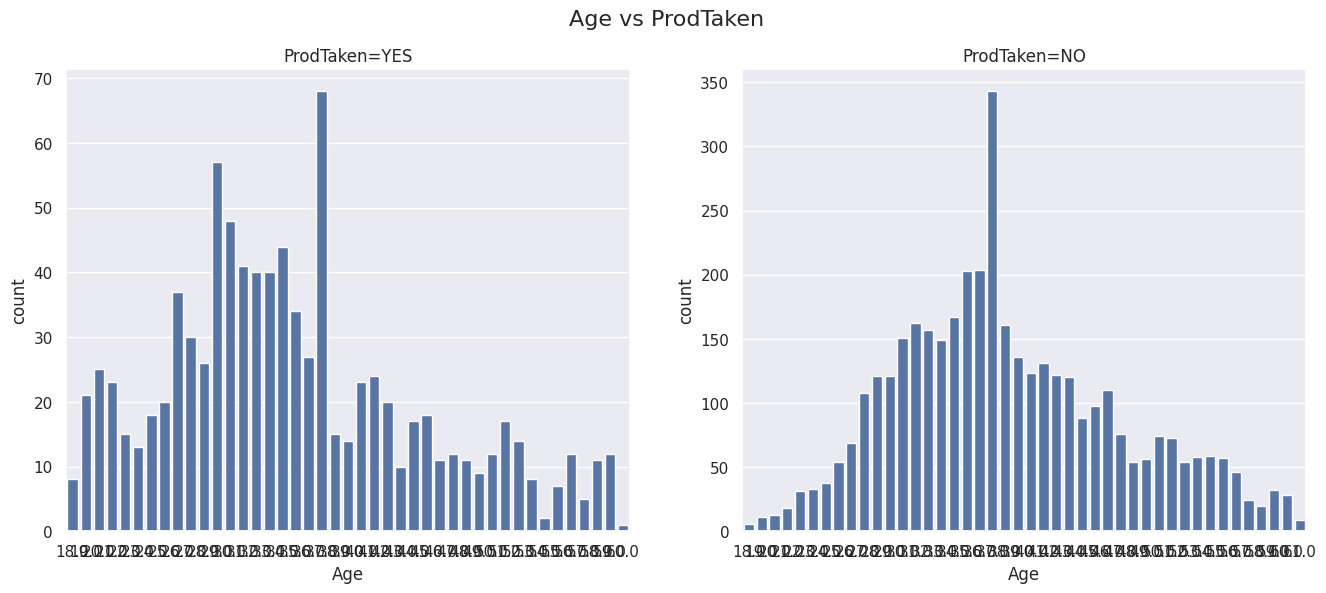

In [104]:
#How are Age affected by ProdTaken Yes/No
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
fig.suptitle('Age vs ProdTaken', fontsize=16)

sns.countplot(data=PT_yes, x='Age', ax=ax1)
ax1.title.set_text('ProdTaken=YES')

sns.countplot(data=PT_no, x='Age', ax=ax2)
ax2.title.set_text('ProdTaken=NO')

plt.show()

Age Group that purchase packages are mostly in the group of 40 to 27.

**TypeOfContact vs ProdTaken**

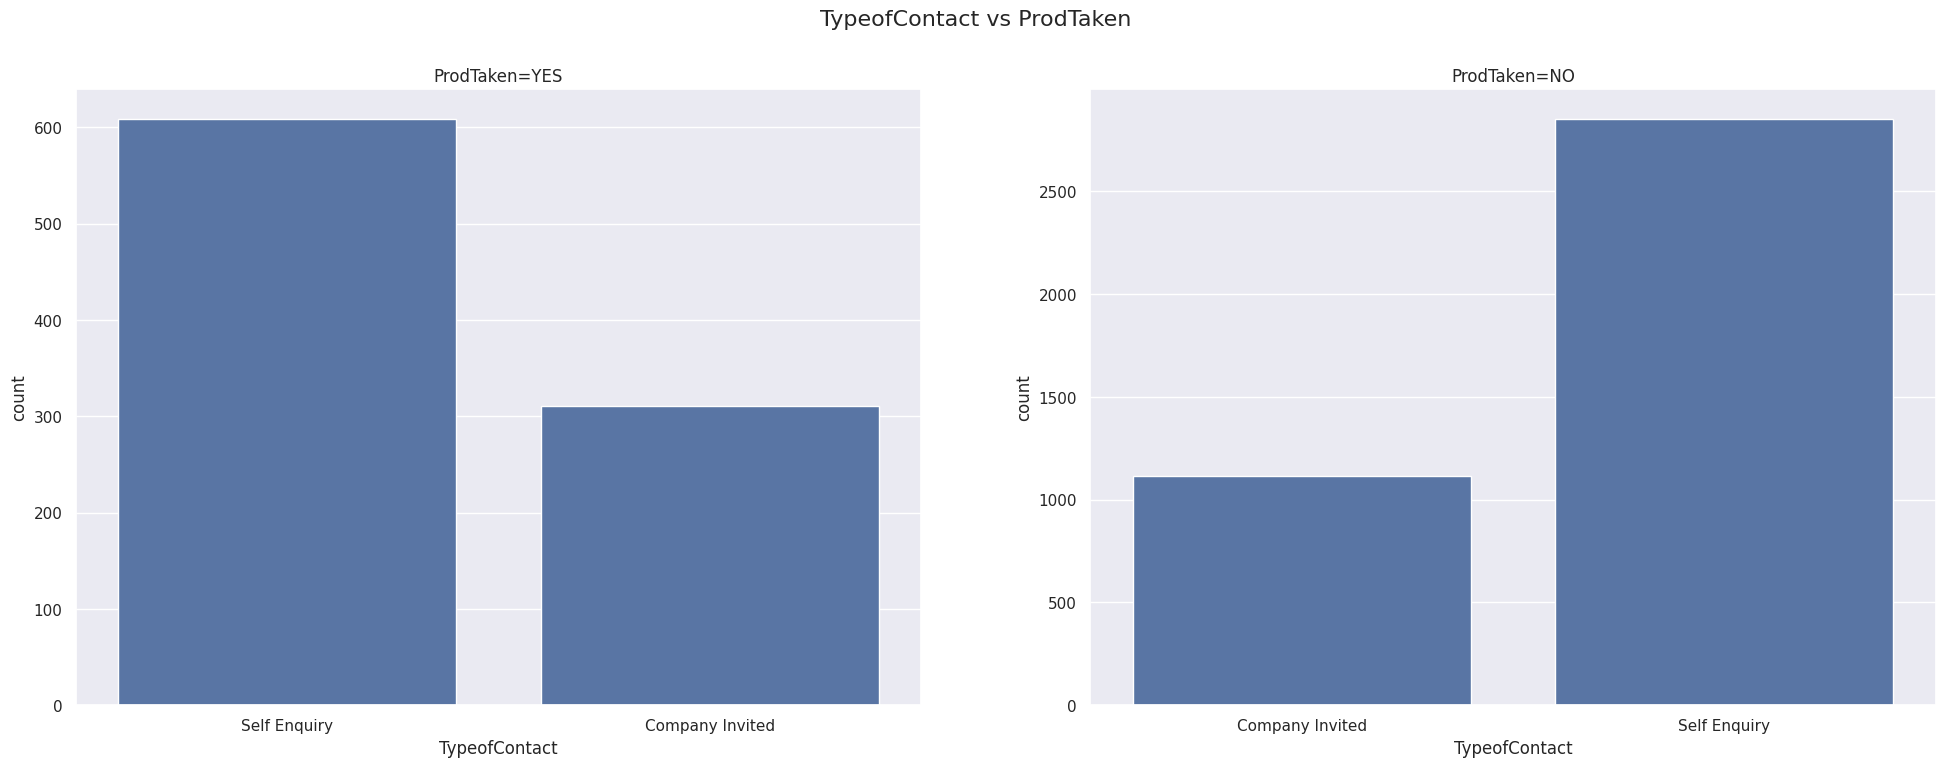

In [105]:
#How are TypeOfContact affected by ProdTaken Yes/No
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24,8))
fig.suptitle('TypeofContact vs ProdTaken', fontsize=16)

sns.countplot(data=PT_yes, x='TypeofContact', ax=ax1)
ax1.title.set_text('ProdTaken=YES')

sns.countplot(data=PT_no, x='TypeofContact', ax=ax2)
ax2.title.set_text('ProdTaken=NO')

plt.show()

Most custumers buying Packages are Self_Enquiry.

**CityTier vs ProdTaken**

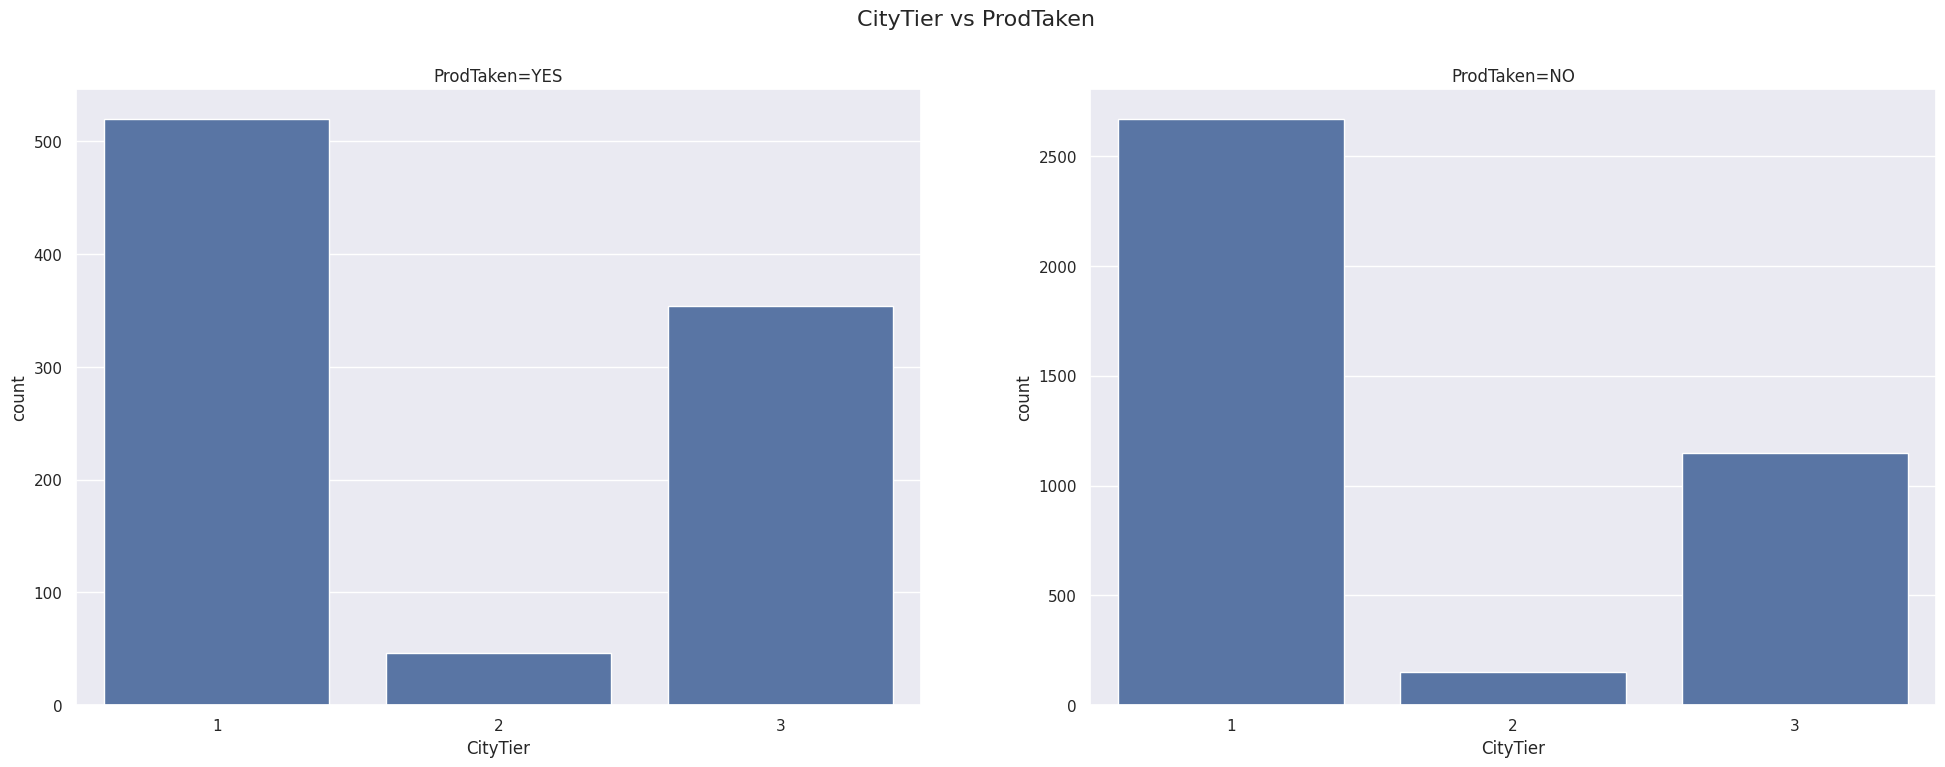

In [106]:
#How are CityTier affected by ProdTaken Yes/No

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24,8))
fig.suptitle('CityTier vs ProdTaken', fontsize=16)

sns.countplot(data=PT_yes, x='CityTier', ax=ax1)
ax1.title.set_text('ProdTaken=YES')

sns.countplot(data=PT_no, x='CityTier', ax=ax2)
ax2.title.set_text('ProdTaken=NO')

plt.show()



Most customers purchasing packages are in Tier 1 and 3.

**Occupations vs ProdTaken**

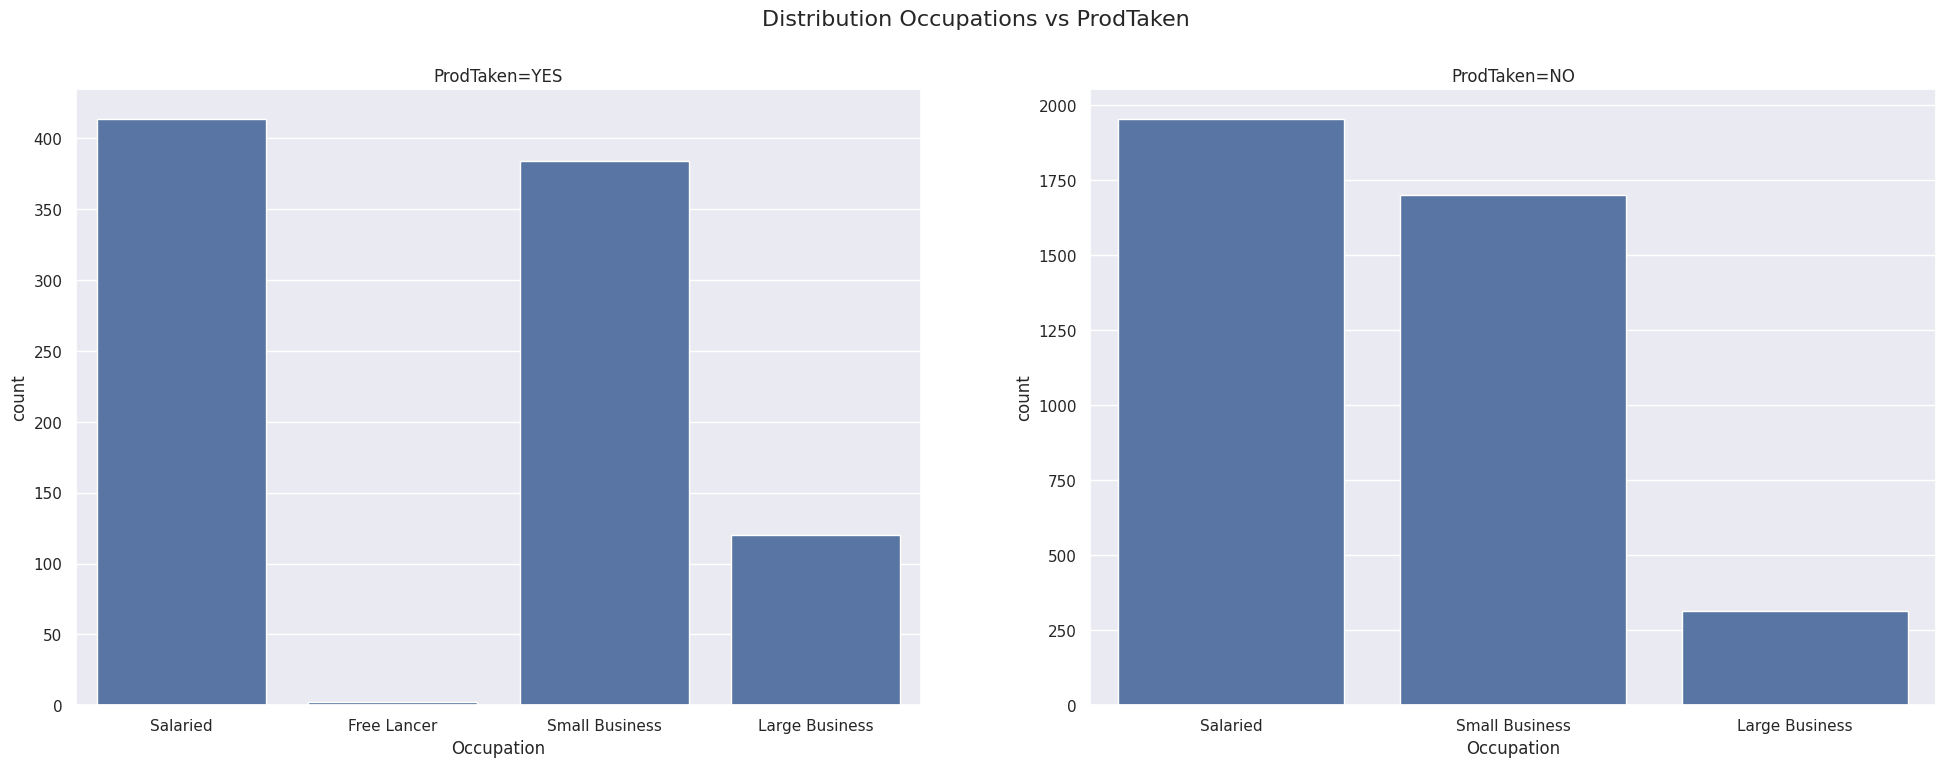

In [107]:
#How are Occupations distributed overall, ProdTaken=Yes, and ProdTaken=No
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24,8))
fig.suptitle('Distribution Occupations vs ProdTaken', fontsize=16)

sns.countplot(data=PT_yes, x='Occupation', ax=ax1)
ax1.title.set_text('ProdTaken=YES')

sns.countplot(data=PT_no, x='Occupation', ax=ax2)
ax2.title.set_text('ProdTaken=NO')

plt.show()

Most customers purchasing packages are Salaried and Small Business.

**Gender vs ProdTaken**

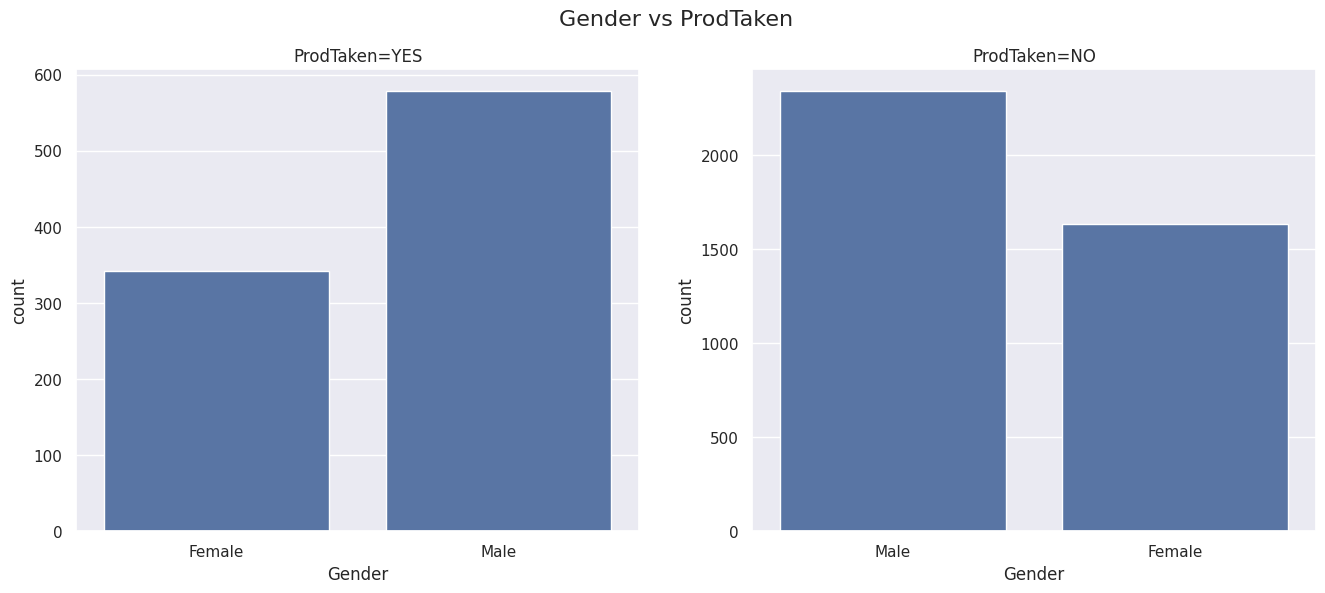

In [108]:
#Gender vs ProdTaken Yes/No
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
fig.suptitle('Gender vs ProdTaken', fontsize=16)

sns.countplot(data=PT_yes, x='Gender', ax=ax1)
ax1.title.set_text('ProdTaken=YES')
sns.countplot(data=PT_no, x='Gender', ax=ax2)
ax2.title.set_text('ProdTaken=NO')

plt.show()

Most customers purchasing packages are Male.

**ProdTaken vs ProductPitched**

[Text(0.5, 1.0, 'Age vs ProductPitched for ProdTaken=Yes')]

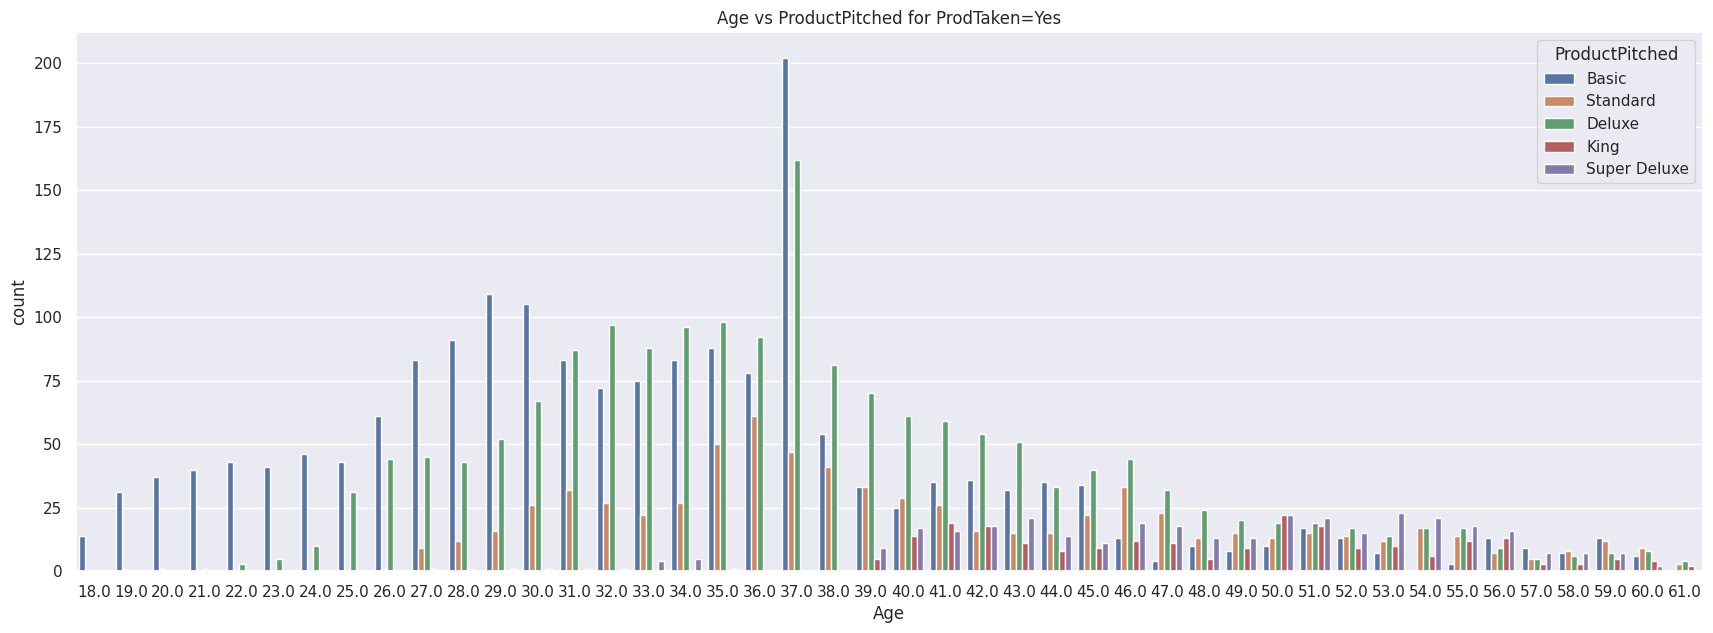

In [109]:
sns.set(rc={'figure.figsize':(21,7)})
sns.countplot(data=vu_Tourism,x="Age",hue="ProductPitched").set(title='Age vs ProductPitched for ProdTaken=Yes')

Age 37 is the group that purchases the most packages. The Basic and King Products are the most purchased.

The group age between 27 to 38 year

**NumberOfPersonVisiting vs ProdTaken**

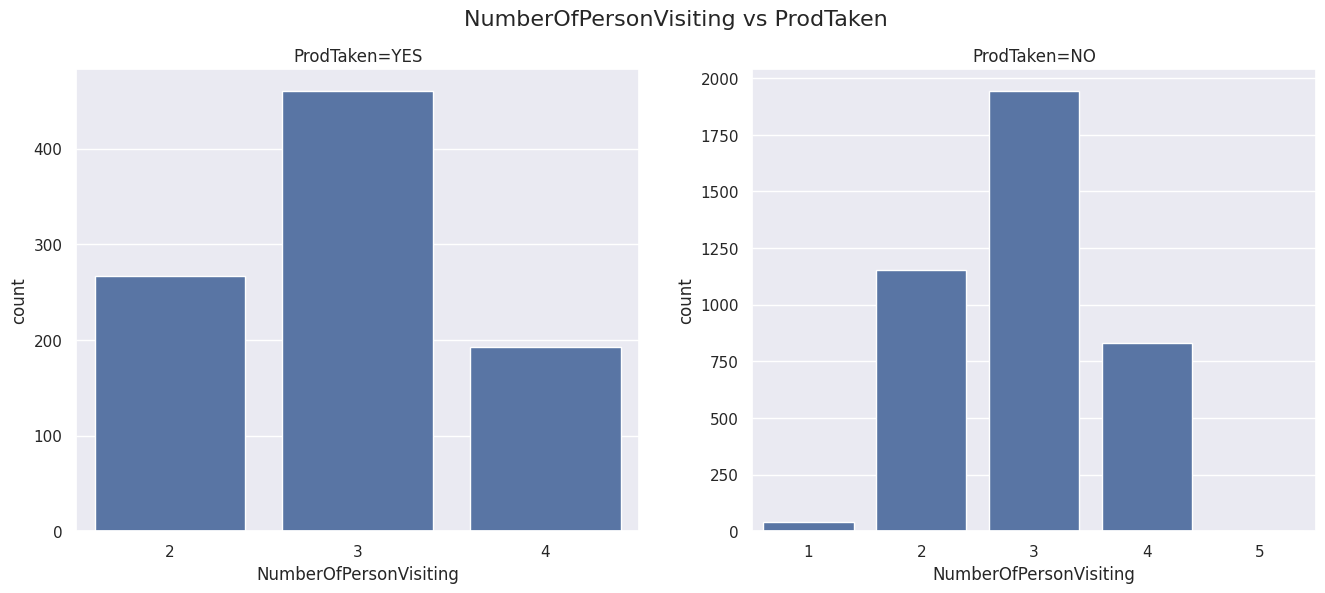

In [110]:
#How are NumberOfPersonVisiting affected by ProdTaken Yes/No
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
fig.suptitle('NumberOfPersonVisiting vs ProdTaken', fontsize=16)

sns.countplot(data=PT_yes, x='NumberOfPersonVisiting', ax=ax1)
ax1.title.set_text('ProdTaken=YES')

sns.countplot(data=PT_no, x='NumberOfPersonVisiting', ax=ax2)
ax2.title.set_text('ProdTaken=NO')

plt.show()

Most customers purchasing packages have 3 persons travelling.

**PreferredPropertyStar vs ProdTaken**

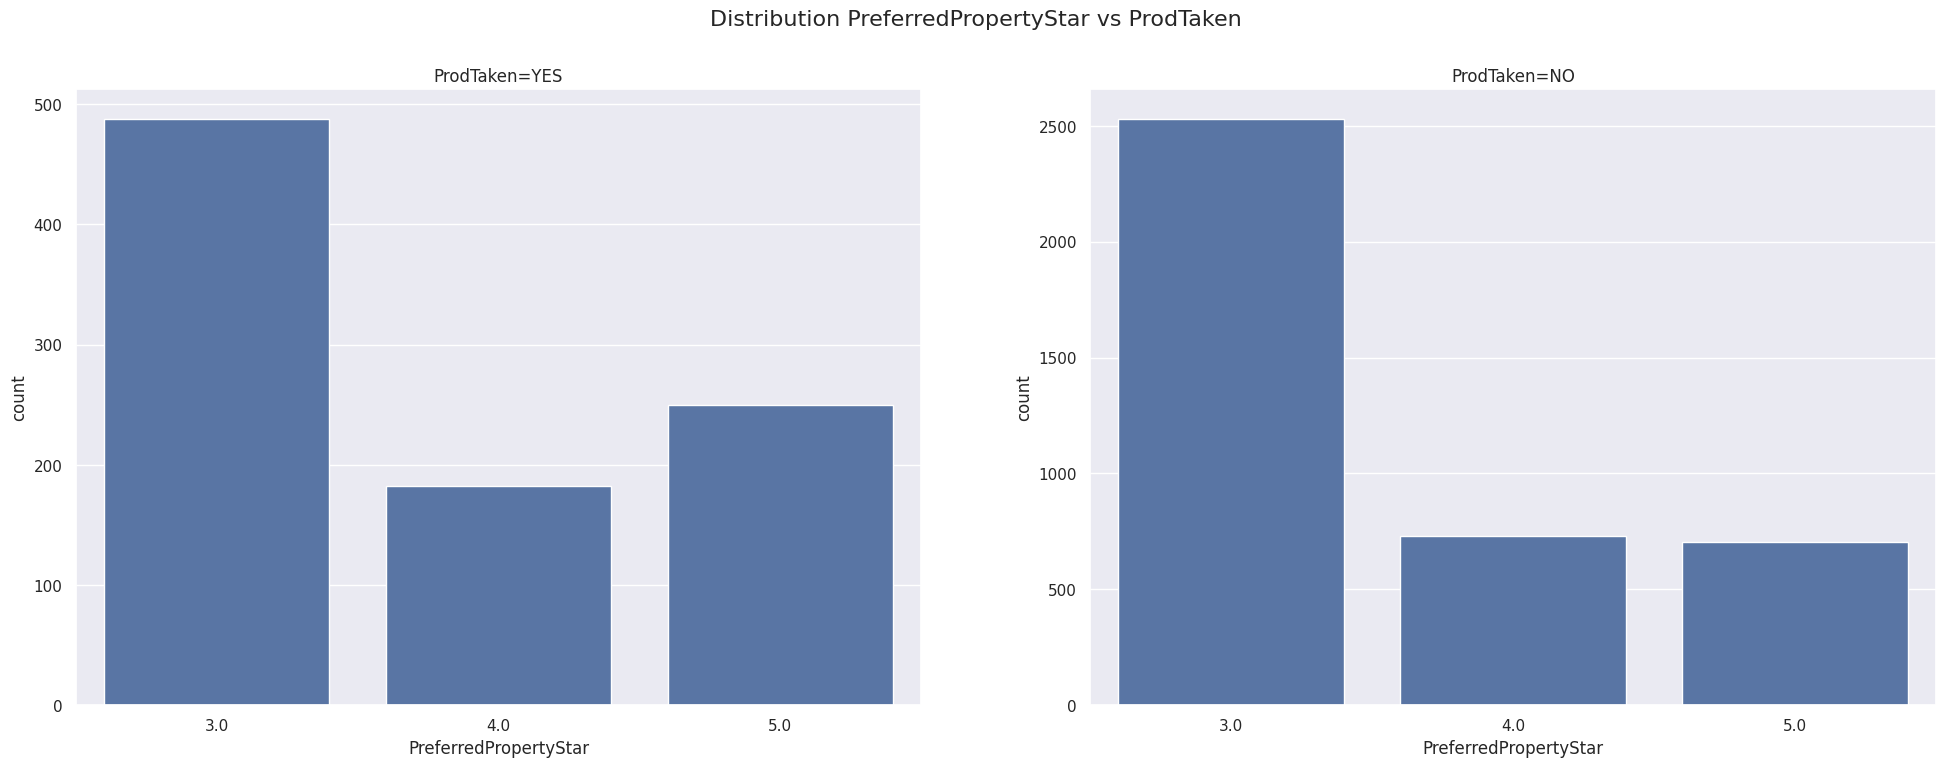

In [111]:
#PreferredPropertyStar vs ProdTaken
#How are PreferredPropertyStar distributed vs, ProdTaken=Yes, and ProdTaken=No
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24,8))
fig.suptitle('Distribution PreferredPropertyStar vs ProdTaken', fontsize=16)

sns.countplot(data=PT_yes, x='PreferredPropertyStar', ax=ax1)
ax1.title.set_text('ProdTaken=YES')

sns.countplot(data=PT_no, x='PreferredPropertyStar', ax=ax2)
ax2.title.set_text('ProdTaken=NO')

plt.show()

Most customers purchasing packages prefer a 3 star property. 5 star properties are slightly preferred than 4 star.

**MaritalStatus vs ProdTaken**

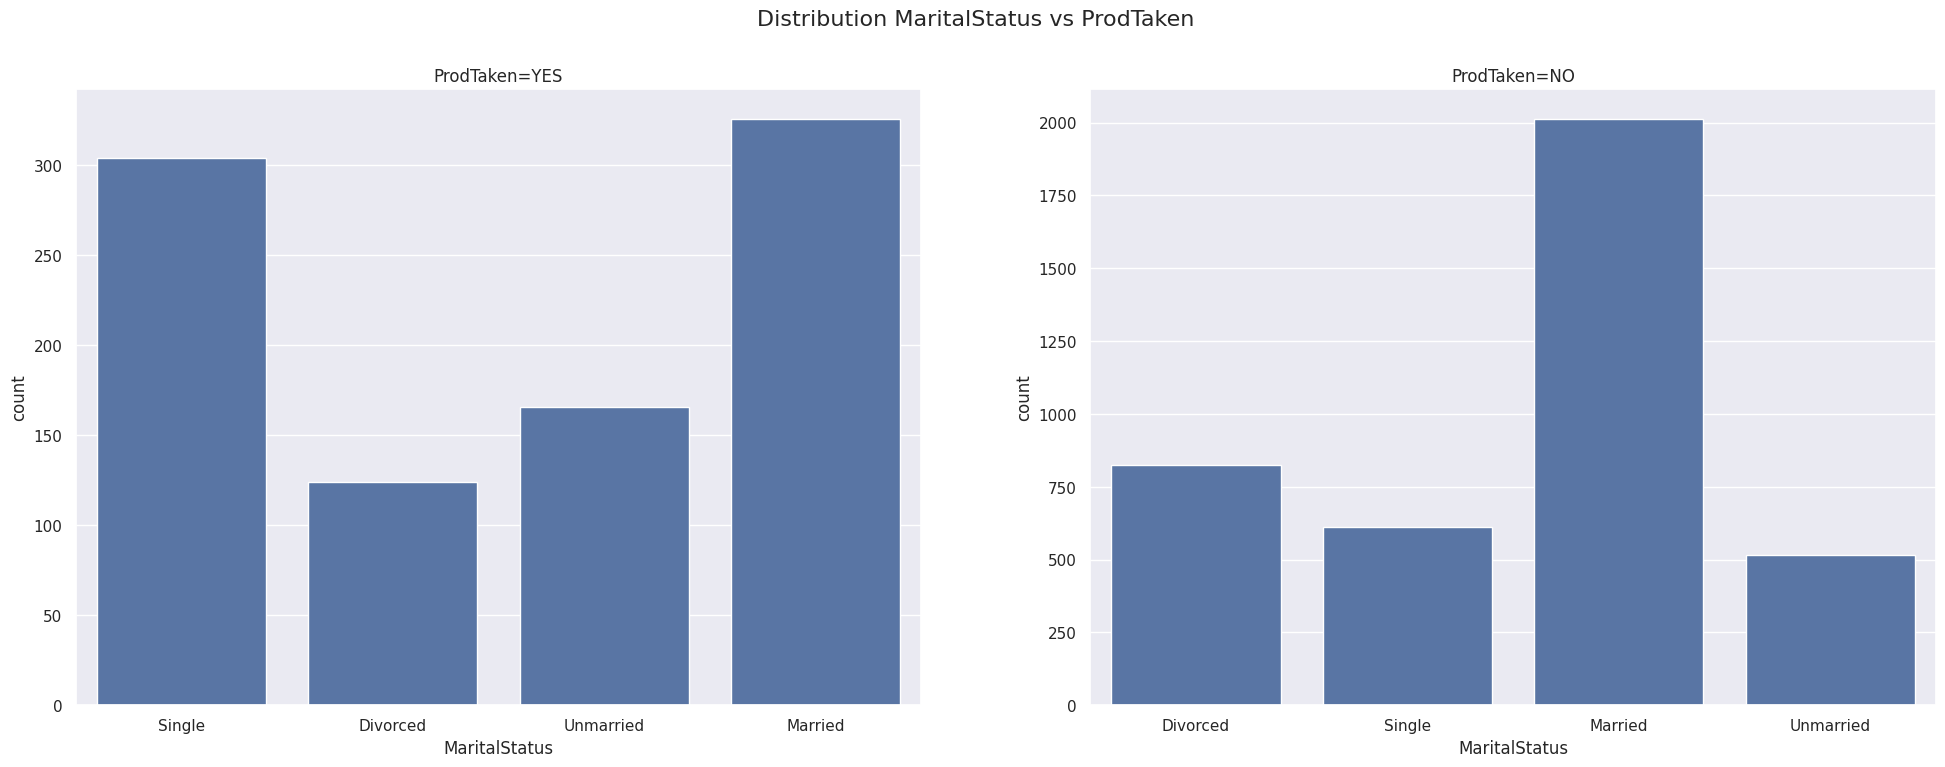

In [112]:
#MaritalStatus vs ProdTaken
#How are MaritalStatus distributed vs ProdTaken=Yes, and ProdTaken=No
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24,8))
fig.suptitle('Distribution MaritalStatus vs ProdTaken', fontsize=16)

sns.countplot(data=PT_yes, x='MaritalStatus', ax=ax1)
ax1.title.set_text('ProdTaken=YES')

sns.countplot(data=PT_no, x='MaritalStatus', ax=ax2)
ax2.title.set_text('ProdTaken=NO')

plt.show()

Overwhelmingly Executives are who purchase more packages.

**NumberOfTrips vs ProdTaken**

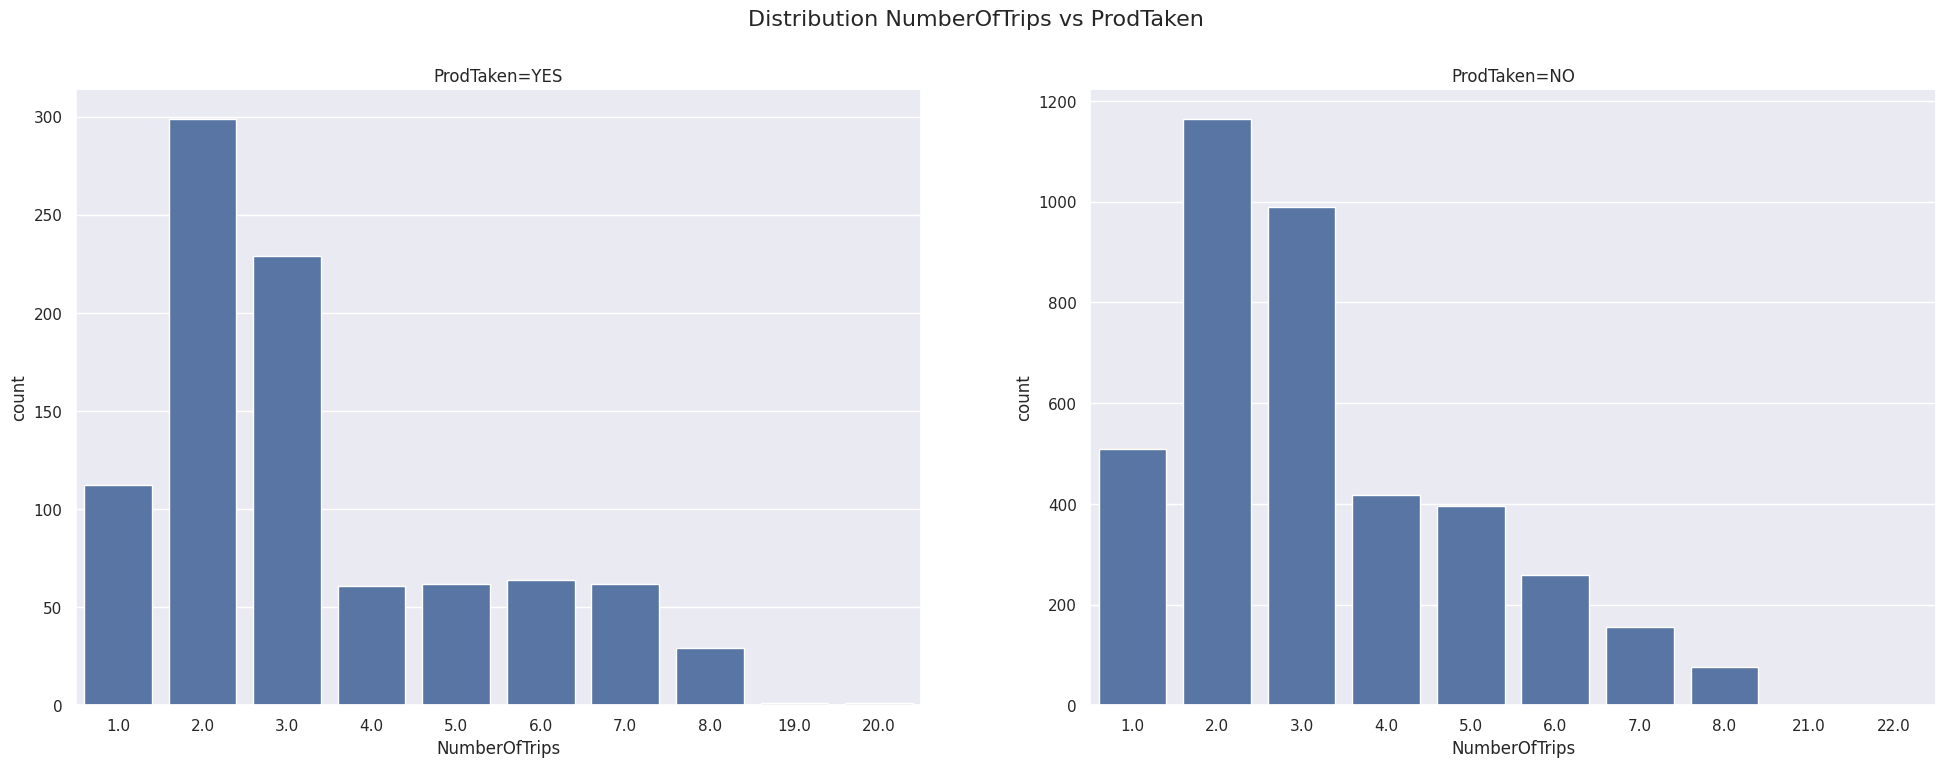

In [113]:
#NumberOfTrips vs ProdTaken
#How are NumberOfTrips distributed vsProdTaken=Yes, and ProdTaken=No
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24,8))
fig.suptitle('Distribution NumberOfTrips vs ProdTaken', fontsize=16)

sns.countplot(data=PT_yes, x='NumberOfTrips', ax=ax1)
ax1.title.set_text('ProdTaken=YES')

sns.countplot(data=PT_no, x='NumberOfTrips', ax=ax2)
ax2.title.set_text('ProdTaken=NO')

plt.show()

Most customers that purchase packages have previously taken 2 to 3 trips before.

**Passport vs ProdTaken**

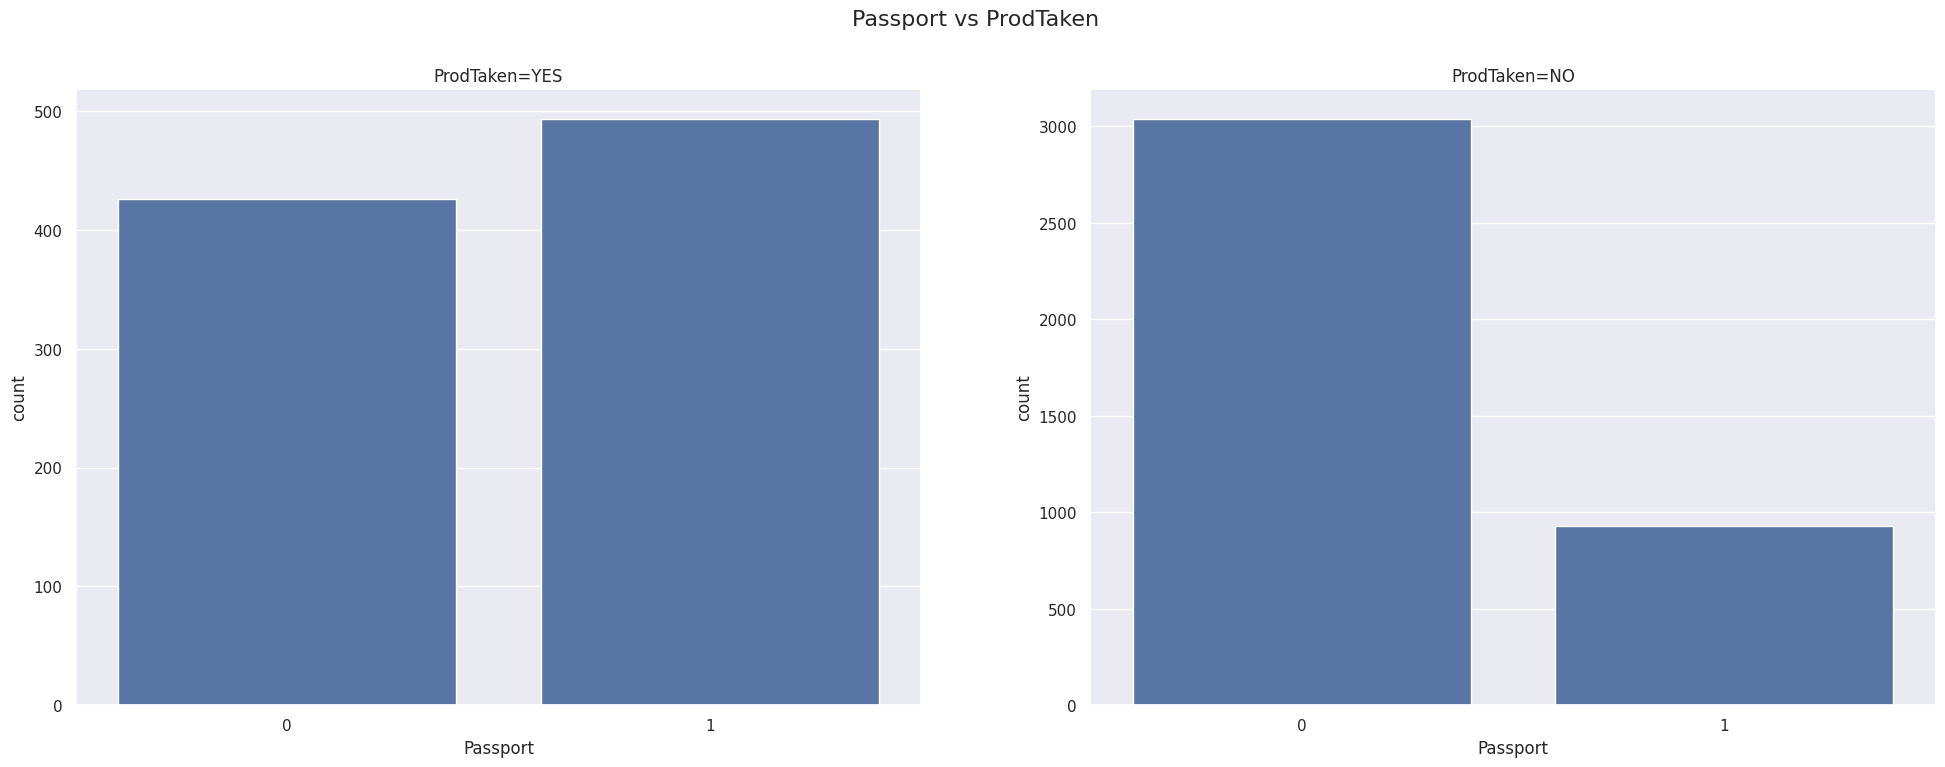

In [114]:
#Passport vs ProdTaken
#How are Passport distributed vs, ProdTaken=Yes, and ProdTaken=No
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24,8))
fig.suptitle('Passport vs ProdTaken', fontsize=16)

sns.countplot(data=PT_yes, x='Passport', ax=ax1)
ax1.title.set_text('ProdTaken=YES')

sns.countplot(data=PT_no, x='Passport', ax=ax2)
ax2.title.set_text('ProdTaken=NO')

plt.show()

Customers that have passports are more likely to purchase a Trip and this is determinant because the number of Customers that didn't purchase a Package are overwhelmingly those that do not have a passport.

**OwnCar vs ProdTaken**

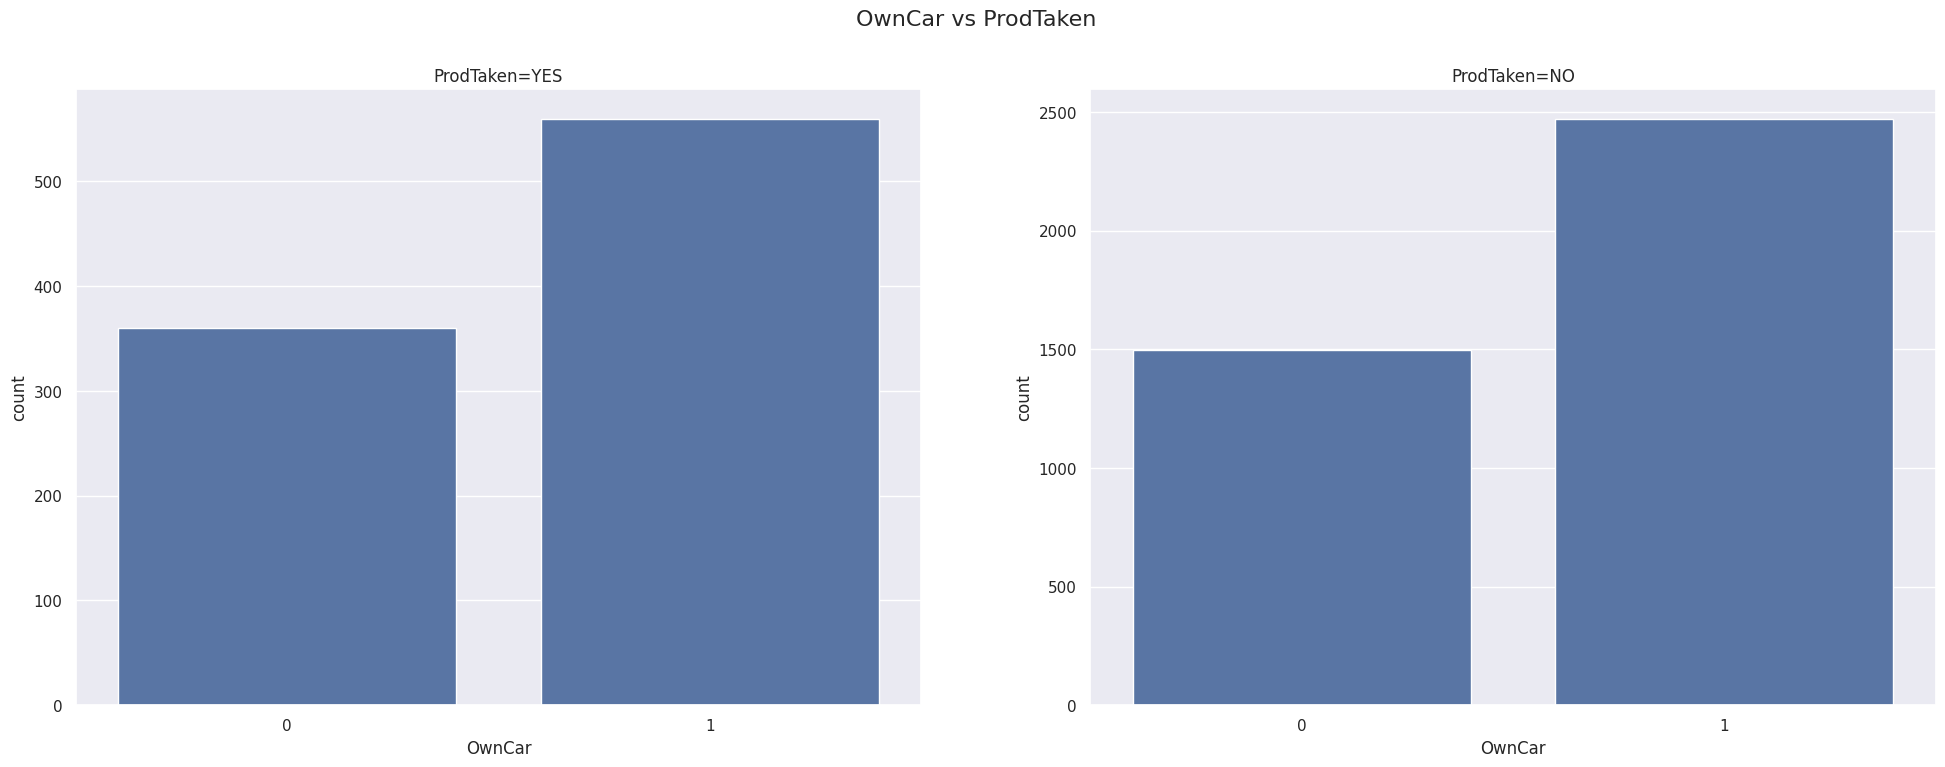

In [115]:
#OwnCar vs ProdTaken
#How are Own Car distributed vs ProdTaken=Yes, and ProdTaken=No
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24,8))
fig.suptitle('OwnCar vs ProdTaken', fontsize=16)

sns.countplot(data=PT_yes, x='OwnCar', ax=ax1)
ax1.title.set_text('ProdTaken=YES')

sns.countplot(data=PT_no, x='OwnCar', ax=ax2)
ax2.title.set_text('ProdTaken=NO')

plt.show()

Most customers that purchase a package have cars but this is not determinant.

**NumberOfChildrenVisiting vs ProdTaken**

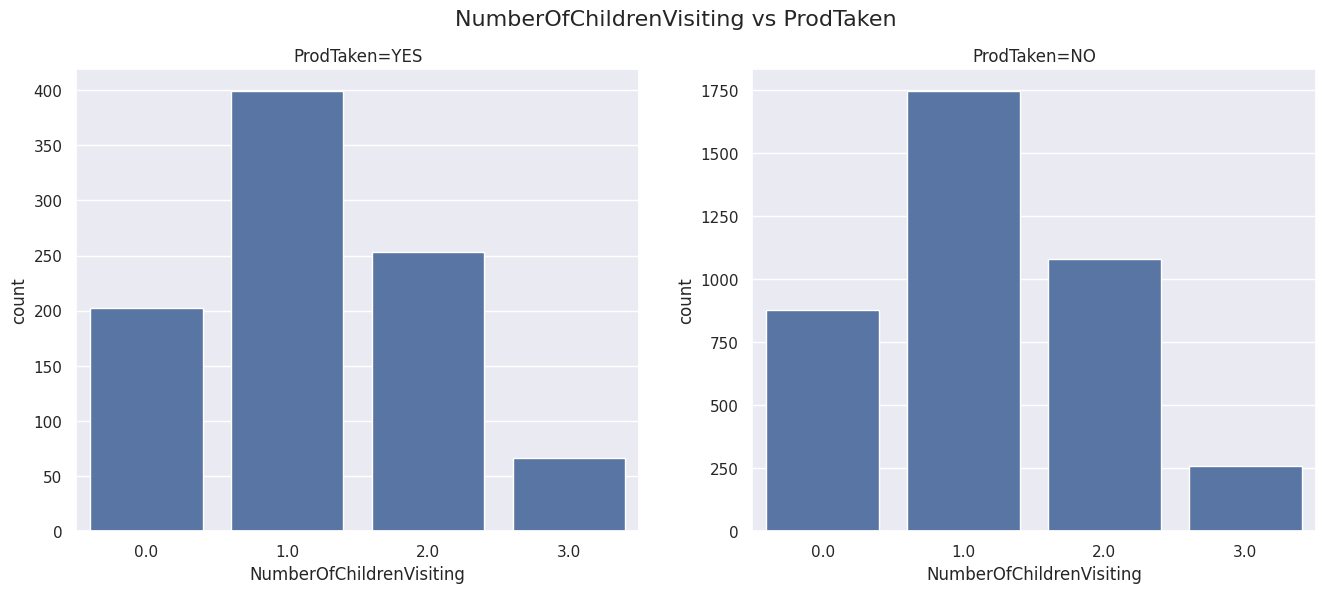

In [116]:
#How are NumberOfChildrenVisiting  affected by ProdTaken Yes/No
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
fig.suptitle('NumberOfChildrenVisiting vs ProdTaken', fontsize=16)

sns.countplot(data=PT_yes, x='NumberOfChildrenVisiting', ax=ax1)
ax1.title.set_text('ProdTaken=YES')

sns.countplot(data=PT_no, x='NumberOfChildrenVisiting', ax=ax2)
ax2.title.set_text('ProdTaken=NO')

plt.show()

Most customers purchasing a package have one children under five but this is not determinant.

**NumberofChildrenVisiting vs NumberOfFollowups**

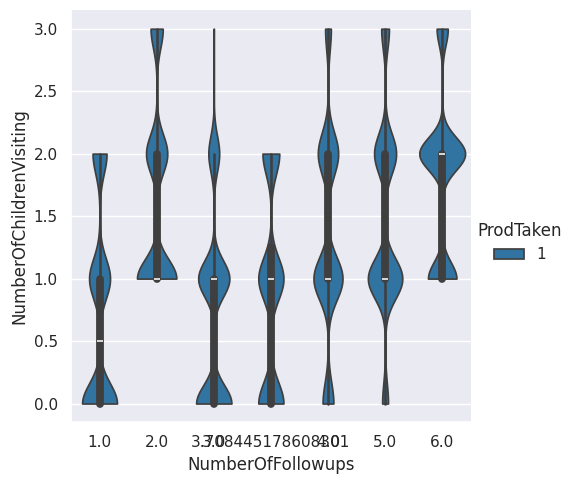

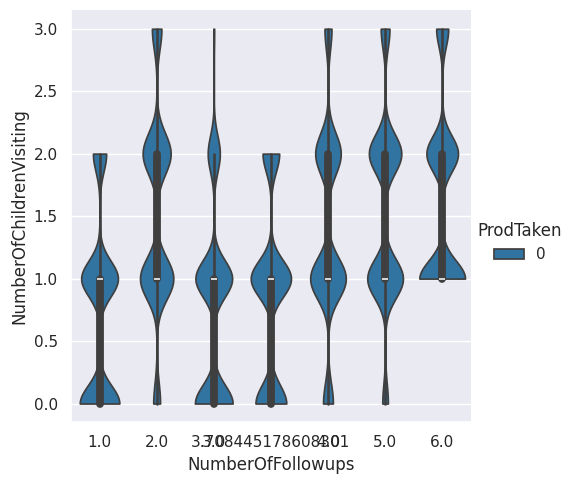

In [117]:
#How about NumberOfFollowups and NumberOfChildrenVisiting

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,5))
fig.suptitle('Number of Followups vs NumberOfChildrenVisiting')


sns.catplot(ax=axes[0], x="NumberOfFollowups", y="NumberOfChildrenVisiting",
            hue="ProdTaken",data=PT_yes, orient="v", height=5, aspect=1,
            palette="tab10", kind="violin", dodge=True, cut=0, bw=.2)
axes[0].set_title('ProdTaken=YES')


sns.catplot(ax=axes[1],x="NumberOfFollowups", y="NumberOfChildrenVisiting",hue="ProdTaken",data=PT_no,
            orient="v", height=5, aspect=1, palette="tab10", kind="violin", dodge=True, cut=0, bw=.2)
axes[1].set_title('ProdTaken=NO')

plt.close(0)
plt.close(1)
plt.show()

**MonthlyIncome vs ProdTaken**

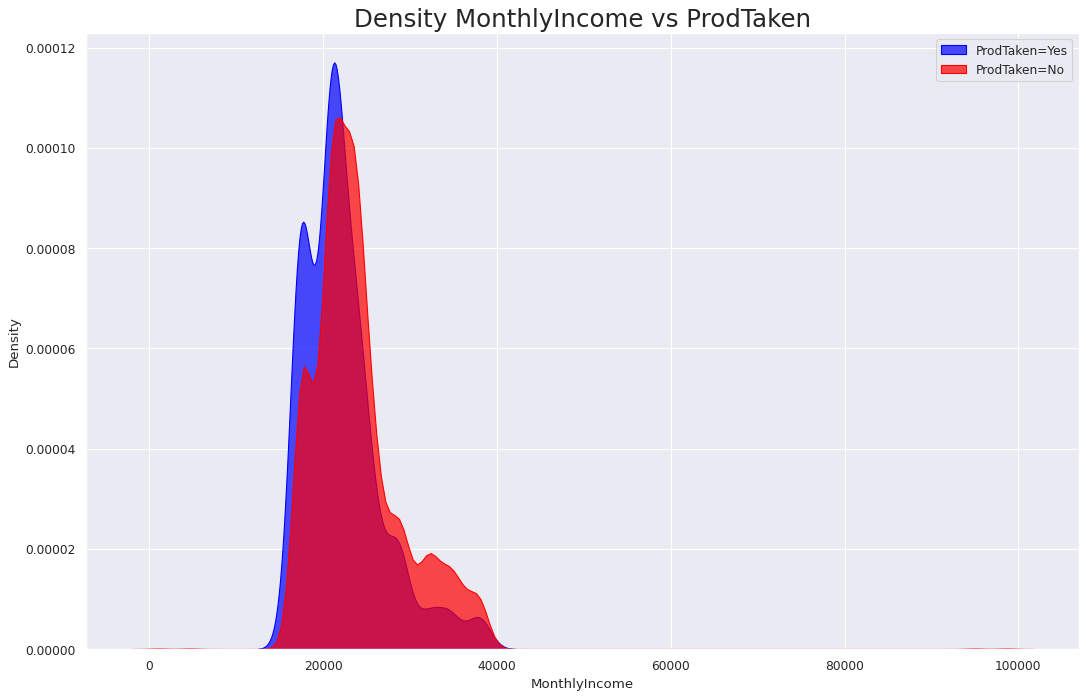

In [118]:
plt.figure(figsize=(16,10), dpi= 80)
sns.kdeplot(PT_yes['MonthlyIncome'], shade=True, color="blue", label="ProdTaken=Yes", alpha=.7)
sns.kdeplot(PT_no['MonthlyIncome'], shade=True, color="red", label="ProdTaken=No", alpha=.7)

# Decoration
plt.title('Density MonthlyIncome vs ProdTaken', fontsize=22)
plt.legend()
plt.show()

Most customers that purchased a package were earning around 17K to 25K monthly.

**NumberOfFollowups ve ProdTaken**

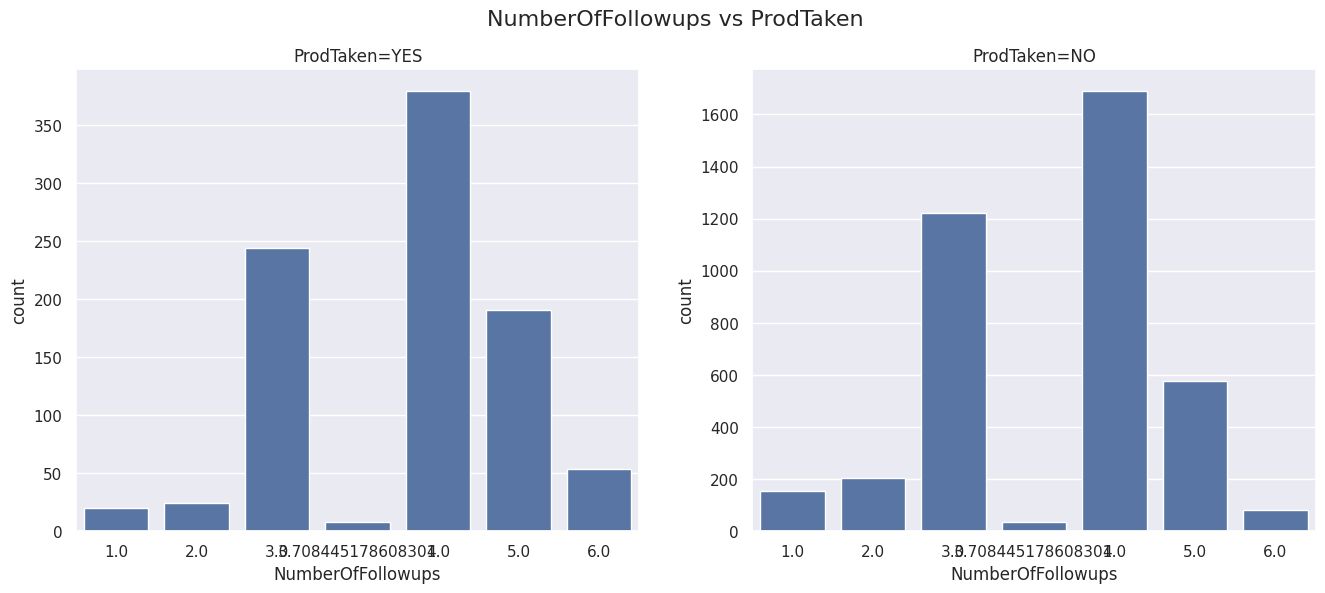

In [119]:
#How are NumberOfFollowups affected by ProdTaken Yes/No
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
fig.suptitle('NumberOfFollowups vs ProdTaken', fontsize=16)

sns.countplot(data=PT_yes, x='NumberOfFollowups', ax=ax1)
ax1.title.set_text('ProdTaken=YES')

sns.countplot(data=PT_no, x='NumberOfFollowups', ax=ax2)
ax2.title.set_text('ProdTaken=NO')

plt.show()

Most followups that were 5, 4 and 3 yielded a sale. But this may not be determinant because similar percentages didn't end in a sale.

**PitchSatisfactionScore vs ProdTaken**

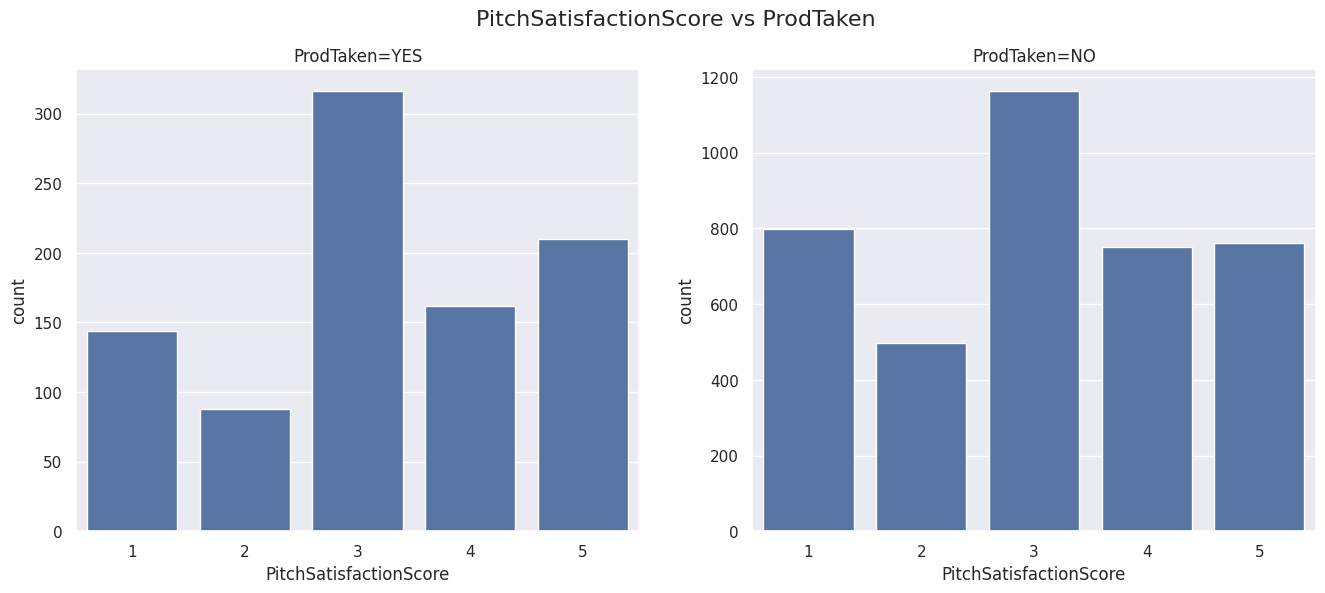

In [120]:
#How are PitchSatisfactionScore affected by ProdTaken Yes/No
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
fig.suptitle('PitchSatisfactionScore vs ProdTaken', fontsize=16)

sns.countplot(data=PT_yes, x='PitchSatisfactionScore', ax=ax1)
ax1.title.set_text('ProdTaken=YES')

sns.countplot(data=PT_no, x='PitchSatisfactionScore', ax=ax2)
ax2.title.set_text('ProdTaken=NO')

plt.show()

Since not selling a package can always end in a future sale, this is important. Satisfaction score was average around 3.

**ProductPitched vs ProdTaken**

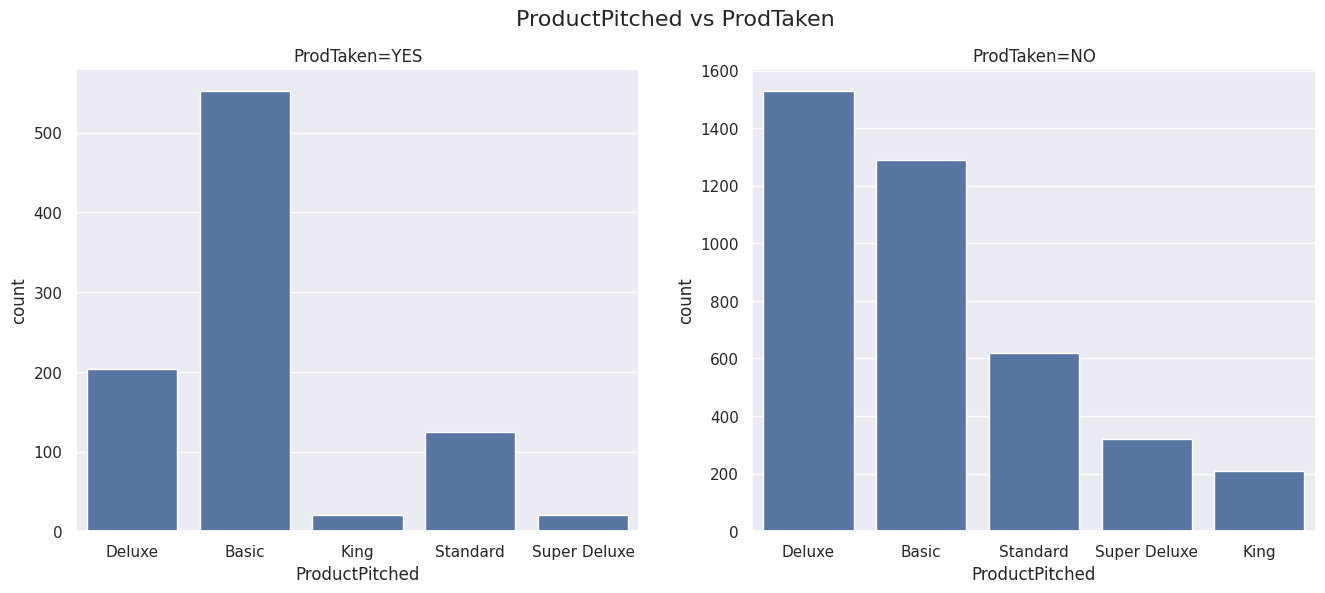

In [121]:
#How are ProductPitched affected by ProdTaken Yes/No
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
fig.suptitle('ProductPitched vs ProdTaken', fontsize=16)

sns.countplot(data=PT_yes, x='ProductPitched', ax=ax1)
ax1.title.set_text('ProdTaken=YES')

sns.countplot(data=PT_no, x='ProductPitched', ax=ax2)
ax2.title.set_text('ProdTaken=NO')

plt.show()

Basic Package was the most purchased. Deluxe package was the most rejected.

**DurationOfPitch vs ProdTaken**

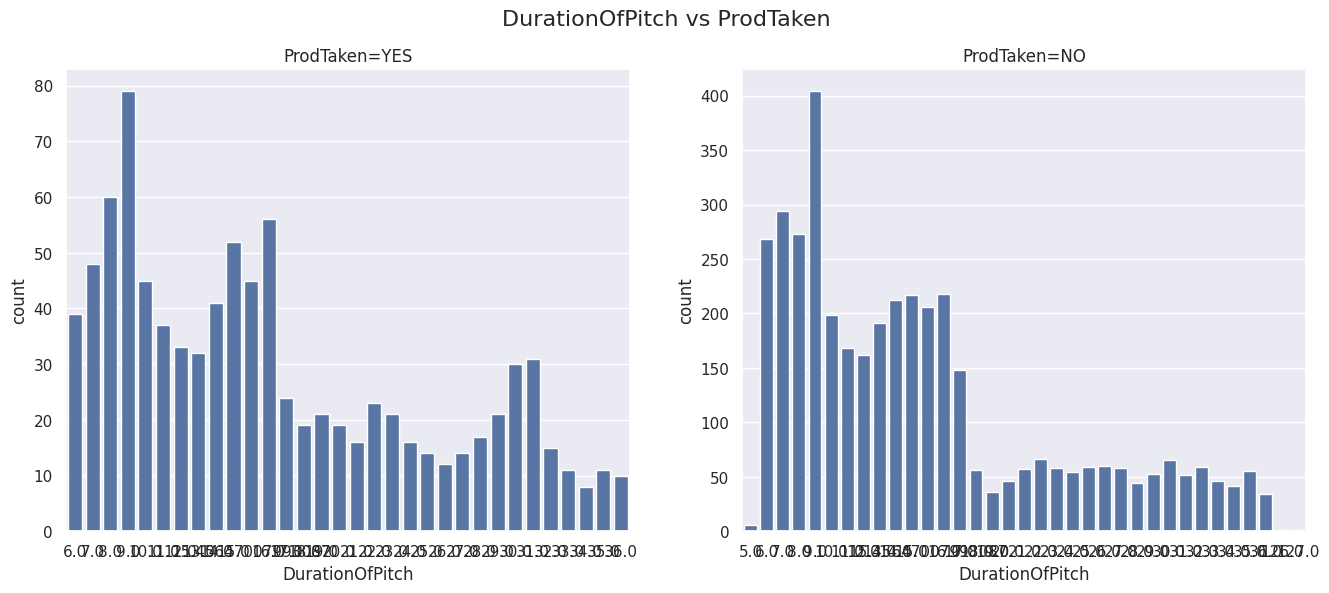

In [122]:
#How are DurationOfPitch affected by ProdTaken Yes/No
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
fig.suptitle('DurationOfPitch vs ProdTaken', fontsize=16)

sns.countplot(data=PT_yes, x='DurationOfPitch', ax=ax1)
ax1.title.set_text('ProdTaken=YES')

sns.countplot(data=PT_no, x='DurationOfPitch', ax=ax2)
ax2.title.set_text('ProdTaken=NO')

plt.show()

Pitches lasting between 5 to 10 minutes yielded better results.

### **Categorical** Features to Numerical Features

Now we will change all categorical features to numerical using dummies

In [123]:
#We will make a copy to use to develop our models
vu_Tourism_df = vu_Tourism.copy()

In [124]:
#convert Categorical features to Numerical
vu_Tourism_df = pd.get_dummies(vu_Tourism_df, columns= ['Gender'], drop_first=True)
vu_Tourism_df = pd.get_dummies(vu_Tourism_df, columns= ['Occupation'])
vu_Tourism_df = pd.get_dummies(vu_Tourism_df, columns= ['TypeofContact'], drop_first=True)
vu_Tourism_df = pd.get_dummies(vu_Tourism_df, columns= ['MaritalStatus'])
vu_Tourism_df = pd.get_dummies(vu_Tourism_df, columns= ['Designation'])
vu_Tourism_df = pd.get_dummies(vu_Tourism_df, columns= ['ProductPitched'])

In [125]:
vu_Tourism_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4888 entries, 0 to 4887
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ProdTaken                    4888 non-null   int64  
 1   Age                          4888 non-null   float64
 2   CityTier                     4888 non-null   int64  
 3   DurationOfPitch              4888 non-null   float64
 4   NumberOfPersonVisiting       4888 non-null   int64  
 5   NumberOfFollowups            4888 non-null   float64
 6   PreferredPropertyStar        4888 non-null   float64
 7   NumberOfTrips                4888 non-null   float64
 8   Passport                     4888 non-null   int64  
 9   PitchSatisfactionScore       4888 non-null   int64  
 10  OwnCar                       4888 non-null   int64  
 11  NumberOfChildrenVisiting     4888 non-null   float64
 12  MonthlyIncome                4888 non-null   float64
 13  Gender_Male       

There are no more categorical values.

##**Modeling**

**What should the model identify well?**

The model should identify the customers that are most likely to buy a Package (in this case, the new Wellness package).  Since resources are always scarce, the ML model should perform better than a human model, the model to adopt must yield a better rate between ProdTaken Yes related to the total number of customers.

###**Data Preparation for model Building**

In [126]:
# Separating features and the target column
X = vu_Tourism_df.drop('ProdTaken', axis=1)
y = vu_Tourism_df['ProdTaken']

In [127]:
# Splitting the data into train and test sets in 70:30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1, shuffle=True)

In [128]:
X_train.shape, X_test.shape

((3421, 32), (1467, 32))

### **Decision** Tree Classifier

In [129]:
dtc_estimator = DecisionTreeClassifier(random_state=1)
dtc_estimator.fit(X_train,y_train)

DecisionTreeClassifier(random_state=1)

In [130]:
dtc_estimator_score=get_metrics_score(dtc_estimator)

Accuracy on training set :  1.0
Accuracy on test set :  0.9161554192229039
Recall on training set :  1.0
Recall on test set :  0.7601351351351351
Precision on training set :  1.0
Precision on test set :  0.8122743682310469


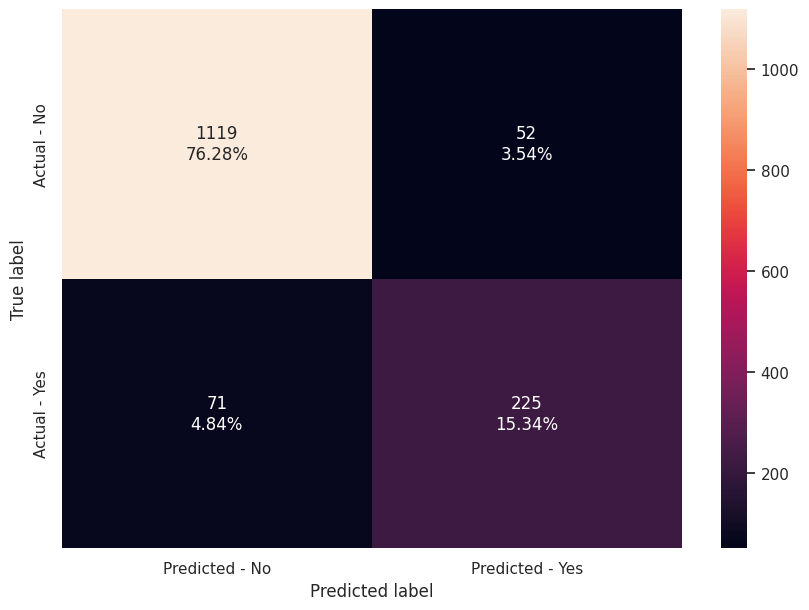

In [131]:
make_confusion_matrix(dtc_estimator,y_test)

Notice that the DecisionTree classifier identified 225 Yes out of 296: it missed roughly 23% of Yes which is not very good. It also misidentified 52 No out of 1171, which is good.

### **Bagging Classifier**

In [132]:
#base_estimator for bagging classifier is a decision tree by default
bagging_estimator=BaggingClassifier(random_state=1)
bagging_estimator.fit(X_train,y_train)

BaggingClassifier(random_state=1)

In [133]:
#Using above defined function to get accuracy, recall and precision on train and test set
bagging_estimator_score=get_metrics_score(bagging_estimator)

Accuracy on training set :  0.9944460684010523
Accuracy on test set :  0.9079754601226994
Recall on training set :  0.9711538461538461
Recall on test set :  0.6148648648648649
Precision on training set :  0.9983525535420099
Precision on test set :  0.896551724137931


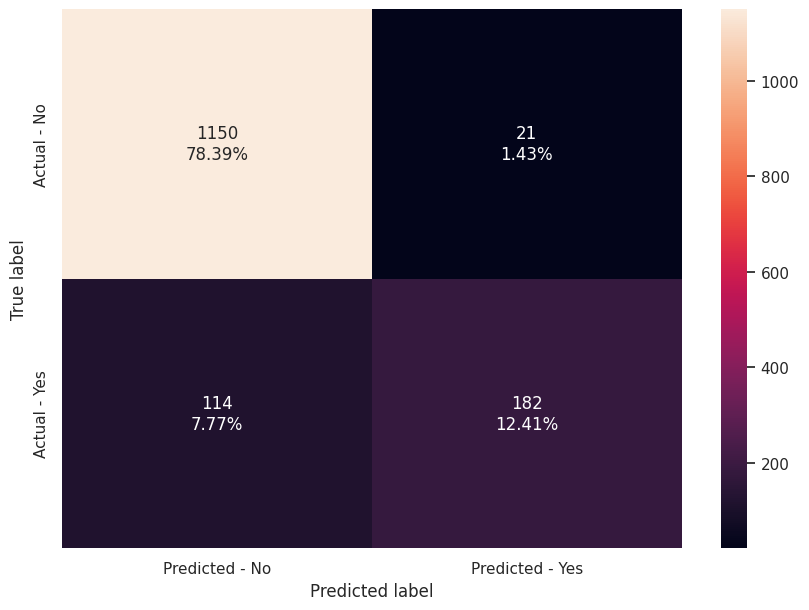

In [134]:
make_confusion_matrix(bagging_estimator,y_test)

Notice that the Bagging classifier identified 182 Yes out of 296: it missed roughly 38% of Yes which is bad.

### **Random Forest Classifier**

In [135]:
#Train the random forest classifier
rf_estimator=RandomForestClassifier(random_state=1)
rf_estimator.fit(X_train,y_train)

RandomForestClassifier(random_state=1)

In [136]:
#Using above defined function to get accuracy, recall and precision on train and test set
rf_estimator_score=get_metrics_score(rf_estimator)

Accuracy on training set :  1.0
Accuracy on test set :  0.896387184730743
Recall on training set :  1.0
Recall on test set :  0.5236486486486487
Precision on training set :  1.0
Precision on test set :  0.9337349397590361


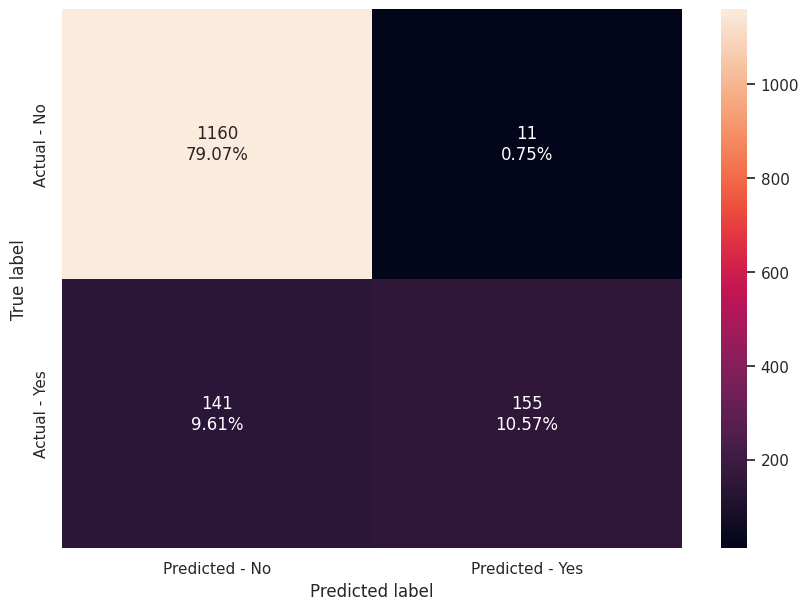

In [137]:
make_confusion_matrix(rf_estimator,y_test)

Notice that the RandomForest classifier identified 155 Yes out of 296: it missed roughly 47% of Yes, which is very bad.

### **Comparison of Models**

In [138]:
labels_metrics = np.array(['Accuracy Train','Accuracy Test','Recall Train','Recall Test','Precision Train','Precision Test'])
label_ensemble_model = np.array(['Bagging','DecisionTreeClassifier','ForestTreeClassifier'])

In [139]:
BDTRF_model_metrics =np.array([bagging_estimator_score,dtc_estimator_score,rf_estimator_score])

In [140]:
BDTRF_metrics_df = pd.DataFrame(BDTRF_model_metrics, columns =[labels_metrics], index=[label_ensemble_model])
BDTRF_metrics_df

Accuracy Train Accuracy Test Recall Train Recall Test  \
Bagging                      0.994446      0.907975     0.971154    0.614865   
DecisionTreeClassifier       1.000000      0.916155     1.000000    0.760135   
ForestTreeClassifier         1.000000      0.896387     1.000000    0.523649   

                       Precision Train Precision Test  
Bagging                       0.998353       0.896552  
DecisionTreeClassifier        1.000000       0.812274  
ForestTreeClassifier          1.000000       0.933735

DecisionTreeClassifier is overfitting. This can be concluded from looking at Accuracy and Recall. Notice that while the train accuracy is 1.0, the test accuracy is at only 0.91. The train recall is again 1.0 and the test recall is at 0.76. The large differences in error indicate that the model is Overfitting.

ForestTreeClassifier is Overfitting. This can be concluded from looking at Accuracy and Recall. Notice that while the train accuracy is 1.0 and the test accuracy is also 1.0 (may indicate underfitting), the train recall is again 1.0 but the test recall is only at 0.56 which is a very large error difference. These large difference point out that the model is Overfitting.

The Bagging model with default parameters (using the default base_estimator = DecisionTree) is also overfitting but not as bad as the other 2 models. The train and test accuracy seem ok but the train and test recall have a large difference (0.97 vs 0.61), which is an indication of overfitting.

Overall, all models are overfitting. The decisionTreeRegressor is giving a better recall than the 2 other models but its Accuracy is the lowest. In terms of Recall, the DecisionTreeRegressor model is giving the best result.

Next we will do tune hyperparameters to try to improve our models.


### **Hyperparameter Tuning**

**Bagging Classifier**

In [141]:
# Choose the type of classifier.
bagging_estimator_tuned = BaggingClassifier(random_state=1)

# Grid of parameters to choose from
## add from article
parameters = {'max_samples': [0.7,0.8,0.9,1],
              'max_features': [0.7,0.8,0.9,1],
              'n_estimators' : [10,20,30,40,50],
             }

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(bagging_estimator_tuned, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
bagging_estimator_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
bagging_estimator_tuned.fit(X_train, y_train)

BaggingClassifier(max_features=0.9, max_samples=0.9, n_estimators=50,
                  random_state=1)

In [142]:
#Using above defined function to get accuracy, recall and precision on train and test set with Hyperparameters
bagging_estimator_tuned_score=get_metrics_score(bagging_estimator_tuned)

Accuracy on training set :  0.9988307512423268
Accuracy on test set :  0.918200408997955
Recall on training set :  0.9935897435897436
Recall on test set :  0.6114864864864865
Precision on training set :  1.0
Precision on test set :  0.9731182795698925


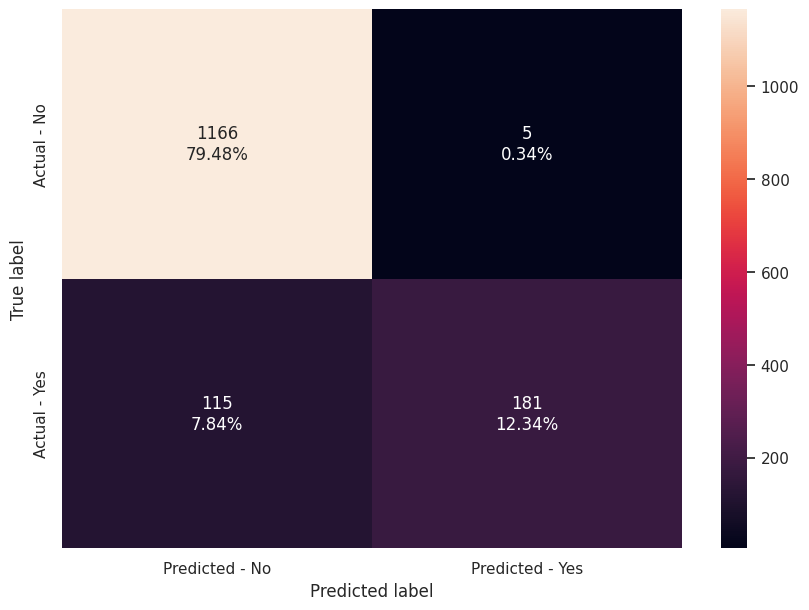

In [143]:
make_confusion_matrix(bagging_estimator_tuned,y_test)

Bagging with hyperparamters didn't perform very well. It predicted 181 Yes correctly, or only 61%.

In [144]:
label_ensemble_model3 = np.array(['Bagging','DecisionTreeClassifier','ForestTreeClassifier','Bagging_estimator_tuned'])
BDTRF_model3_metrics =np.array([bagging_estimator_score,dtc_estimator_score,rf_estimator_score,bagging_estimator_tuned_score])
BDTRF_metrics_df3 = pd.DataFrame(BDTRF_model3_metrics, columns =[labels_metrics], index=[label_ensemble_model3])
BDTRF_metrics_df3

Accuracy Train Accuracy Test Recall Train Recall Test  \
Bagging                       0.994446      0.907975     0.971154    0.614865   
DecisionTreeClassifier        1.000000      0.916155     1.000000    0.760135   
ForestTreeClassifier          1.000000      0.896387     1.000000    0.523649   
Bagging_estimator_tuned       0.998831      0.918200     0.993590    0.611486   

                        Precision Train Precision Test  
Bagging                        0.998353       0.896552  
DecisionTreeClassifier         1.000000       0.812274  
ForestTreeClassifier           1.000000       0.933735  
Bagging_estimator_tuned        1.000000       0.973118

Tuning the Bagging model has increased the train and test accuracy and has slightly improved the recall.The test accuracy has increased from 0.908 to 0.919 and the recall has increased from 0.611 to 0.622.

However, the model continues to overfit as we can see the large difference in error between the train recall and test recall (0.994 to 0.622).

But even then, the confusion matrix shows that the DecisionTreeRegressor model has the highest Recall of all models.  

Next lets use Bagging with logistic regression as the base estimator now to try to improve our Bagging model.

**Bagging with base_estimator = Logistic Regression**

In [145]:
bagging_lr=BaggingClassifier(base_estimator=LogisticRegression(solver='liblinear',random_state=1,max_iter=1000),random_state=1)
bagging_lr.fit(X_train,y_train)

BaggingClassifier(base_estimator=LogisticRegression(max_iter=1000,
                                                    random_state=1,
                                                    solver='liblinear'),
                  random_state=1)

In [146]:
#Using above defined function to get accuracy, recall and precision on train and test set
bagging_lr_score=get_metrics_score(bagging_lr)

Accuracy on training set :  0.8254896229172757
Accuracy on test set :  0.8070892978868439
Recall on training set :  0.052884615384615384
Recall on test set :  0.0472972972972973
Precision on training set :  0.8461538461538461
Precision on test set :  0.9333333333333333


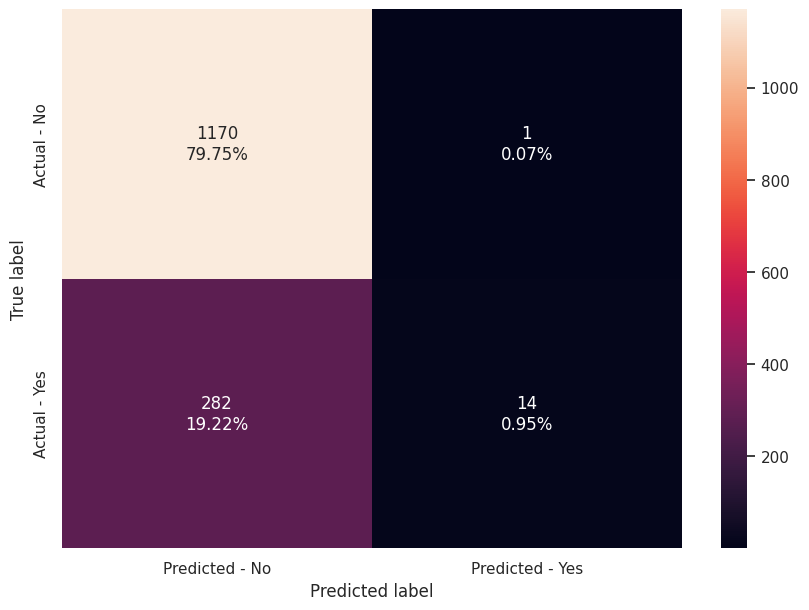

In [147]:
make_confusion_matrix(bagging_lr,y_test)

The model performed very badly.

In [148]:
label_ensemble_model4 = np.array(['Bagging','DecisionTreeClassifier','ForestTreeClassifier','Bagging_estimator_tuned','Bagging_LogisticReg'])
BDTRF_model4_metrics =np.array([bagging_estimator_score,dtc_estimator_score,rf_estimator_score,bagging_estimator_tuned_score,bagging_lr_score])
BDTRF_metrics_df4 = pd.DataFrame(BDTRF_model4_metrics, columns =[labels_metrics], index=[label_ensemble_model4])
BDTRF_metrics_df4

Accuracy Train Accuracy Test Recall Train Recall Test  \
Bagging                       0.994446      0.907975     0.971154    0.614865   
DecisionTreeClassifier        1.000000      0.916155     1.000000    0.760135   
ForestTreeClassifier          1.000000      0.896387     1.000000    0.523649   
Bagging_estimator_tuned       0.998831      0.918200     0.993590    0.611486   
Bagging_LogisticReg           0.825490      0.807089     0.052885    0.047297   

                        Precision Train Precision Test  
Bagging                        0.998353       0.896552  
DecisionTreeClassifier         1.000000       0.812274  
ForestTreeClassifier           1.000000       0.933735  
Bagging_estimator_tuned        1.000000       0.973118  
Bagging_LogisticReg            0.846154       0.933333

The accuracy and recall for Bagging using LogisticRegression is not overfitting. Compare the train/test accuracy and train/test recall and they are similar.  

However, the recall is really bad. Therefore, this model doesn't perform well at all.

Ensemble models are less intepretable than decision tree but bagging classifier is even less interpretable of the three models introduced in this section.

**Random Forest Classifier Tuning**

In [149]:
# Choose the type of classifier.
rf_estimator_tuned = RandomForestClassifier(random_state=1)

# Grid of parameters to choose from
## add from article
parameters = {"n_estimators": [150,200,250],
    "min_samples_leaf": np.arange(5, 10),
    "max_features": np.arange(0.2, 0.7, 0.1),
    "max_samples": np.arange(0.3, 0.7, 0.1),
             }

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(rf_estimator_tuned, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
rf_estimator_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
rf_estimator_tuned.fit(X_train, y_train)

RandomForestClassifier(max_features=0.6000000000000001,
                       max_samples=0.6000000000000001, min_samples_leaf=5,
                       n_estimators=150, random_state=1)

In [150]:
#Using above defined function to get accuracy, recall and precision on train and test set
rf_estimator_tuned_score=get_metrics_score(rf_estimator_tuned)

Accuracy on training set :  0.9125986553639287
Accuracy on test set :  0.8534423994546694
Recall on training set :  0.5544871794871795
Recall on test set :  0.3547297297297297
Precision on training set :  0.9427792915531336
Precision on test set :  0.813953488372093


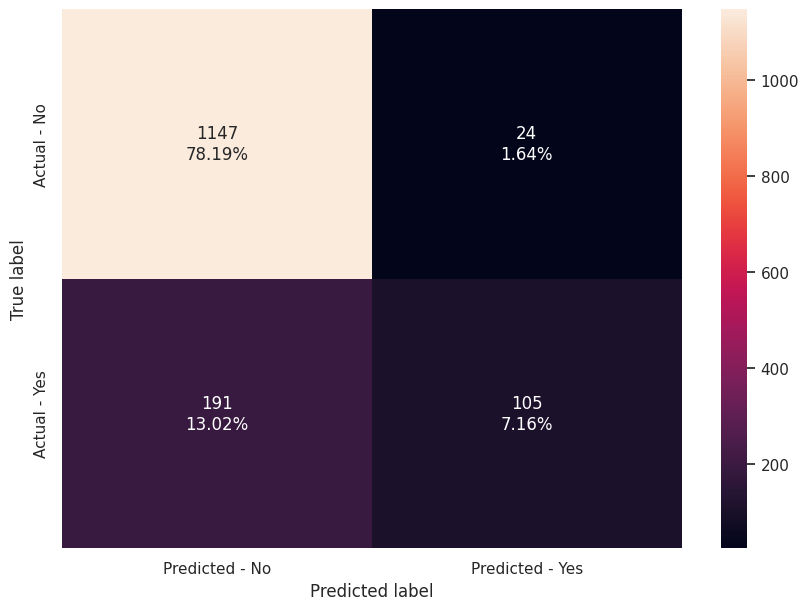

In [151]:
make_confusion_matrix(rf_estimator_tuned,y_test)

RandomForest tuned model predicted 110 actual yes out of 296. This is not good.

In [152]:
label_ensemble_model5 = np.array(['Bagging','DecisionTreeClassifier','ForestTreeClassifier','Bagging_estimator_tuned','Bagging_LogisticReg','ForestTree_Tuned'])
BDTRF_model5_metrics = np.array([bagging_estimator_score,dtc_estimator_score,rf_estimator_score,bagging_estimator_tuned_score,bagging_lr_score,rf_estimator_tuned_score])
BDTRF_metrics_df5 = pd.DataFrame(BDTRF_model5_metrics, columns =[labels_metrics], index=[label_ensemble_model5])
BDTRF_metrics_df5

Accuracy Train Accuracy Test Recall Train Recall Test  \
Bagging                       0.994446      0.907975     0.971154    0.614865   
DecisionTreeClassifier        1.000000      0.916155     1.000000    0.760135   
ForestTreeClassifier          1.000000      0.896387     1.000000    0.523649   
Bagging_estimator_tuned       0.998831      0.918200     0.993590    0.611486   
Bagging_LogisticReg           0.825490      0.807089     0.052885    0.047297   
ForestTree_Tuned              0.912599      0.853442     0.554487    0.354730   

                        Precision Train Precision Test  
Bagging                        0.998353       0.896552  
DecisionTreeClassifier         1.000000       0.812274  
ForestTreeClassifier           1.000000       0.933735  
Bagging_estimator_tuned        1.000000       0.973118  
Bagging_LogisticReg            0.846154       0.933333  
ForestTree_Tuned               0.942779       0.813953

ForestTree Tuned has a low recall  and also seems overfitted. The model doesn't perform well.

**Random Forest and class_weights**

We will use class_weights={0:0.3,1:0.7} because this is the original imbalance in our data (30% test, 70% train)

In [153]:
# Choose the type of classifier.
rf_estimator_weighted = RandomForestClassifier(random_state=1)

# Grid of parameters to choose from
## add from article
parameters = {
    "class_weight": [{0: 0.3, 1: 0.7}],
    "n_estimators": [100,150,200,250],
    "min_samples_leaf": np.arange(5, 10),
    "max_features": np.arange(0.2, 0.7, 0.1),
    "max_samples": np.arange(0.3, 0.7, 0.1),
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(rf_estimator_weighted, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
rf_estimator_weighted = grid_obj.best_estimator_

# Fit the best algorithm to the data.
rf_estimator_weighted.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.3, 1: 0.7},
                       max_features=0.6000000000000001,
                       max_samples=0.6000000000000001, min_samples_leaf=6,
                       random_state=1)

In [154]:
#Using above defined function to get accuracy, recall and precision on train and test set
rf_estimator_weighted_score=get_metrics_score(rf_estimator_weighted)

Accuracy on training set :  0.9196141479099679
Accuracy on test set :  0.8629856850715747
Recall on training set :  0.7387820512820513
Recall on test set :  0.5101351351351351
Precision on training set :  0.8045375218150087
Precision on test set :  0.7294685990338164


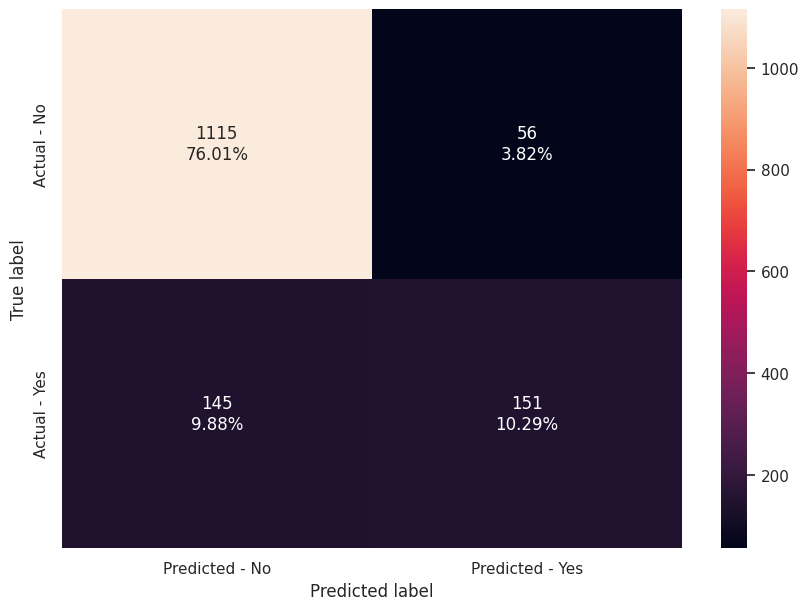

In [155]:
make_confusion_matrix(rf_estimator_weighted,y_test)

RandomForest with class weights didn't fare very well. It only predicted 151 Yes out of 296.

In [156]:
label_ensemble_model6 = np.array(['Bagging','DecisionTreeClassifier','ForestTreeClassifier','Bagging_estimator_tuned','Bagging_LogisticReg','ForestTree_Tuned','ForestTree_Weighted'])
BDTRF_model6_metrics =np.array([bagging_estimator_score,dtc_estimator_score,rf_estimator_score,bagging_estimator_tuned_score,bagging_lr_score,rf_estimator_tuned_score,rf_estimator_weighted_score])
BDTRF_metrics_df6 = pd.DataFrame(BDTRF_model6_metrics, columns =[labels_metrics], index=[label_ensemble_model6])
BDTRF_metrics_df6

Accuracy Train Accuracy Test Recall Train Recall Test  \
Bagging                       0.994446      0.907975     0.971154    0.614865   
DecisionTreeClassifier        1.000000      0.916155     1.000000    0.760135   
ForestTreeClassifier          1.000000      0.896387     1.000000    0.523649   
Bagging_estimator_tuned       0.998831      0.918200     0.993590    0.611486   
Bagging_LogisticReg           0.825490      0.807089     0.052885    0.047297   
ForestTree_Tuned              0.912599      0.853442     0.554487    0.354730   
ForestTree_Weighted           0.919614      0.862986     0.738782    0.510135   

                        Precision Train Precision Test  
Bagging                        0.998353       0.896552  
DecisionTreeClassifier         1.000000       0.812274  
ForestTreeClassifier           1.000000       0.933735  
Bagging_estimator_tuned        1.000000       0.973118  
Bagging_LogisticReg            0.846154       0.933333  
ForestTree_Tuned               0.942779       0.813953  
ForestTree_Weighted            0.804538       0.729469

There is a significant improvement using ForestTree with weights over ForestTree tuned. The train/test recall has improved without overfitting the model. The accuracy has decreased compared to the ForestTreeClassifier model, but that model was overfitting.


But the model that yielded better results was the Decision Tree Classifier, although the model is overfitted.

####Feature Importance

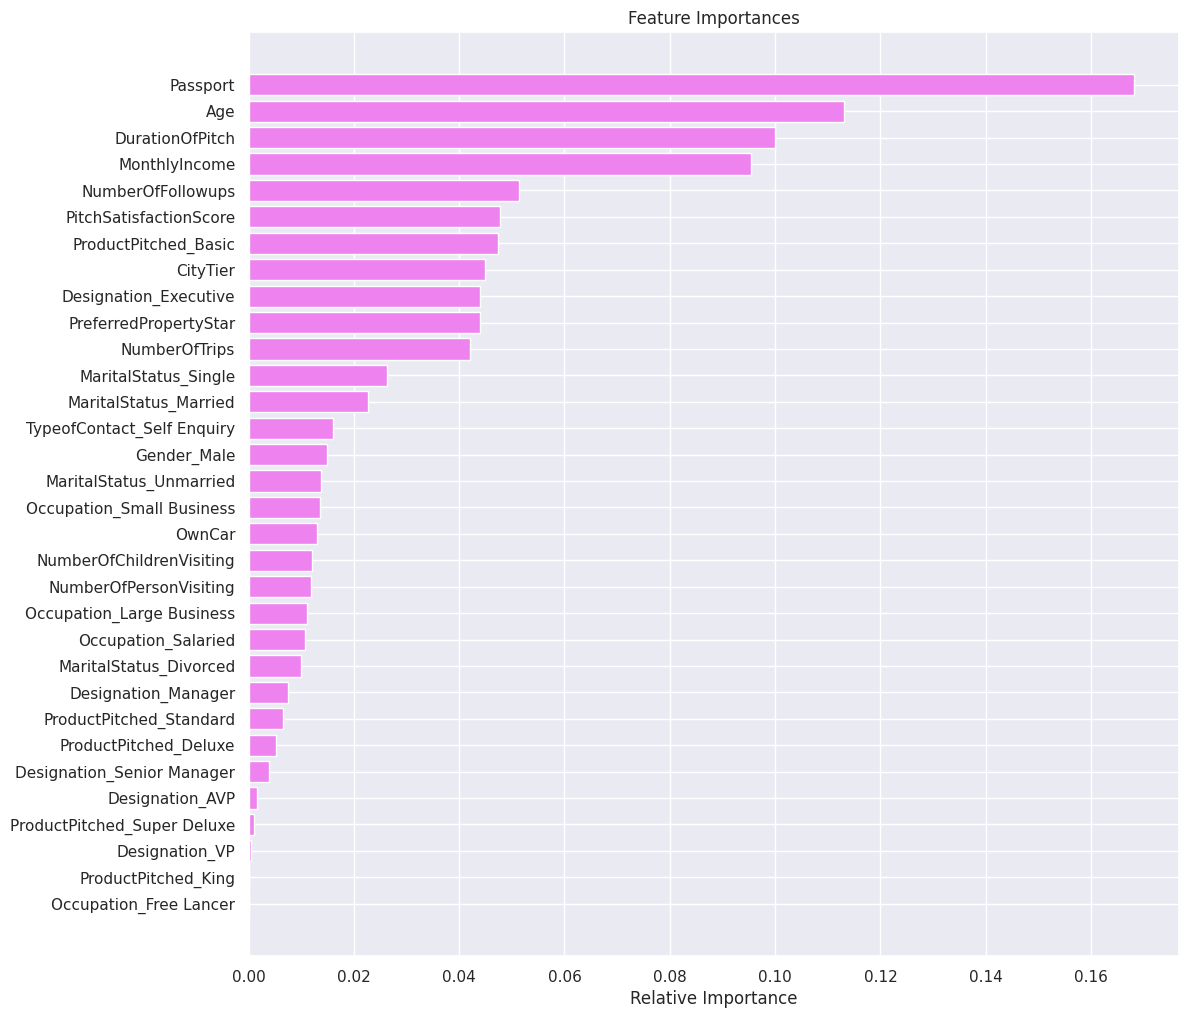

In [157]:
importances = rf_estimator_weighted.feature_importances_
indices = np.argsort(importances)
feature_names = list(X.columns)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Passport, Age, DurationOfPitch, and Monthly Income are Bagging with weights most important features.

### **Boosting**

####**AdaBoost Classifier**

In [158]:
abc = AdaBoostClassifier(random_state=1)
abc.fit(X_train,y_train)

AdaBoostClassifier(random_state=1)

In [159]:
#Using above defined function to get accuracy, recall and precision on train and test set
abc_score=get_metrics_score(abc)

Accuracy on training set :  0.8494592224495762
Accuracy on test set :  0.830947511929107
Recall on training set :  0.3301282051282051
Recall on test set :  0.27702702702702703
Precision on training set :  0.6798679867986799
Precision on test set :  0.7068965517241379


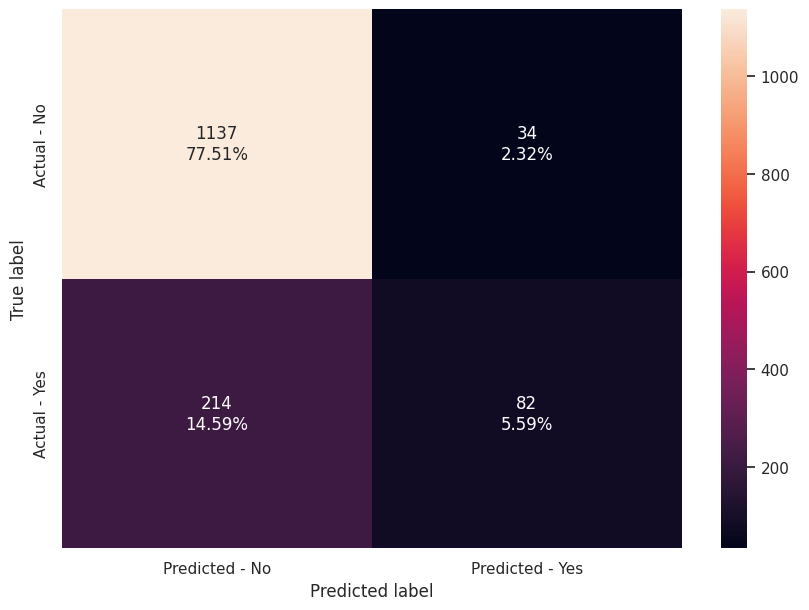

In [160]:
make_confusion_matrix(abc,y_test)

Adaboost doesn't overfit but recall is very low train 0.33 and test 0.28.  

####**Gradient Boosting Classifier**

In [161]:
gbc = GradientBoostingClassifier(random_state=1)
gbc.fit(X_train,y_train)

GradientBoostingClassifier(random_state=1)

In [162]:
#Using above defined function to get accuracy, recall and precision on train and test set
gbc_score=get_metrics_score(gbc)

Accuracy on training set :  0.8892136802104648
Accuracy on test set :  0.8486707566462167
Recall on training set :  0.46955128205128205
Recall on test set :  0.3277027027027027
Precision on training set :  0.8592375366568915
Precision on test set :  0.8083333333333333


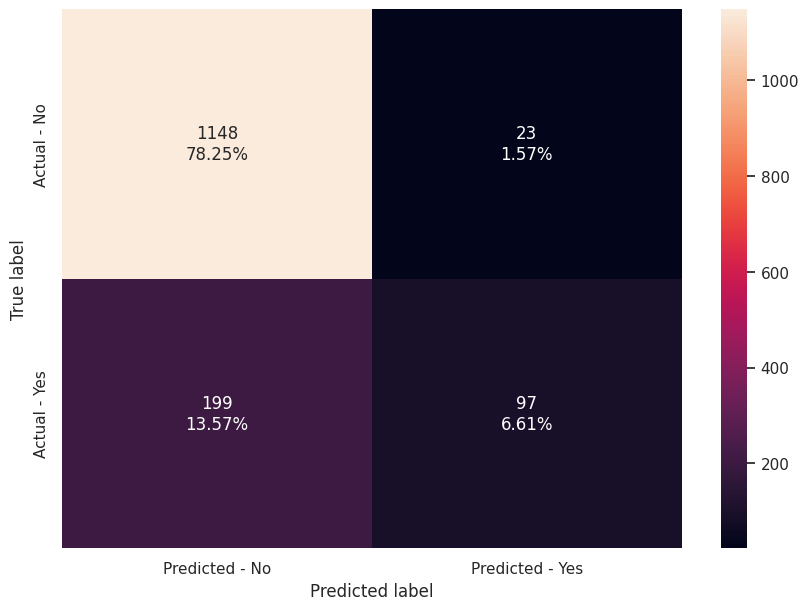

In [163]:
make_confusion_matrix(gbc,y_test)

Gradient boost doesnt overfit but the recall is bad.

####**XGBoost Classifier**

In [164]:
xgb = XGBClassifier(random_state=1,eval_metric='logloss')
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=1, ...)

In [165]:
#Using above defined function to get accuracy, recall and precision on train and test set
xgb_score=get_metrics_score(xgb)

Accuracy on training set :  0.9997076878105817
Accuracy on test set :  0.9222903885480572
Recall on training set :  0.9983974358974359
Recall on test set :  0.668918918918919
Precision on training set :  1.0
Precision on test set :  0.9252336448598131


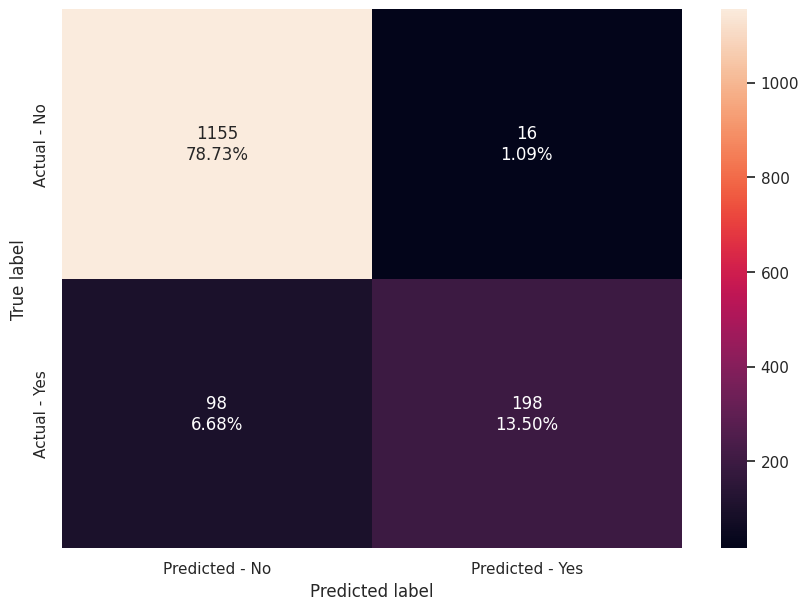

In [166]:
make_confusion_matrix(xgb,y_test)

XGBoost recall is bad.

### **Hyperparameter Tuning**

#####**Adaboot Classifier**

In [167]:
# Choose the type of classifier.
abc_tuned = AdaBoostClassifier(random_state=1)

# Grid of parameters to choose from
## add from article
parameters = {
    #Let's try different max_depth for base_estimator
    "base_estimator":[DecisionTreeClassifier(max_depth=1, random_state=1),DecisionTreeClassifier(max_depth=2, random_state=1),DecisionTreeClassifier(max_depth=3, random_state=1)],
    "n_estimators": np.arange(10,110,10),
    "learning_rate":np.arange(0.1,2,0.1)
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(abc_tuned, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
abc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
abc_tuned.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         random_state=1),
                   learning_rate=1.1, n_estimators=100, random_state=1)

In [168]:
#Using above defined function to get accuracy, recall and precision on train and test set
abc_tuned_score=get_metrics_score(abc_tuned)

Accuracy on training set :  0.9891844489915229
Accuracy on test set :  0.89093387866394
Recall on training set :  0.9567307692307693
Recall on test set :  0.6148648648648649
Precision on training set :  0.9835255354200988
Precision on test set :  0.7982456140350878


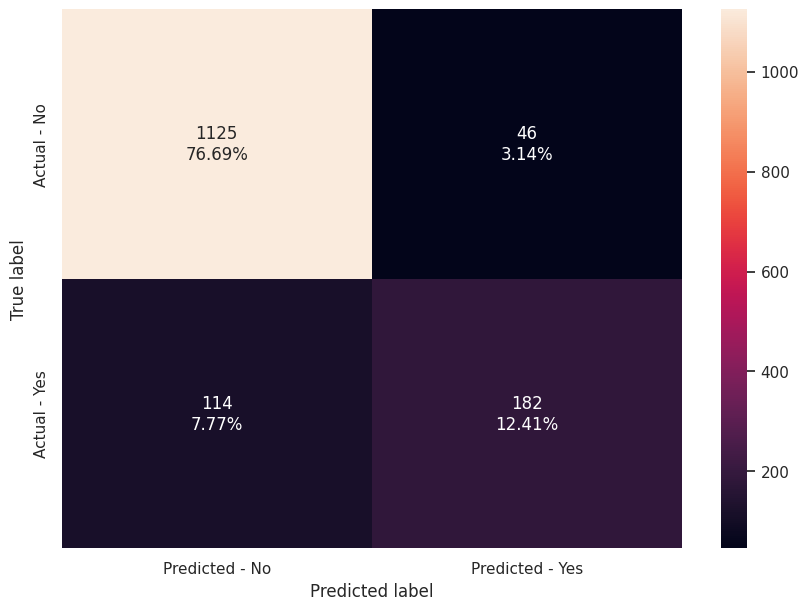

In [169]:
make_confusion_matrix(abc_tuned,y_test)

**Feature Importance**

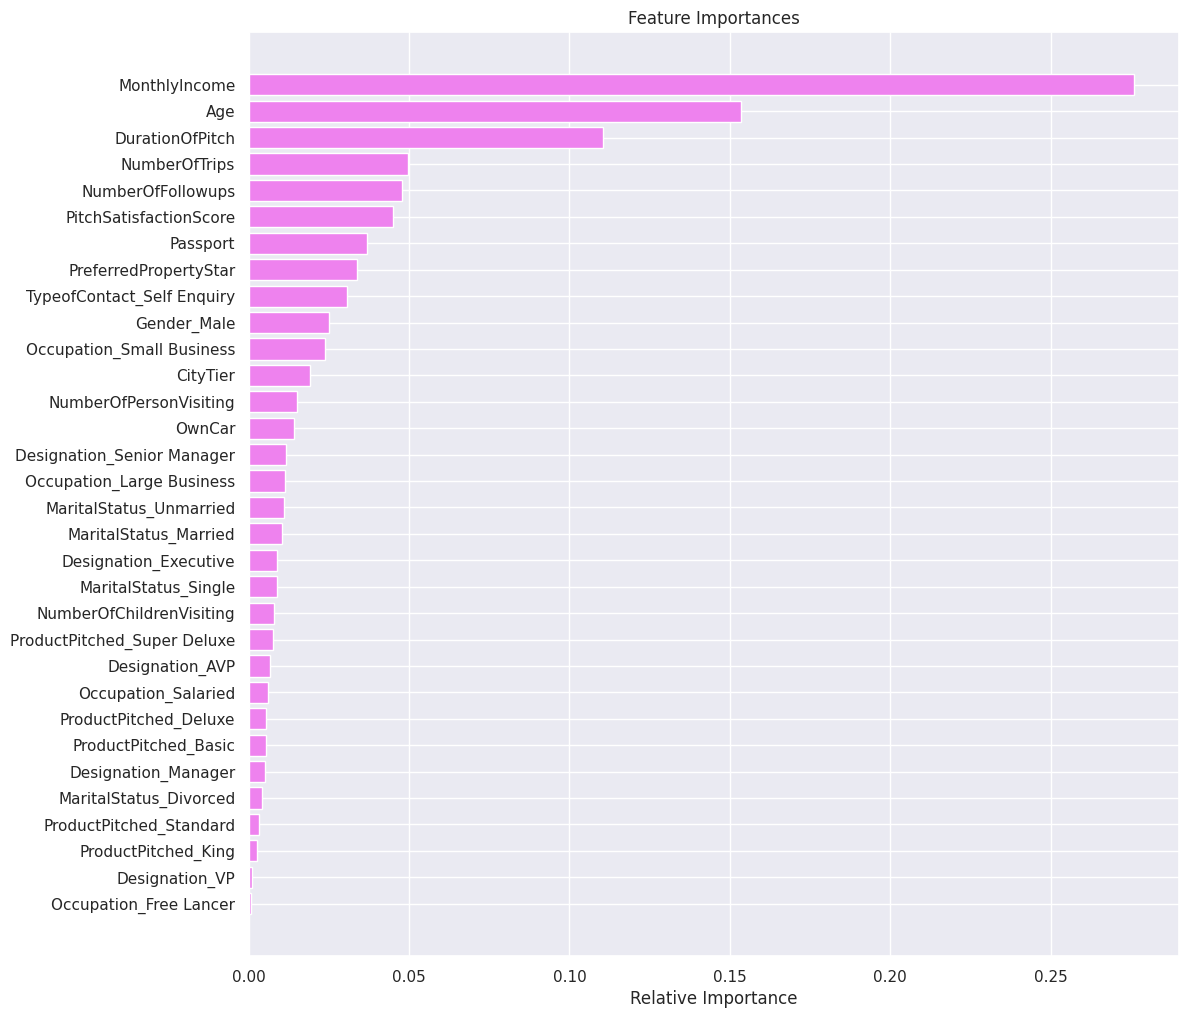

In [170]:
importances = abc_tuned.feature_importances_
indices = np.argsort(importances)
feature_names = list(X.columns)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

MonthlyIncome, Age, DurationOfPitch are the most important features for AdaBoost Classifier-tuned.

**AdaBoostClassifier as the estimator for initial Predictions**

In [171]:
gbc_init = GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),random_state=1)
gbc_init.fit(X_train,y_train)

GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),
                           random_state=1)

In [172]:
#Using above defined function to get accuracy, recall and precision on train and test set
gbc_init_score=get_metrics_score(gbc_init)

Accuracy on training set :  0.8871674948845367
Accuracy on test set :  0.8534423994546694
Recall on training set :  0.46314102564102566
Recall on test set :  0.3547297297297297
Precision on training set :  0.85
Precision on test set :  0.813953488372093


In [173]:
# Choose the type of classifier.
gbc_tuned = GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),random_state=1)

# Grid of parameters to choose from
## add from article
parameters = {
    "n_estimators": [100,150,200,250],
    "subsample":[0.8,0.9,1],
    "max_features":[0.7,0.8,0.9,1]
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(gbc_tuned, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
gbc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
gbc_tuned.fit(X_train, y_train)

GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),
                           max_features=0.9, n_estimators=250, random_state=1,
                           subsample=0.9)

In [174]:
#Using above defined function to get accuracy, recall and precision on train and test set
gbc_tuned_score=get_metrics_score(gbc_tuned)

Accuracy on training set :  0.9286758257819351
Accuracy on test set :  0.880027266530334
Recall on training set :  0.6538461538461539
Recall on test set :  0.47297297297297297
Precision on training set :  0.9357798165137615
Precision on test set :  0.875


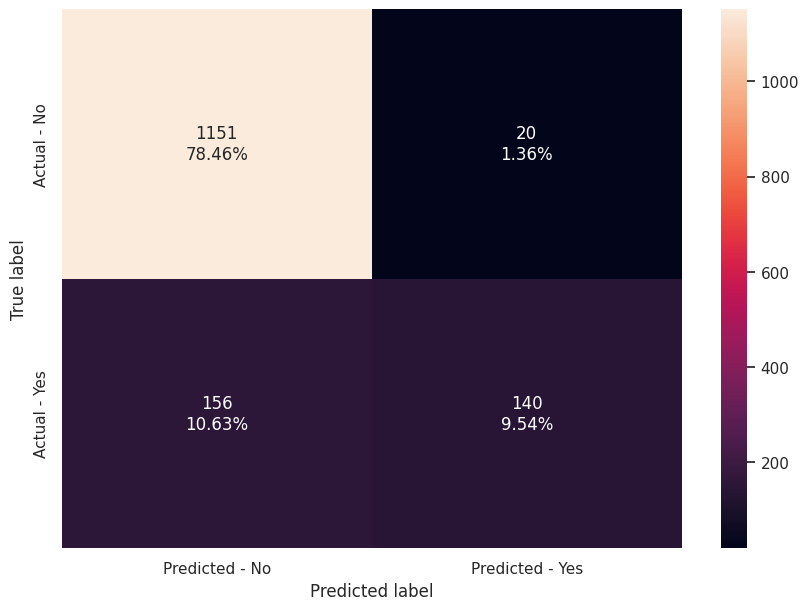

In [175]:
make_confusion_matrix(gbc_tuned,y_test)

Gradient Boosting Classifier tuned didn't overfit but it didn't perfom well (Low Recall).

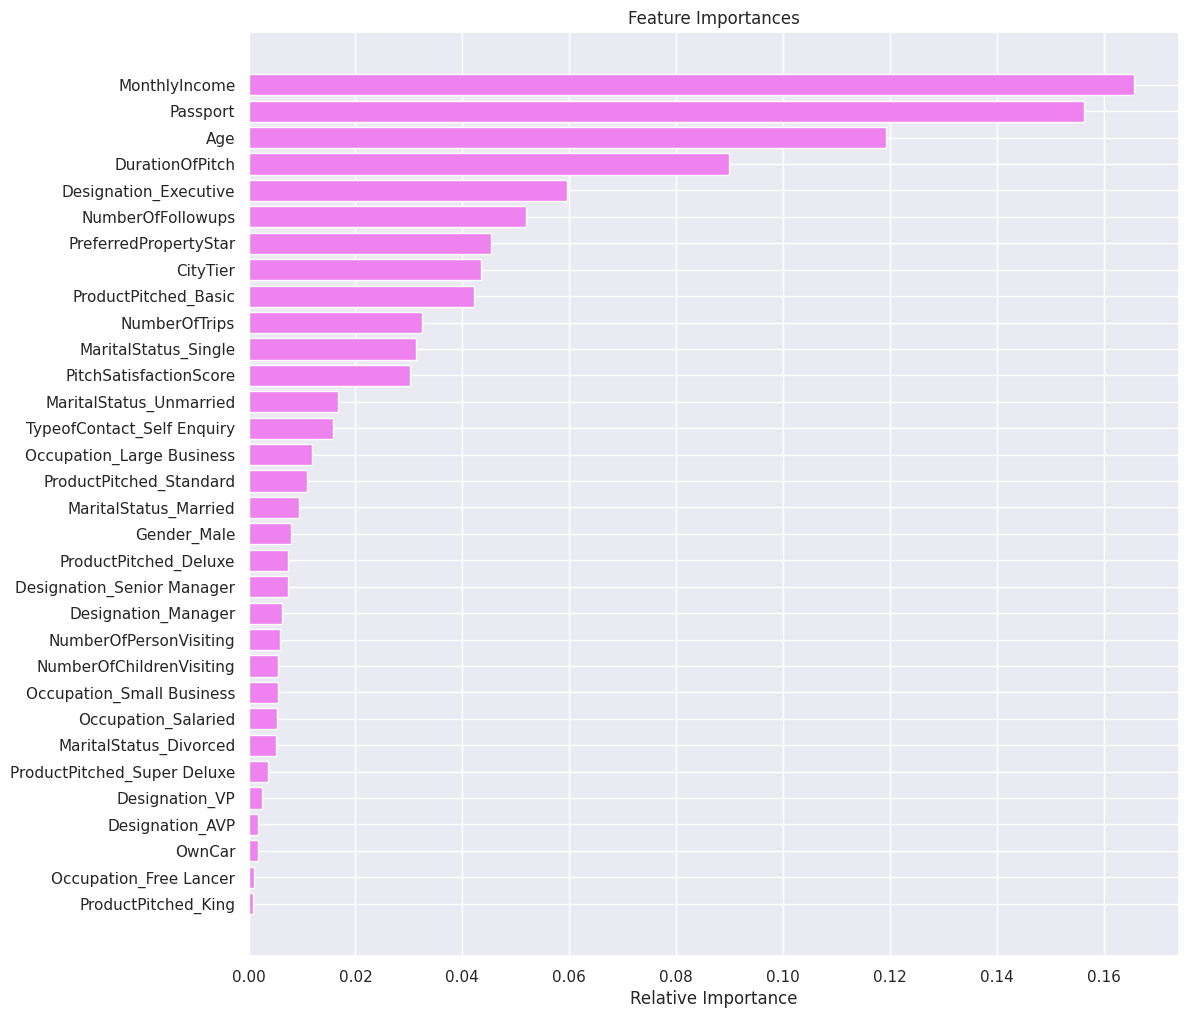

In [176]:
importances = gbc_tuned.feature_importances_
indices = np.argsort(importances)
feature_names = list(X.columns)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

MonthlyIncome, Passport, Age, PitchDuration, Executives, are the most important features.

**Tuning XGBoost Classifier**

In [177]:
# Choose the type of classifier.
xgb_tuned = XGBClassifier(random_state=1,eval_metric='logloss')

# Grid of parameters to choose from
## add from
parameters = {
    "n_estimators": np.arange(10,100,20),
    "scale_pos_weight":[0,1,2,5],
    "subsample":[0.5,0.7,0.9,1],
    "learning_rate":[0.01,0.1,0.2,0.05],
    "gamma":[0,1,3],
    "colsample_bytree":[0.5,0.7,0.9,1],
    "colsample_bylevel":[0.5,0.7,0.9,1]
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(xgb_tuned, parameters,scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
xgb_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
xgb_tuned.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.5, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=3, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=10,
              n_jobs=None, num_parallel_tree=None, random_state=1, ...)

In [178]:
#Using above defined function to get accuracy, recall and precision on train and test set
xgb_tuned_score=get_metrics_score(xgb_tuned)

Accuracy on training set :  0.3095586085939784
Accuracy on test set :  0.3094751192910702
Recall on training set :  0.9983974358974359
Recall on test set :  0.9864864864864865
Precision on training set :  0.20878016085790885
Precision on test set :  0.22444273635664874


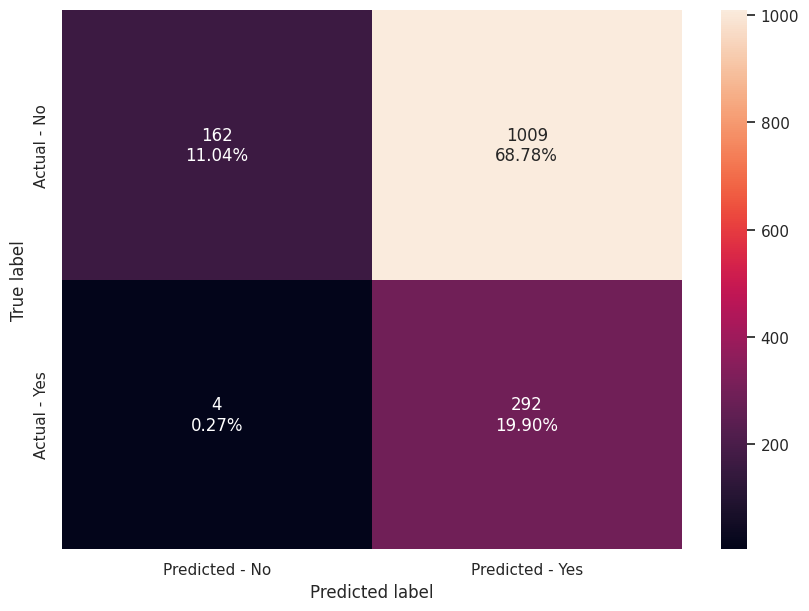

In [179]:
make_confusion_matrix(xgb_tuned,y_test)

XGB Tuned performs better than the other boosting models. It does not overfit but its recall its just okay (train/test 0.81/0.75).

**Feature Importances**

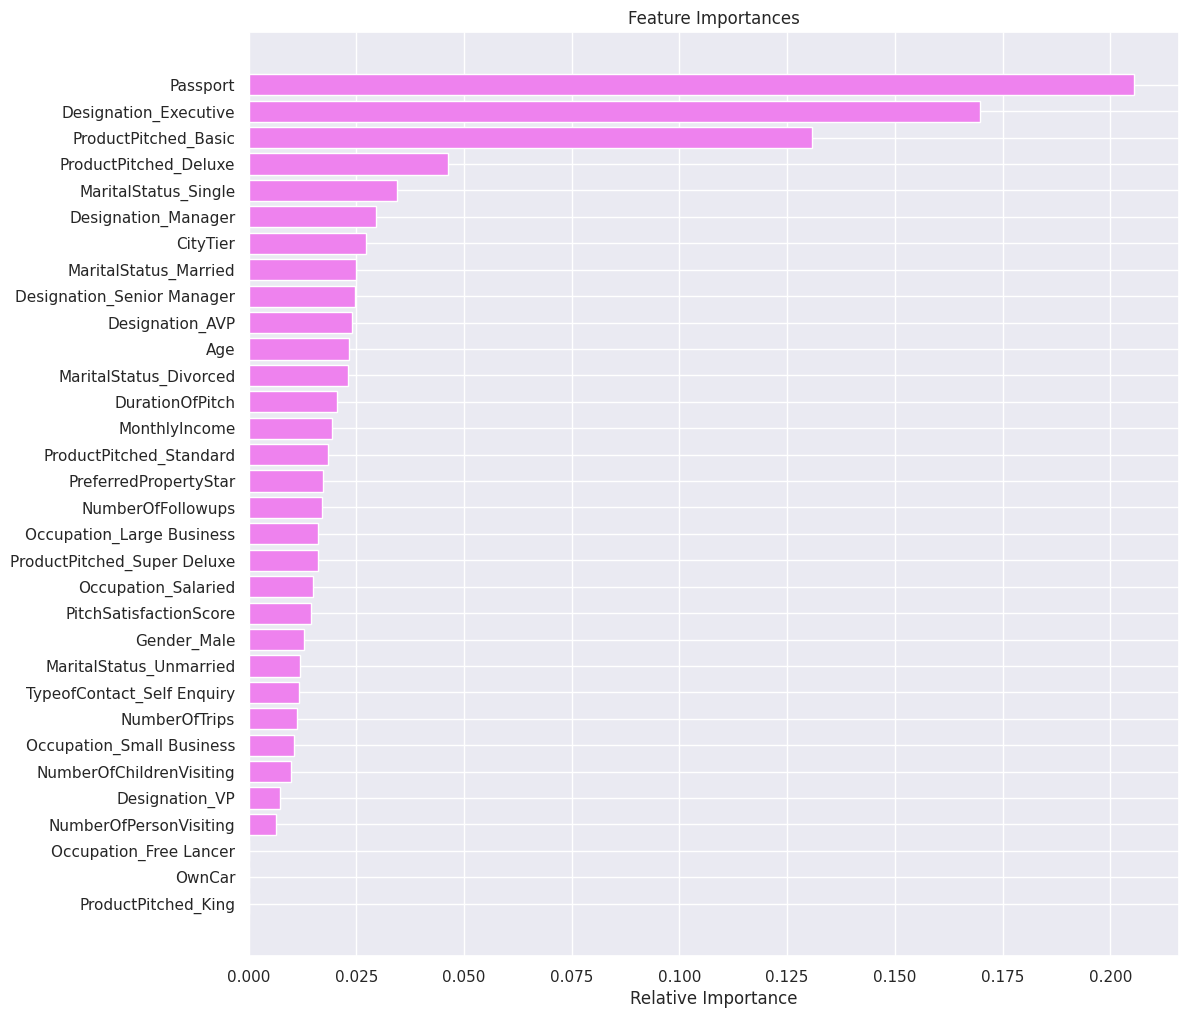

In [180]:
importances = xgb_tuned.feature_importances_
indices = np.argsort(importances)
feature_names = list(X.columns)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Passport is the singlemost important feature.

###**Comparing Models**

In [181]:
# defining list of models
models = [abc, abc_tuned, gbc, gbc_init, gbc_tuned, xgb, xgb_tuned]

# defining empty lists to add train and test results
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []

# looping through all the models to get the accuracy, precall and precision scores
for model in models:
    j = get_metrics_score(model,False)
    acc_train.append(np.round(j[0],2))
    acc_test.append(np.round(j[1],2))
    recall_train.append(np.round(j[2],2))
    recall_test.append(np.round(j[3],2))
    precision_train.append(np.round(j[4],2))
    precision_test.append(np.round(j[5],2))

In [182]:
comparison_frame = pd.DataFrame({'Model':['AdaBoost with default paramters','AdaBoost Tuned',
                                          'Gradient Boosting with default parameters','Gradient Boosting with init=AdaBoost',
                                          'Gradient Boosting Tuned','XGBoost with default parameters','XGBoost Tuned'],
                                          'Train_Accuracy': acc_train,'Test_Accuracy': acc_test,
                                          'Train_Recall':recall_train,'Test_Recall':recall_test,
                                          'Train_Precision':precision_train,'Test_Precision':precision_test})
comparison_frame


Model  Train_Accuracy  Test_Accuracy  \
0            AdaBoost with default paramters            0.85           0.83   
1                             AdaBoost Tuned            0.99           0.89   
2  Gradient Boosting with default parameters            0.89           0.85   
3       Gradient Boosting with init=AdaBoost            0.89           0.85   
4                    Gradient Boosting Tuned            0.93           0.88   
5            XGBoost with default parameters            1.00           0.92   
6                              XGBoost Tuned            0.31           0.31   

   Train_Recall  Test_Recall  Train_Precision  Test_Precision  
0          0.33         0.28             0.68            0.71  
1          0.96         0.61             0.98            0.80  
2          0.47         0.33             0.86            0.81  
3          0.46         0.35             0.85            0.81  
4          0.65         0.47             0.94            0.88  
5          1.00         0.67             1.00            0.93  
6          1.00         0.99             0.21            0.22

GXBoost Tuned is actually themodel that performed best. While its accuracy was not the highest, its train/test  recall were the best performing.


##**Insights**

1. Decision Tree Classifier, although it was overfit, it yielded the best predictions in the Confusion Matrix.
2. We should tweak-tune the Bagging Classifier model hyperparamters to obtain a better model.
3.Bagging Classifier and Bagging with Logistic Regression produced models that didn't overfit but failed in the Confusion Matrix, yielding disappointing Recall.Bagging with Logistic Regression performed extremely poor.
4.Adaboost without tuning, XGBoost and Gradient Boosting didn't overfit but didn't perform well (Recall was bad).
6.We should tune the Adaboost model hyperparameters to obtain a better model.
7. AdaBoost, XGBoost, Bagging, Gradient Boosting are very good at limiting overfitting but they require a lot of tweaking to yield a good recall.
8. XGBoost requires power, and using it with tuned parameters will improve the model performance.

##**Recommendations**

1. ***Fantasy*** wants to sell the **Wellness Tourism Package** and it defines Wellness Tourism as Travel that allows the traveler to maintain, enhance or kick-start a healthy lifestyle, and support or increase one's sense of well-being.  

A healthy lifestyle (less stress, more exercise, healthy food habits, etc) are part of a global trend.

However, to make better predictions, better data is required. While the features included in the dataset may relate to customers buying packages like Basic, Standard, Deluxe, Super Deluxe, and King, Property Star Ratings, Income, Position in their company, Age, Marital Status, etc, none of these features are an indication of interest in following a healthy lifestyle.

A questionnaire could be made, and if customers answer with the truth, some questions could be:
- Do you smoke?
- Do you want to lose weight?
- What are your favorite activities?
- Do you suffer any chronic diseases?
- Do you do any sports?
- Do you like reading?
- What foods do you eat?
etc.

We can't make an assumption that a wealthy customer (one that has a high monthly income, stays in high rated properties) would prefer a Wellness Travel Package. Why would he give up the King Package?

Recommendation: Interview/Ask your customers questions that can give us an idea about their interest for following a healthy lifestyle.

2. Target the age group between 25 to 40, as a priority. This is the group that buys more packages.

3. Keep sales pitches between 5 to 10 minutes.

4. Treat Self-Inquiries as must-sell to.

5. Target customers with Passports. If customers do not have a passport, offer assistance or make a promotion to cover the fees and/or support to obtain a passport. Most customers traveling have passports and highest rejects do not have passports.

6. Do not promote King and Superdeluxe packages. Instead Promote the Wellness package.

7. Followup on customers at least 3 times but not more than 5 times.

8. Target customers in a salary range of 16K - 30K per month.

9. Advertise more in City Tier 2 because there is room to grow since the number of customers in that tier is very low.

10. Focus on 3 products: Basic, Wellness and Deluxe.

11. Target Large business because they are under served by Fantasy.

12. Most likely to buy packages are executives, Salaried, and small business owners.